# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: Povos e Comunidades Tradicionais

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Caio Vinicius F. de Araujo
- Guilherme Mendes Pereira
- Julio Cesar Litwin Lima
- Lucas Gomes de Oliveira
- Lucas Gomes Silva
- Lucas Maciel Aguiar

### LIBRARIES

In [39]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [40]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [41]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [42]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [43]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [44]:
base_component_df = create_base_component_df(jsons)

In [45]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
9,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
10,functions,9,NaN,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
11,security_rating,1.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
12,files,20,NaN,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
13,complexity,18,NaN,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
14,ncloc,359,NaN,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
15,coverage,83.1,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
16,reliability_rating,1.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
17,comment_lines_density,16.1,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
117,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-07-10-202...,DocumentsAPI,07-10-2021-07-31


#### Create dataframe per file

In [46]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [47]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df_ts = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_ts['filename'] = os.path.basename(i)

        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        file_component_df_js['filename'] = os.path.basename(i)

        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_py['filename'] = os.path.basename(i)

        file_component_df_yaml = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'yaml')
        file_component_df_yaml['filename'] = os.path.basename(i)

        df = df.append(file_component_df_ts, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
        df = df.append(file_component_df_yaml, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [48]:
file_component_df = create_file_df(jsons)

In [49]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
5,documents/migrations/0001_initial.py,0,0,4.5,0.0,100.0,21,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
6,documents/migrations/0002_document_classificat...,0,0,7.7,0.0,100.0,12,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
7,documents/migrations/0003_auto_20211028_2212.py,0,0,3.0,0.0,100.0,32,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
8,pcts_documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
9,documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
10,documents/migrations/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
11,documents/tests/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
12,documents/admin.py,0,0,0.0,0.0,100.0,1,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
13,documents/apps.py,0,0,0.0,0.0,100.0,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
14,pcts_documents/asgi.py,0,0,66.7,0.0,0.0,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35


#### Create dataframe per repository

In [50]:
scraper_df = file_component_df[file_component_df['repository'] == 'Scraper']
documentsapi_df = file_component_df[file_component_df['repository'] == 'DocumentsAPI']
mltraining_df = file_component_df[file_component_df['repository'] == 'MLTraining']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [51]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0

        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0

        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [52]:
def m1(df):
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    return density_non_complex_files

##### COMMENTS

In [53]:
def m2(df):
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    return density_comment_files

##### DUPLICATIONS

In [54]:
def m3(df):
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [55]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [56]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds if not np.isnan(density_fast_test_builds) else 0

##### Test coverage

In [57]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [58]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list,
                               'version': version_list,
                               'ncloc': ncloc_list})

    return metrics_df

In [59]:
scraper_metrics = create_metrics_df(scraper_df)
documentsapi_metrics = create_metrics_df(documentsapi_df)
mltraining_metrics = create_metrics_df(mltraining_df)
frontend_metrics = create_metrics_df(frontend_df)

### Data visualization

- You must do this for each of your repositories

### Scraper

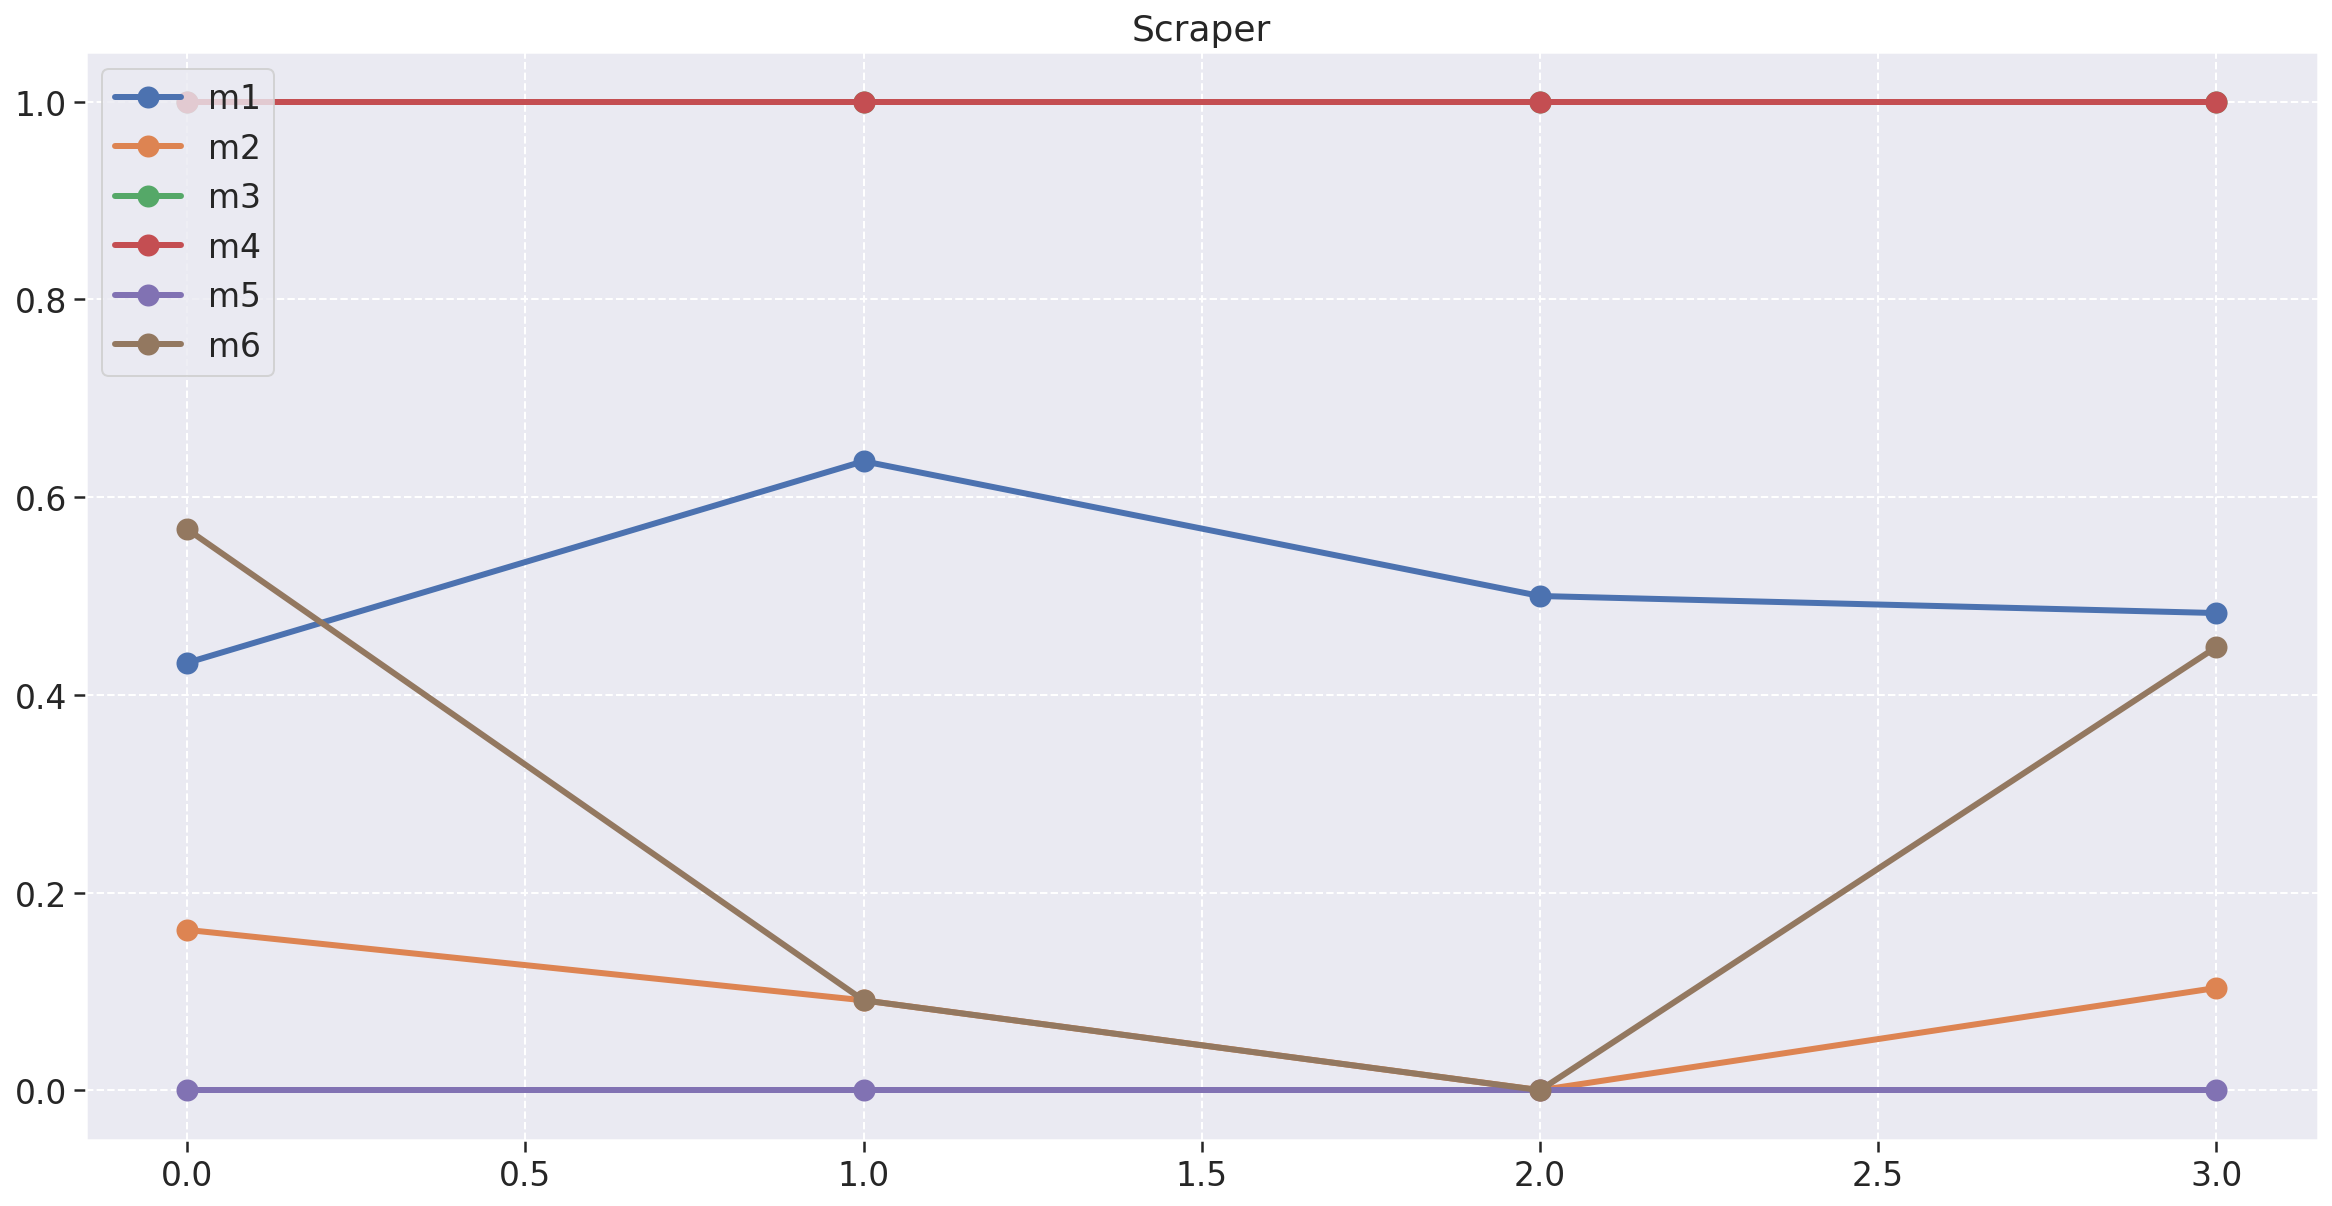

In [60]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper')
plt.plot(scraper_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(scraper_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(scraper_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(scraper_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(scraper_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(scraper_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Documents API

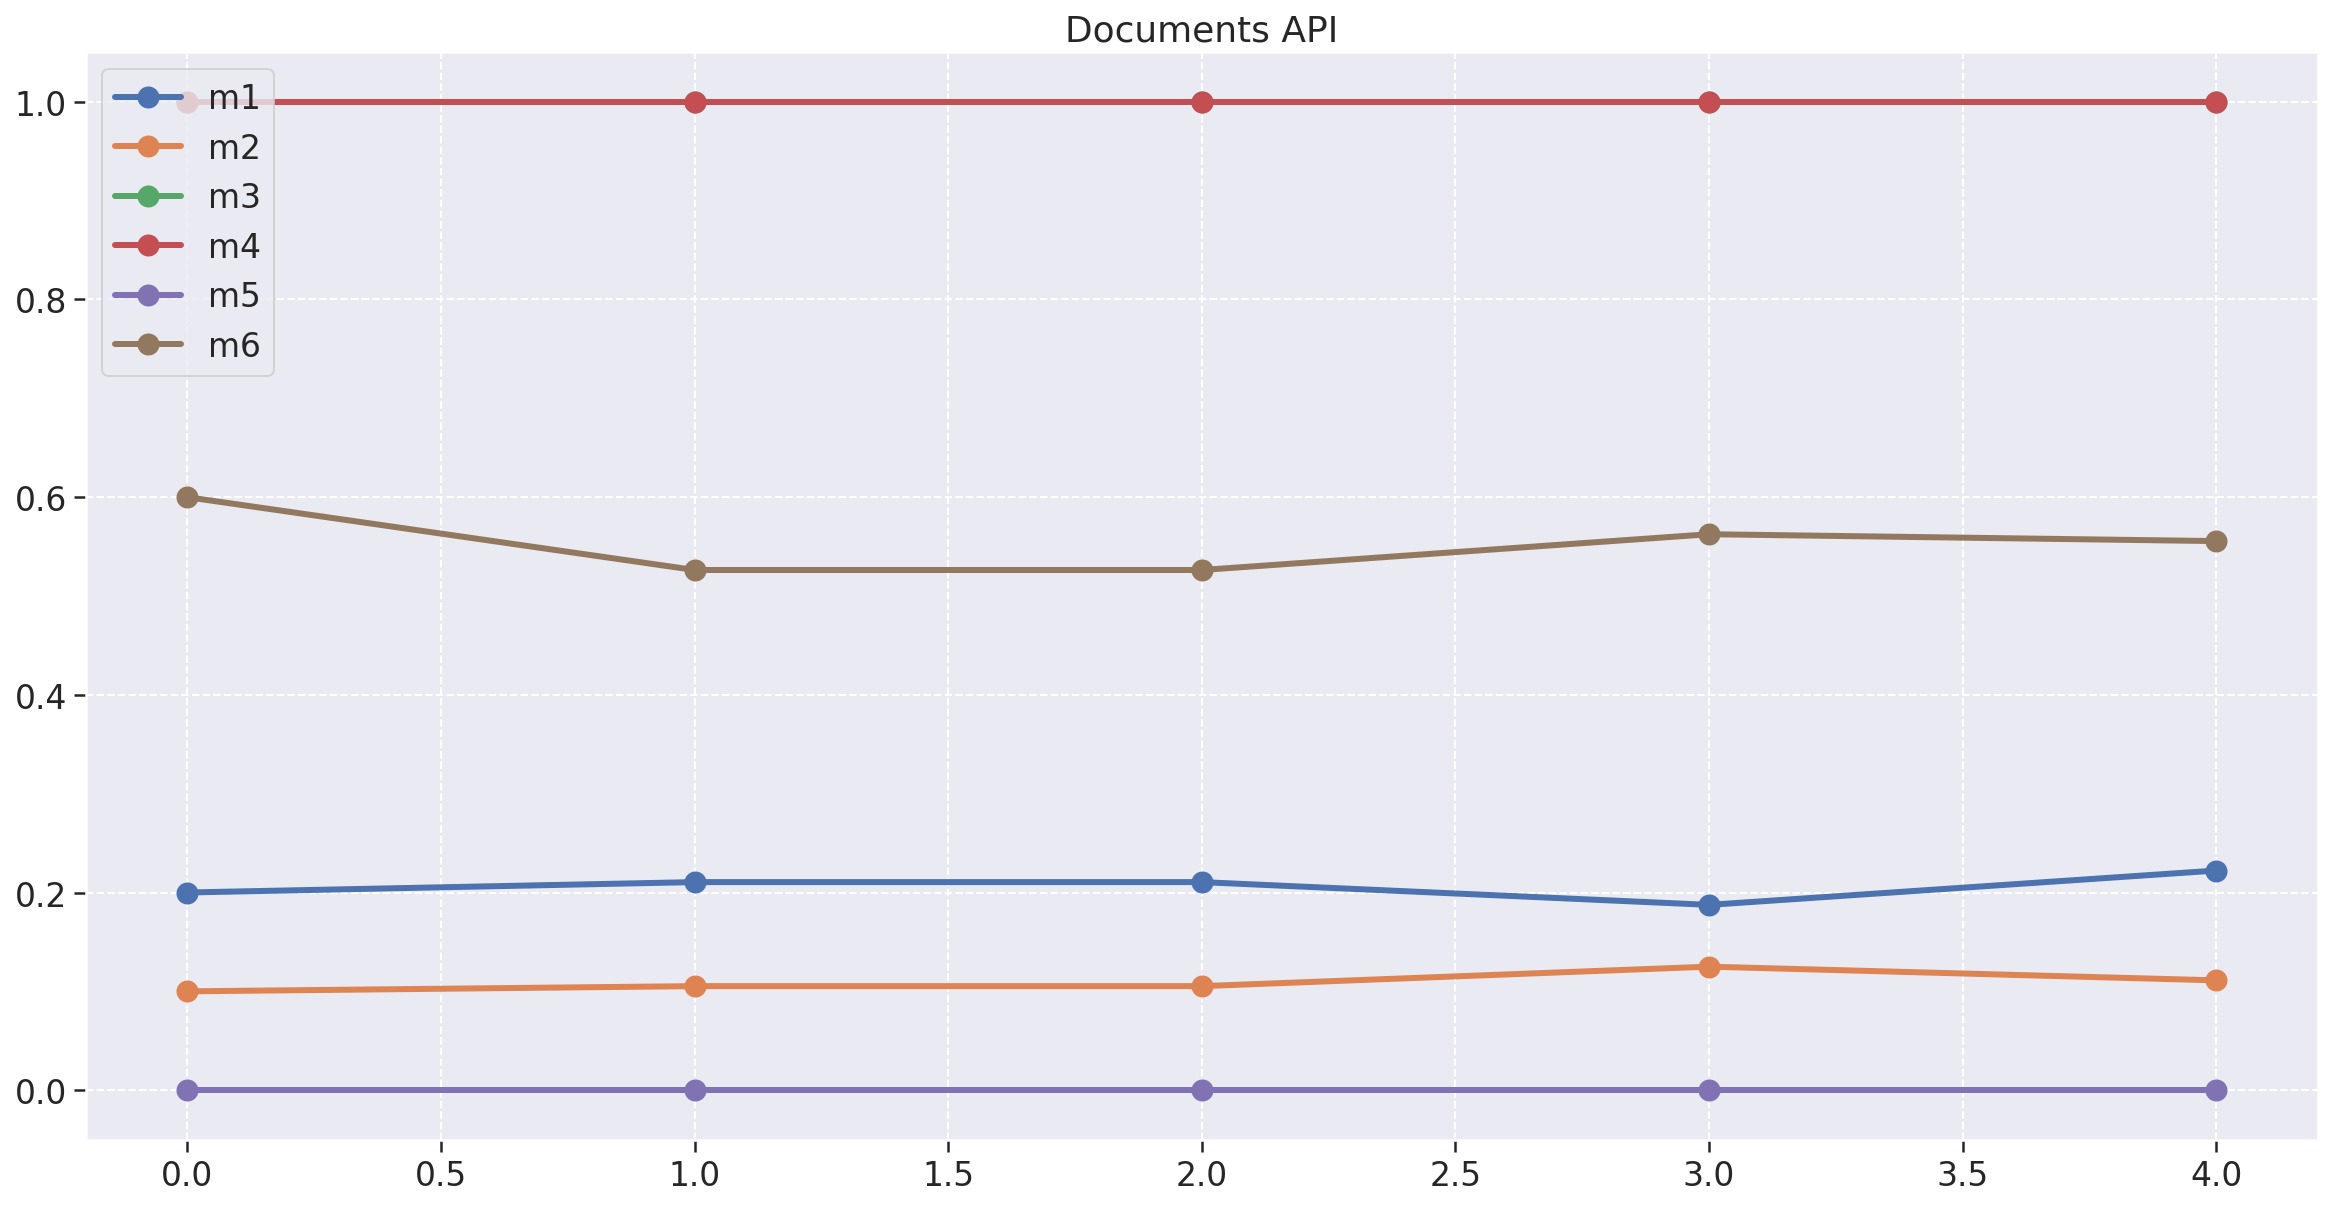

In [61]:
fig = plt.figure(figsize=(20, 10))

plt.title('Documents API')
plt.plot(documentsapi_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(documentsapi_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(documentsapi_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(documentsapi_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(documentsapi_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(documentsapi_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### ML Training

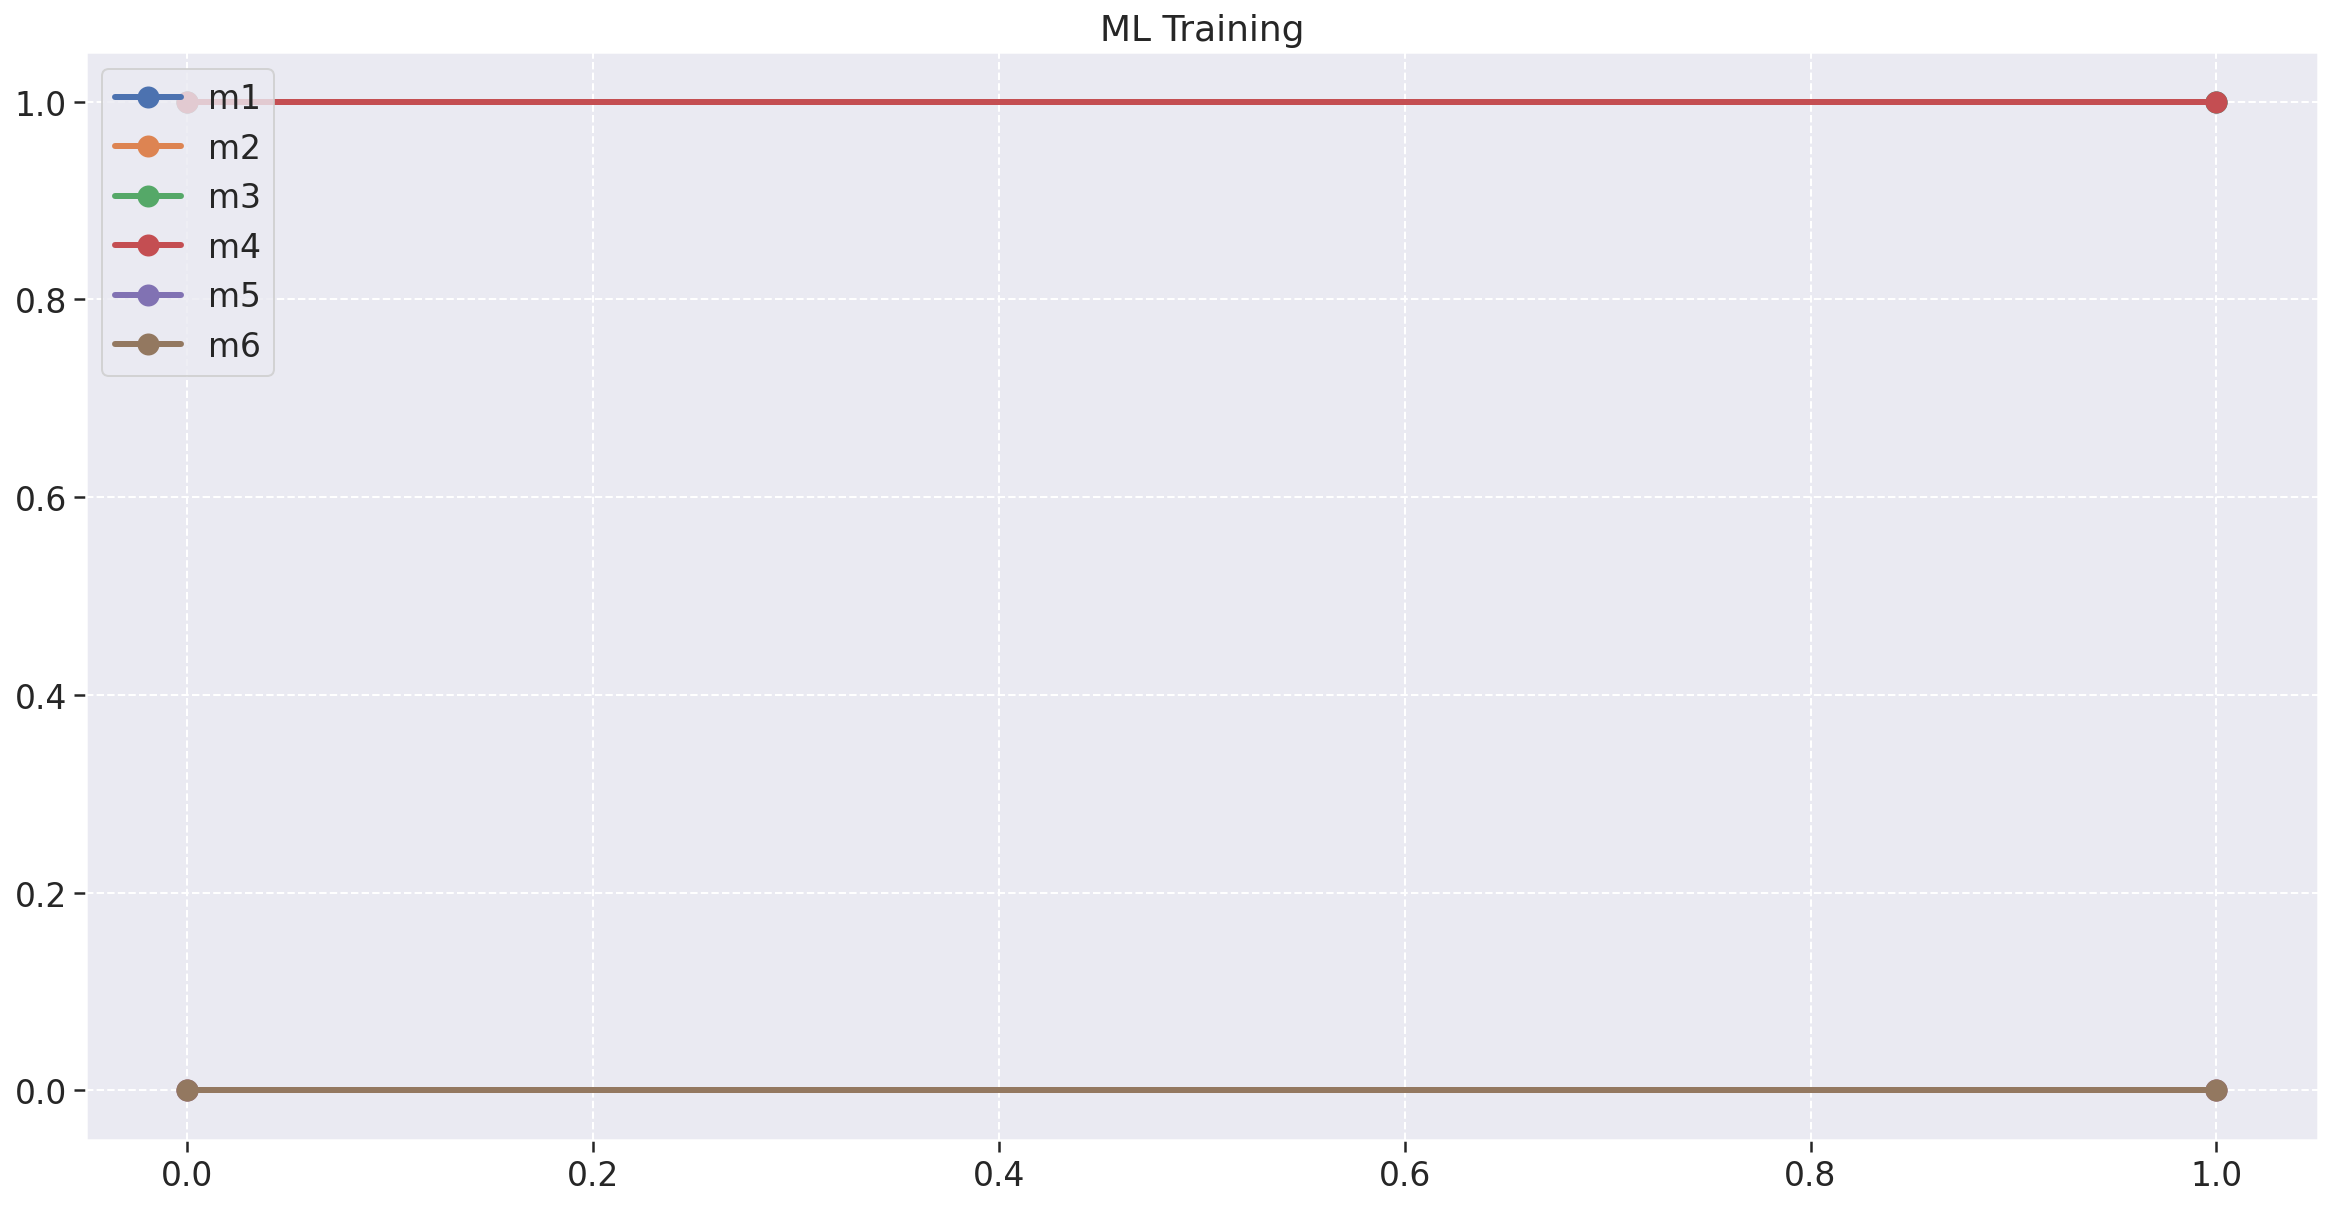

In [62]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training')
plt.plot(mltraining_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(mltraining_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(mltraining_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(mltraining_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(mltraining_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(mltraining_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Front End

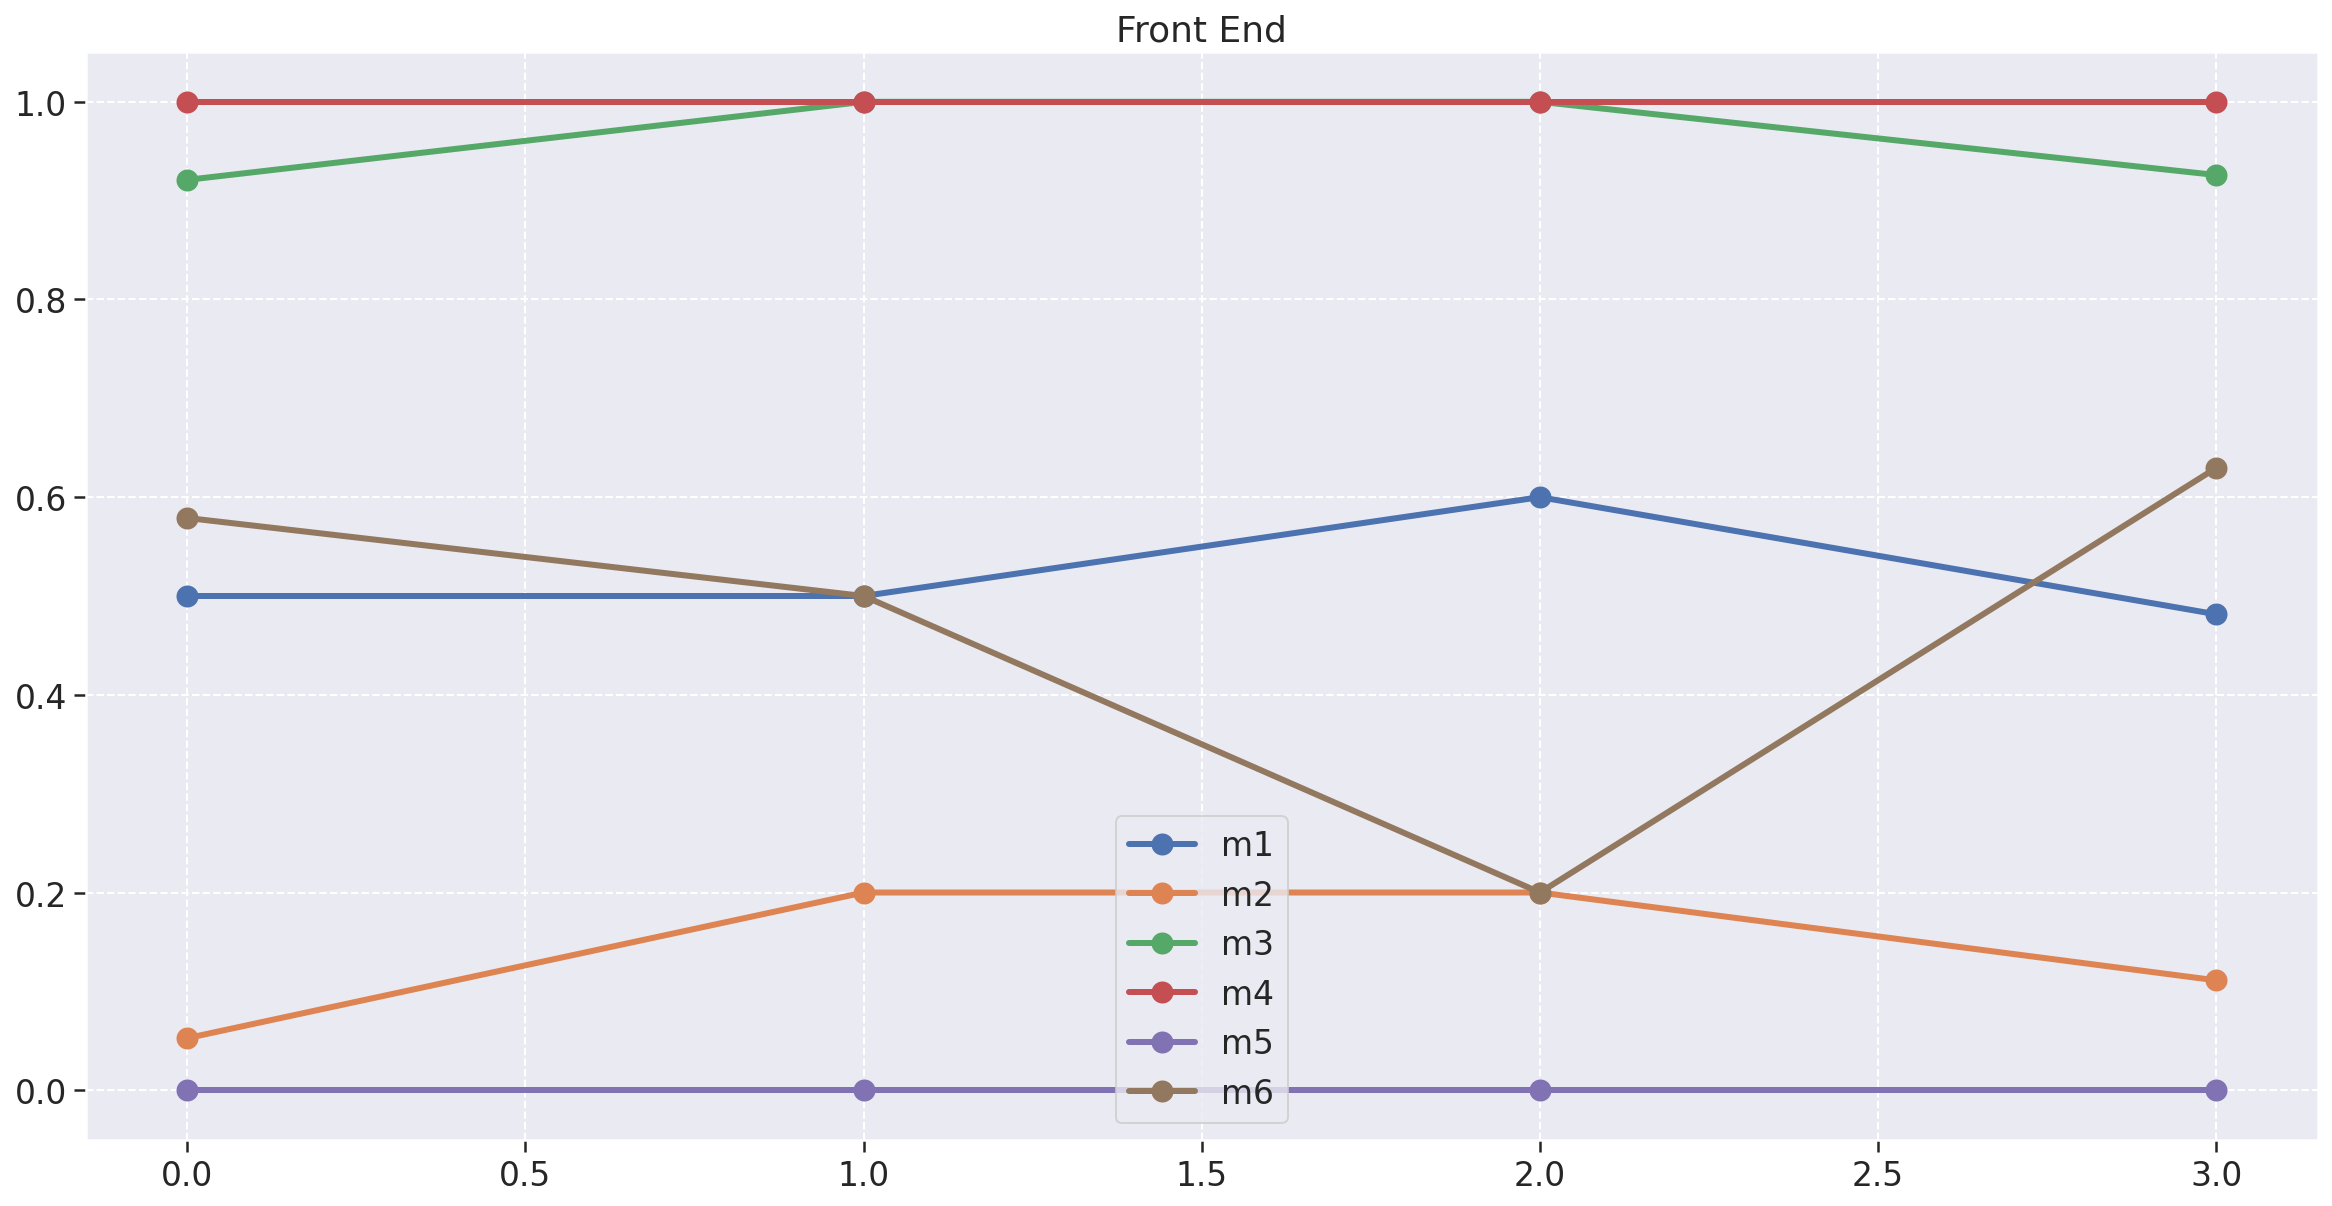

In [63]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End')
plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(frontend_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(frontend_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [64]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

scraper_metrics['code_quality'] = ((scraper_metrics['m1']*pm1) + (scraper_metrics['m2']*pm2) + (scraper_metrics['m3']*pm3)) * psc1
documentsapi_metrics['code_quality'] = ((documentsapi_metrics['m1']*pm1) + (documentsapi_metrics['m2']*pm2) + (documentsapi_metrics['m3']*pm3)) * psc1
mltraining_metrics['code_quality'] = ((mltraining_metrics['m1']*pm1) + (mltraining_metrics['m2']*pm2) + (mltraining_metrics['m3']*pm3)) * psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1) + (frontend_metrics['m2']*pm2) + (frontend_metrics['m3']*pm3)) * psc1

scraper_metrics['testing_status'] = ((scraper_metrics['m4']*pm4) + (scraper_metrics['m5']*pm5) + (scraper_metrics['m6']*pm6)) * psc2
documentsapi_metrics['testing_status'] = ((documentsapi_metrics['m4']*pm4) + (documentsapi_metrics['m5']*pm5) + (documentsapi_metrics['m6']*pm6)) * psc2
mltraining_metrics['testing_status'] = ((mltraining_metrics['m4']*pm4) + (mltraining_metrics['m5']*pm5) + (mltraining_metrics['m6']*pm6)) * psc2
frontend_metrics['testing_status'] = ((frontend_metrics['m4']*pm4) + (frontend_metrics['m5']*pm5) + (frontend_metrics['m6']*pm6)) * psc2

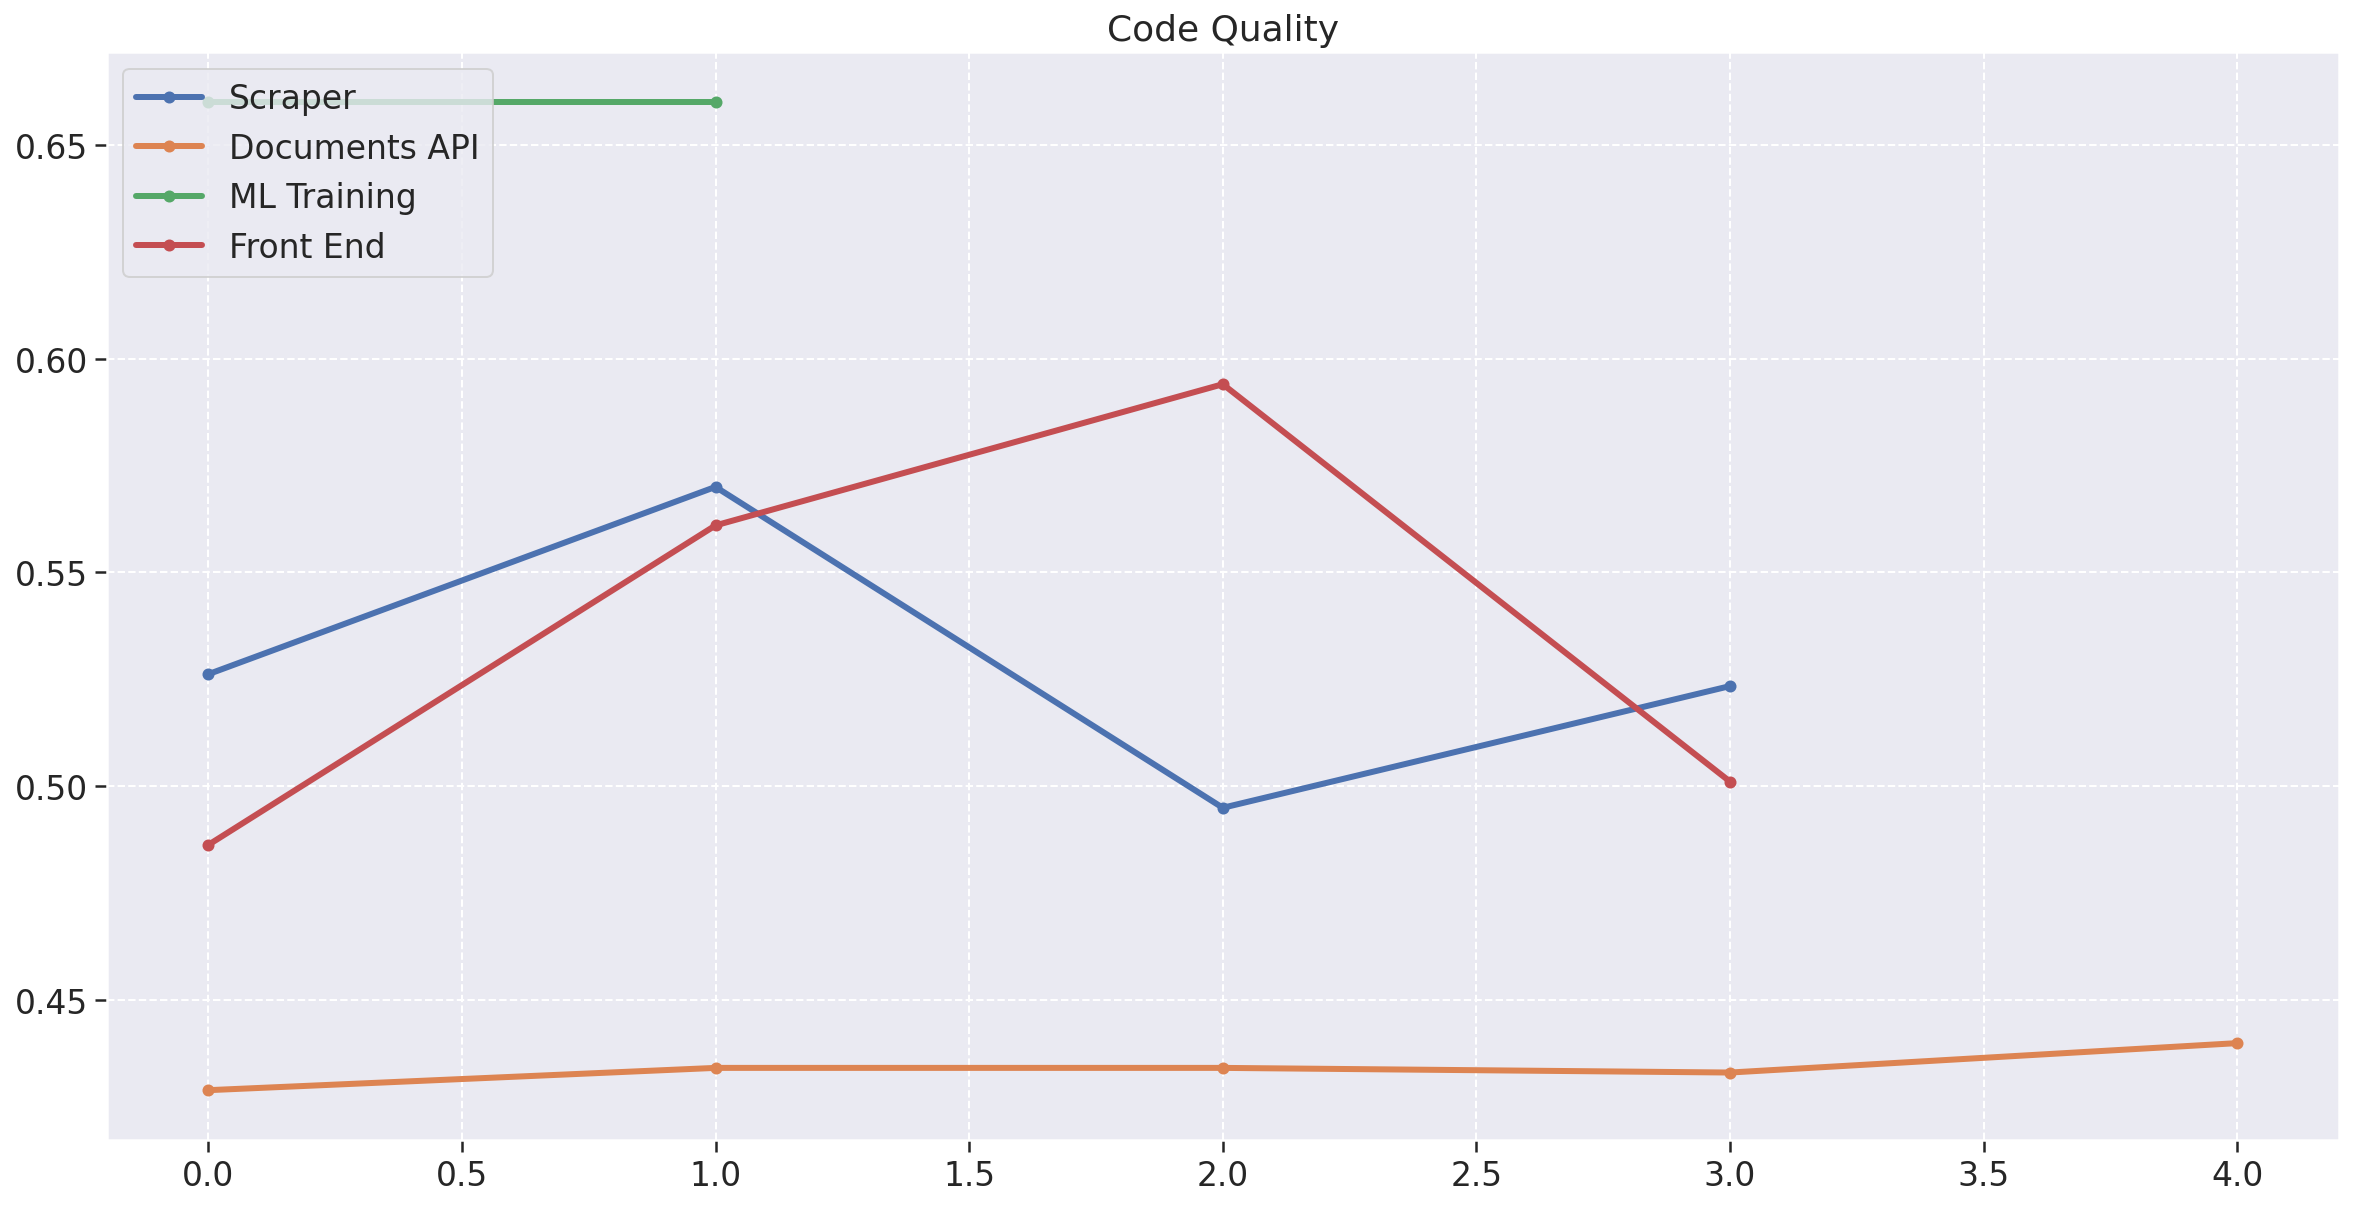

In [65]:
fig = plt.figure(figsize=(20, 10))


plt.title('Code Quality')
plt.plot(scraper_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

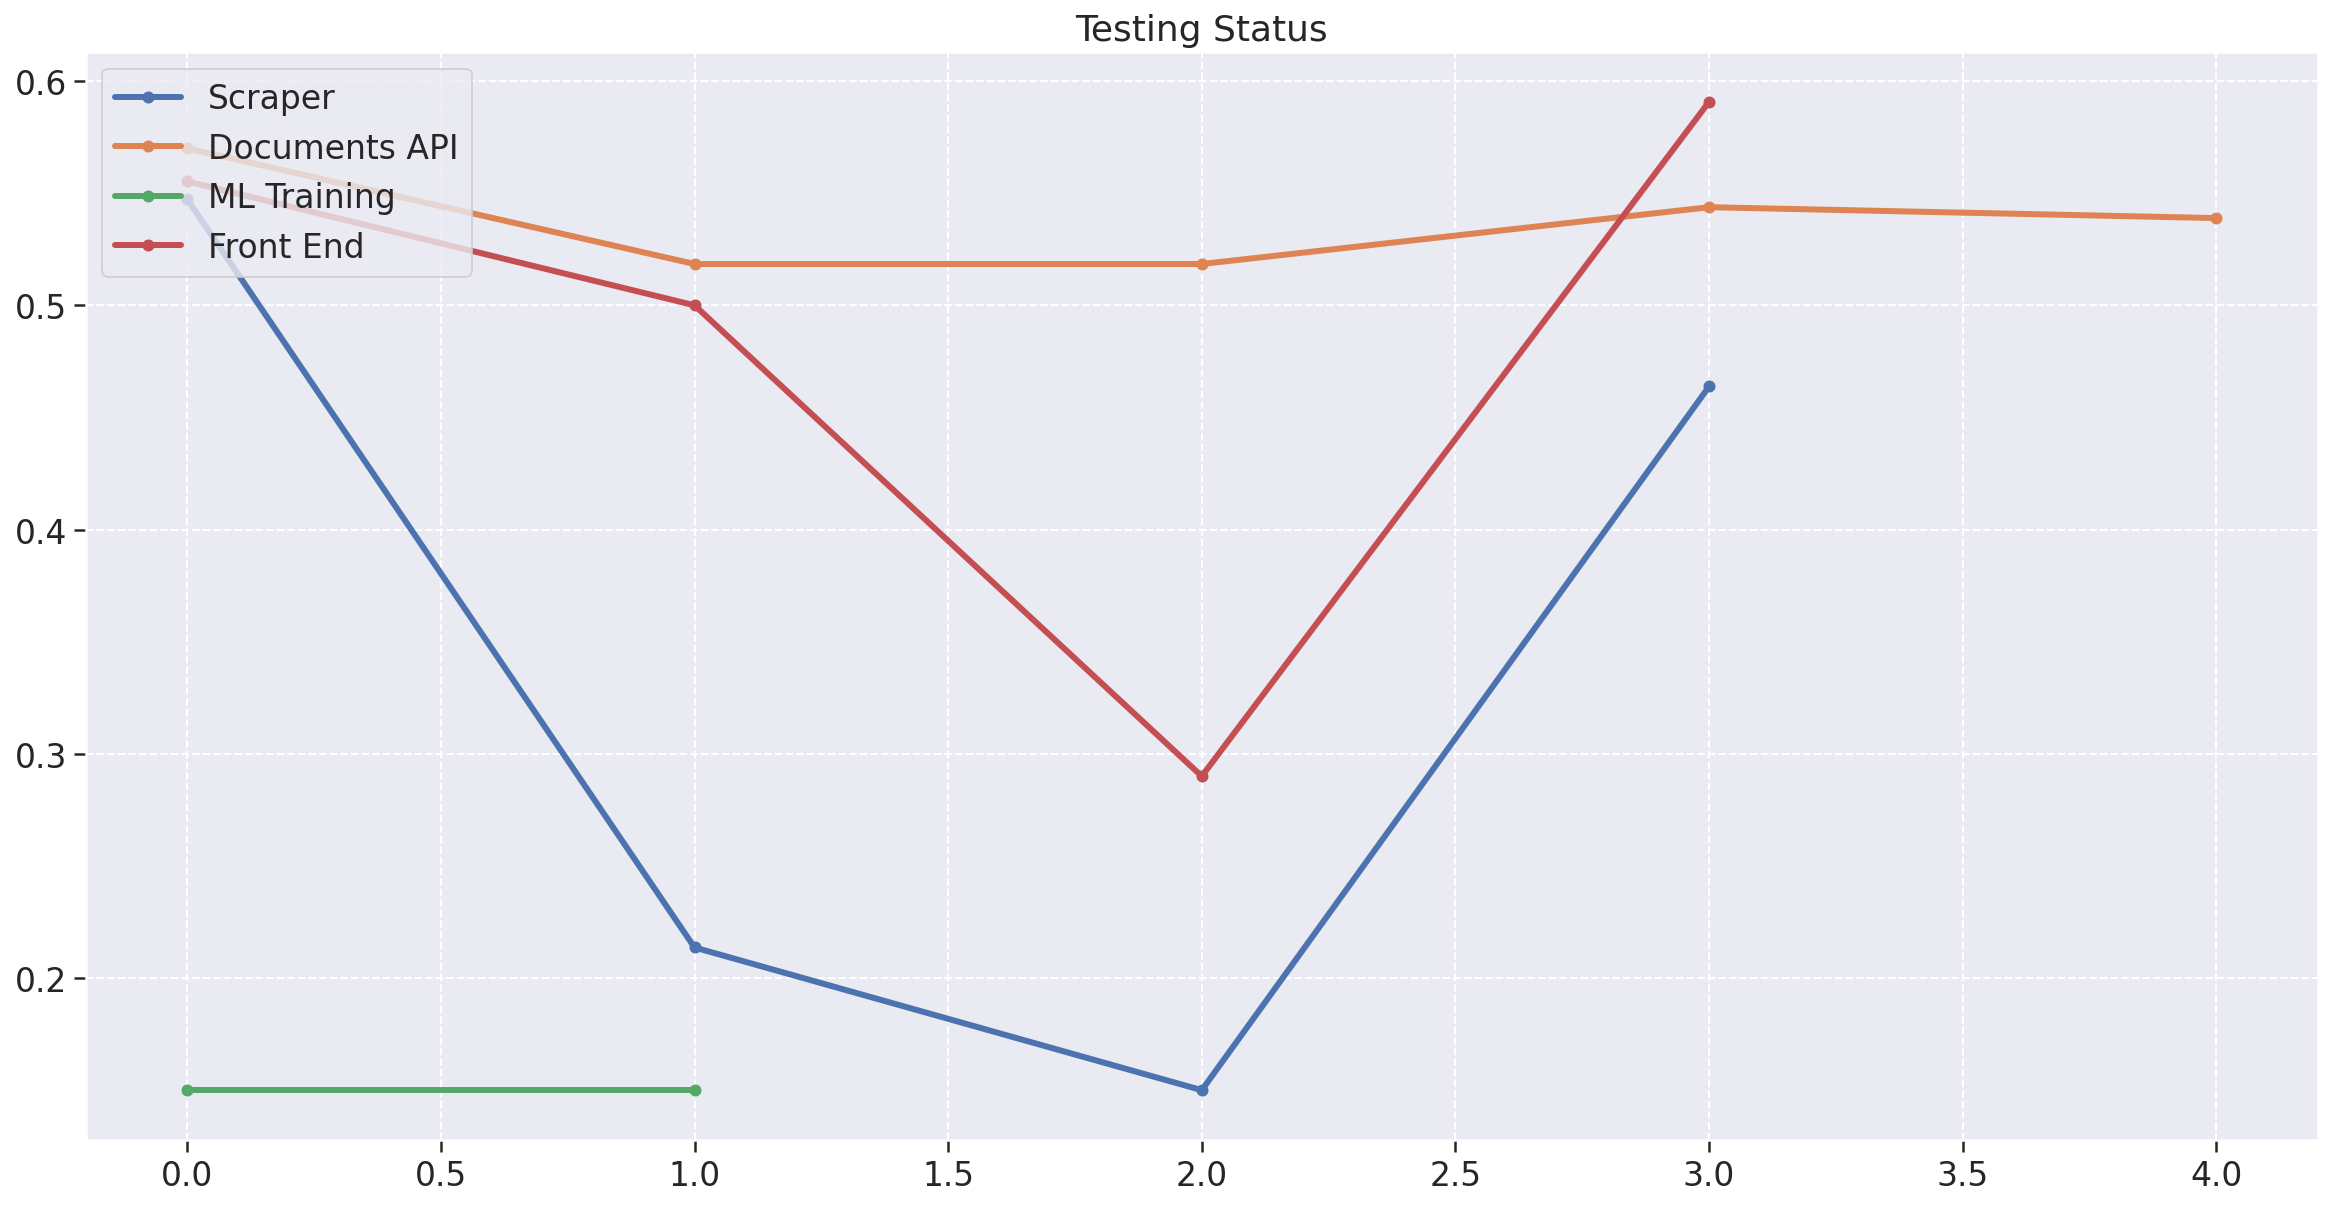

In [66]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(scraper_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

## Descriptive Statistics

### Scraper

In [67]:
scraper_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.432432,0.162162,1.0,1.0,0,0.567568,Scraper,02-11-2021-23-26,1348,0.526216,0.547297
1,0.636364,0.090909,1.0,1.0,0,0.090909,Scraper,07-10-2021-07-43,484,0.570000,0.213636
2,0.500000,0.000000,1.0,1.0,0,0.000000,Scraper,15-09-2021-00-01,138,0.495000,0.150000
3,0.482759,0.103448,1.0,1.0,0,0.448276,Scraper,21-10-2021-15-11,1058,0.523448,0.463793


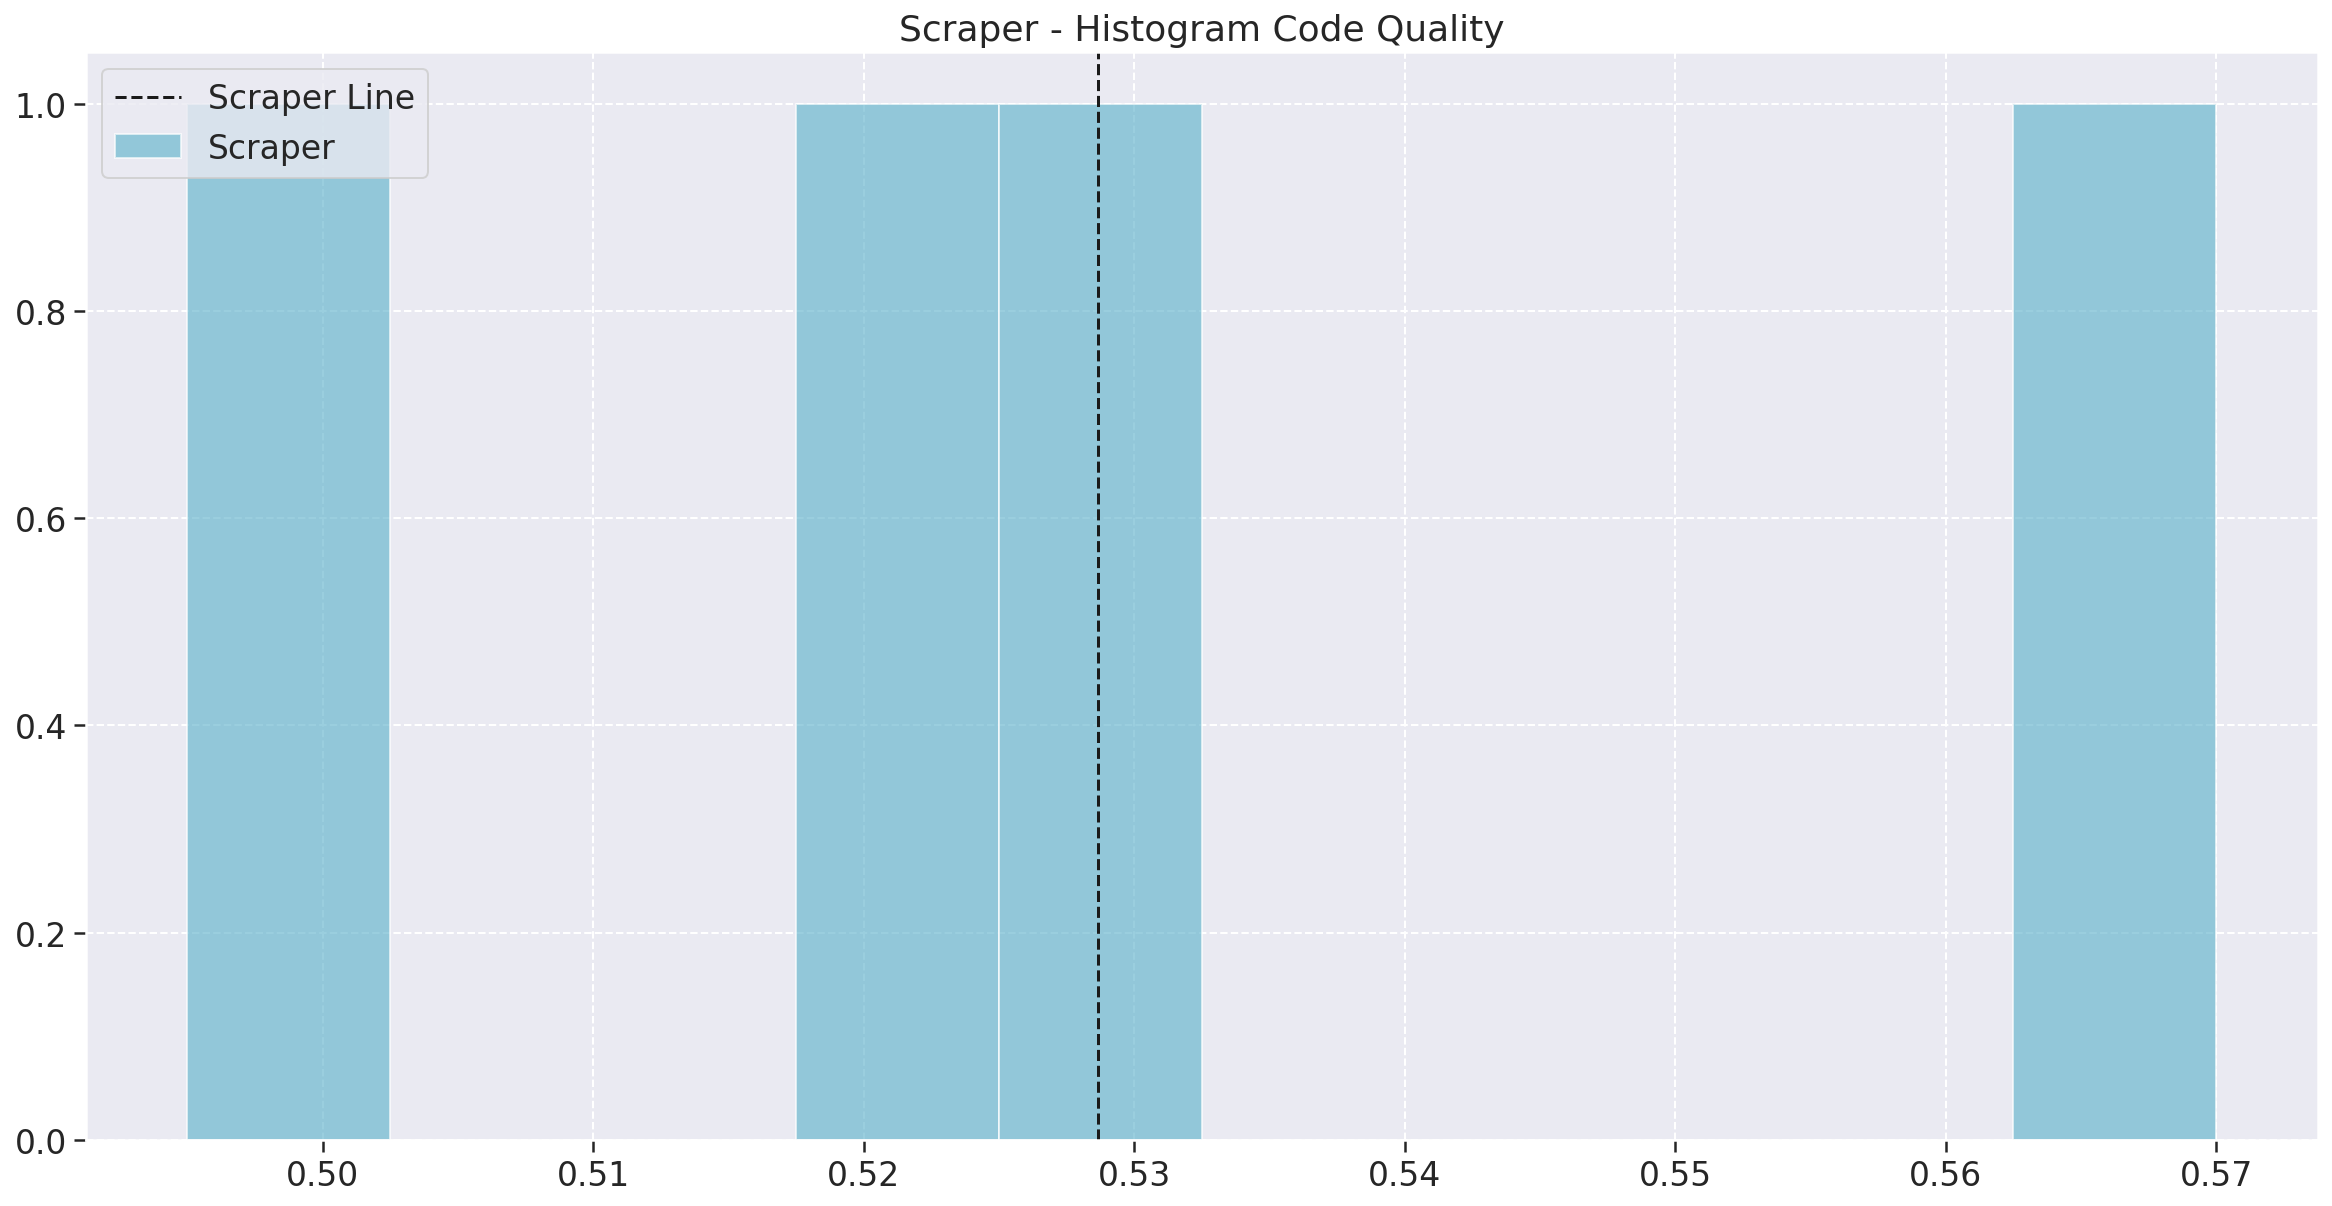

In [68]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Code Quality')
plt.hist(scraper_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

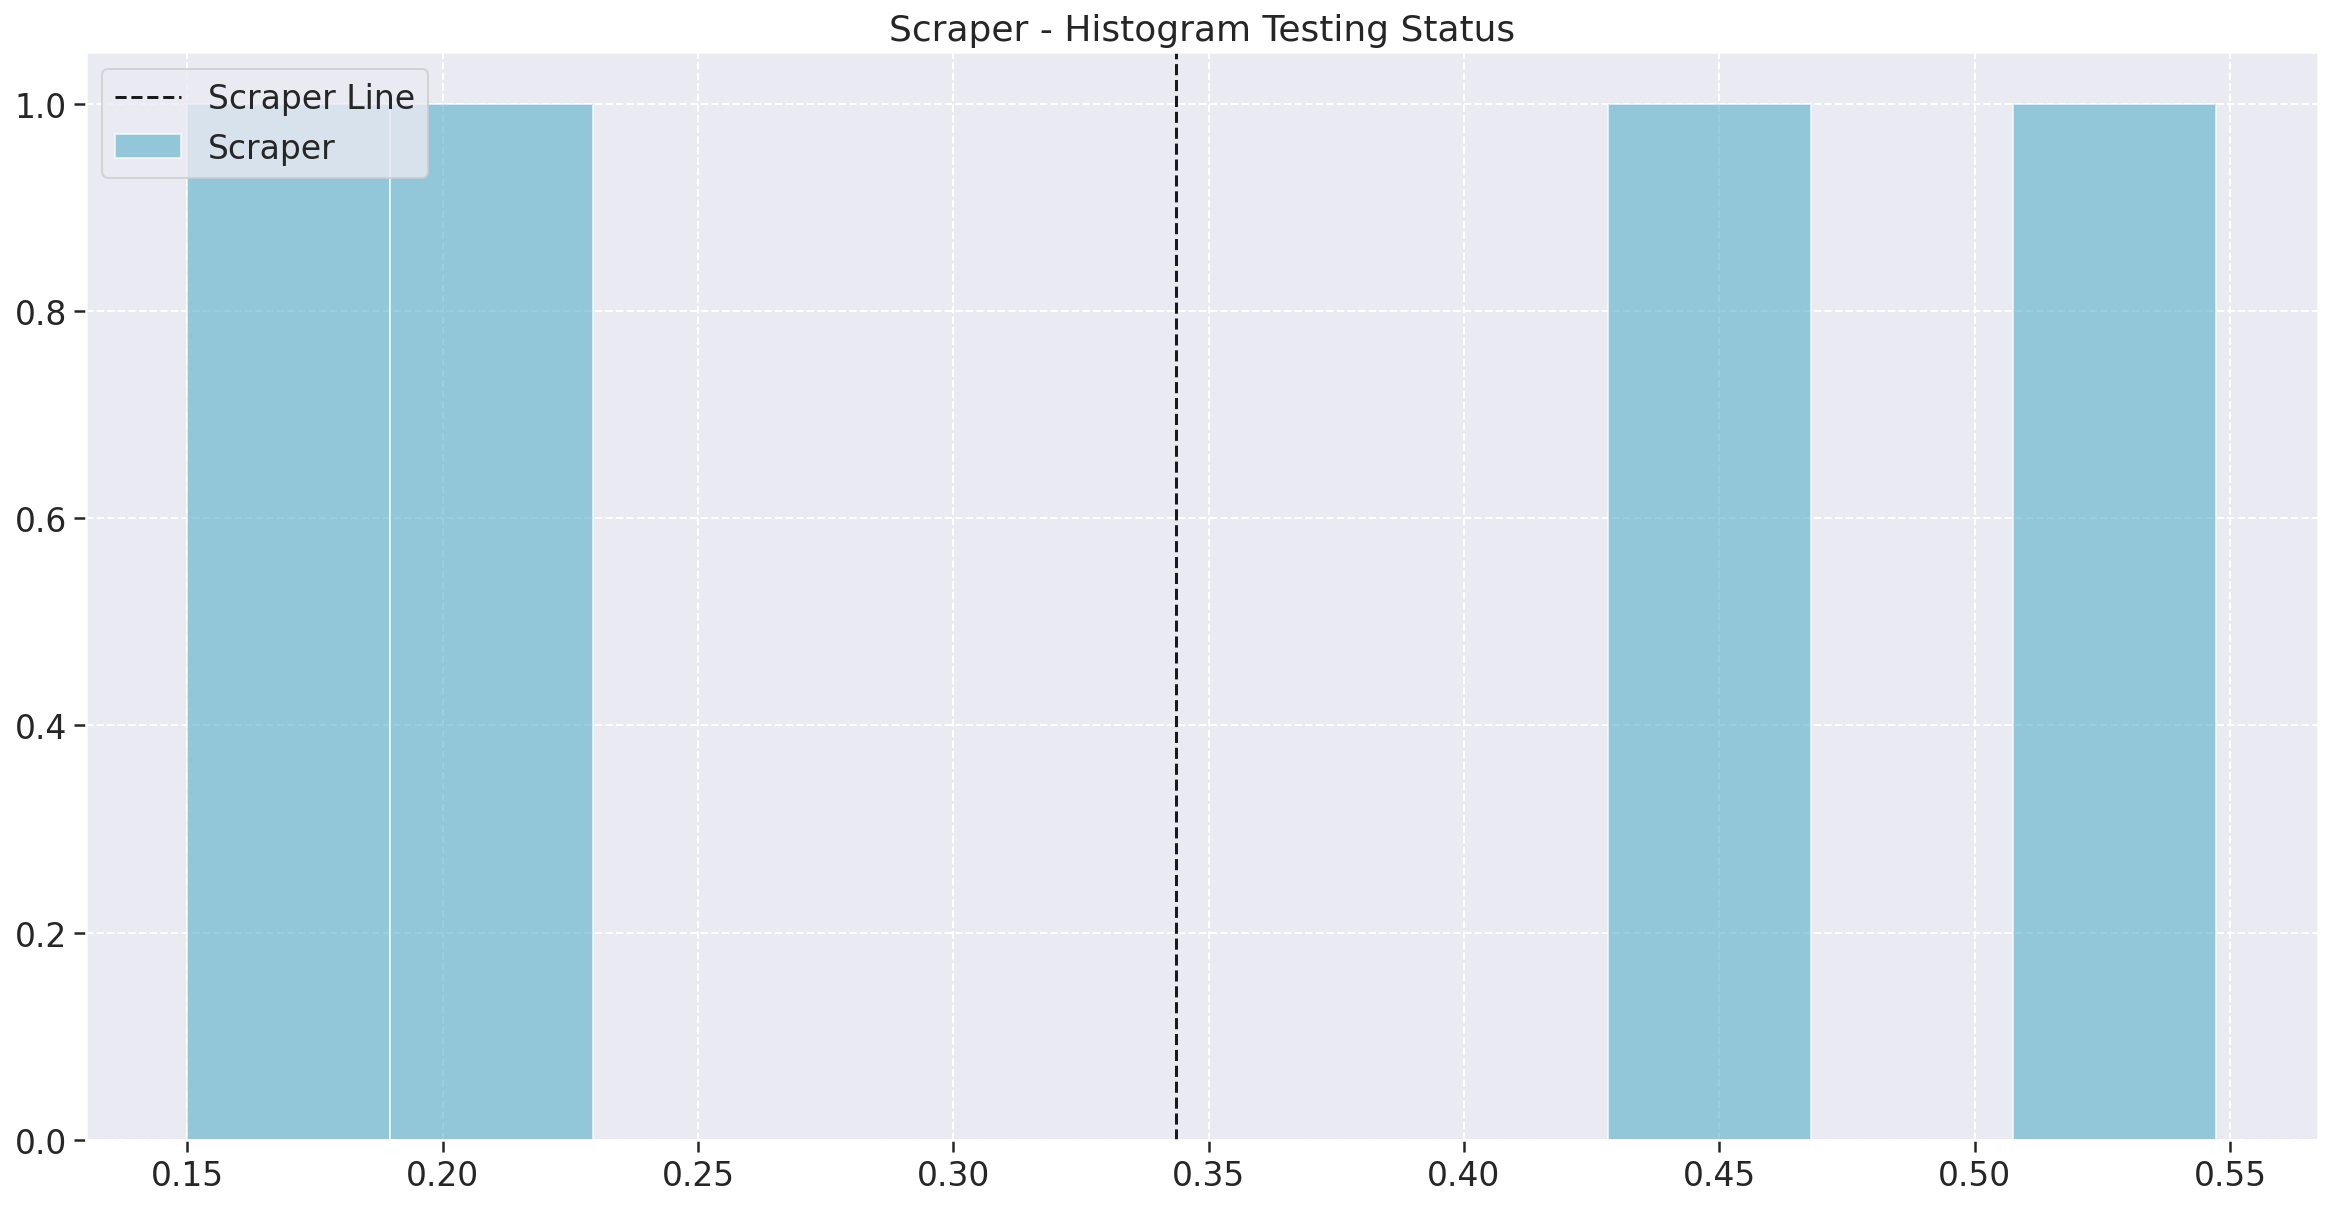

In [69]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Testing Status')
plt.hist(scraper_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f98835970>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f987be0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f988355e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f987be7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f987beb80>],
 'means': []}

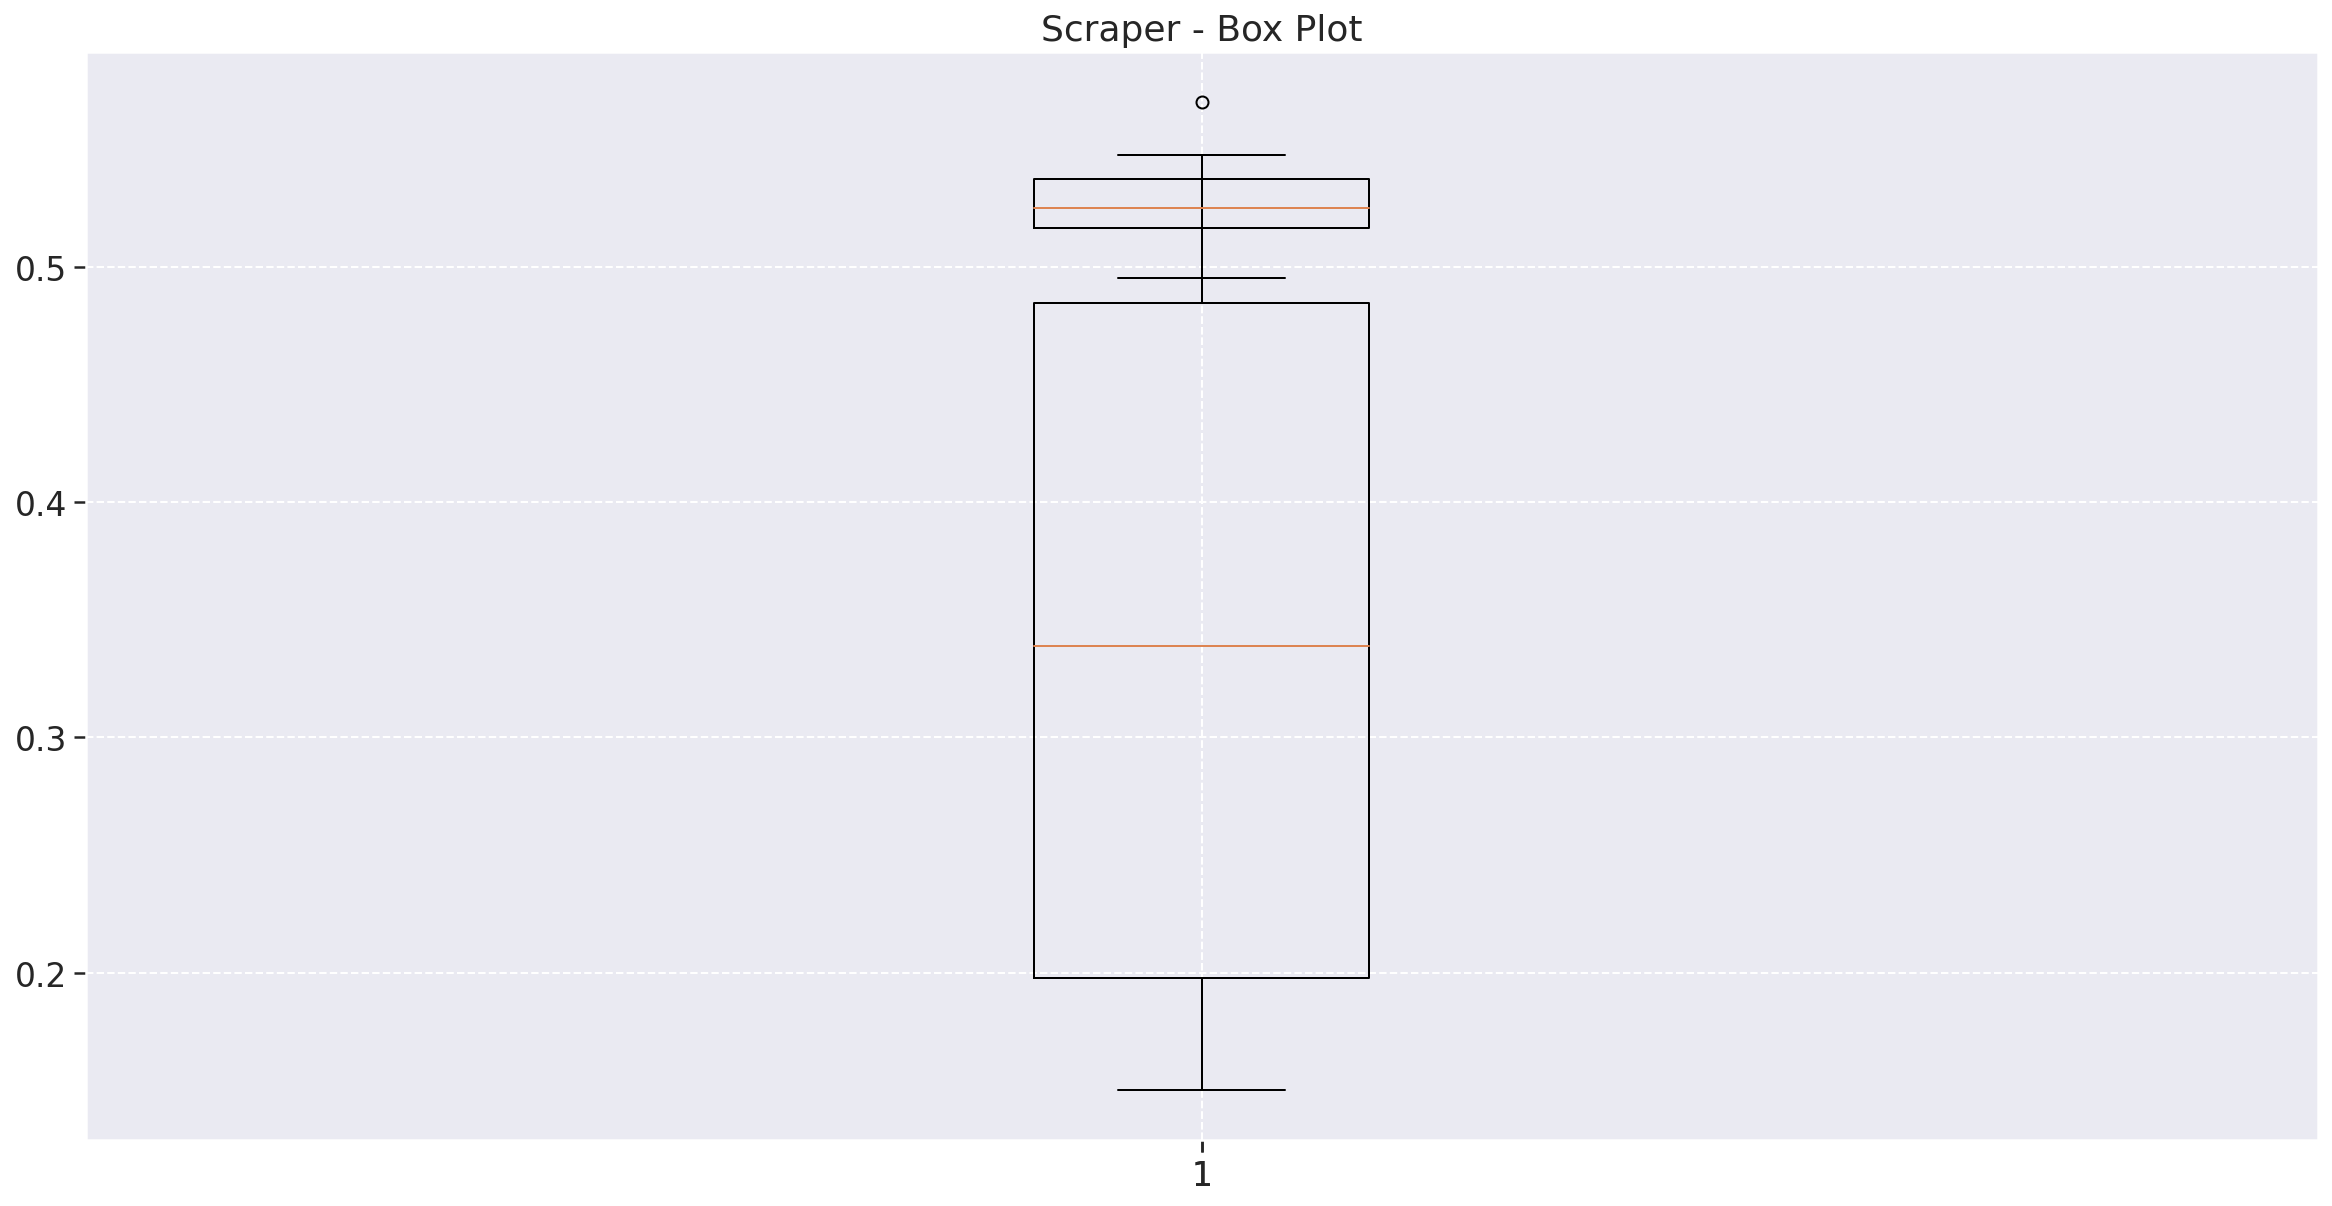

In [70]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Box Plot')
plt.boxplot(scraper_metrics['code_quality'])
plt.boxplot(scraper_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Scraper')

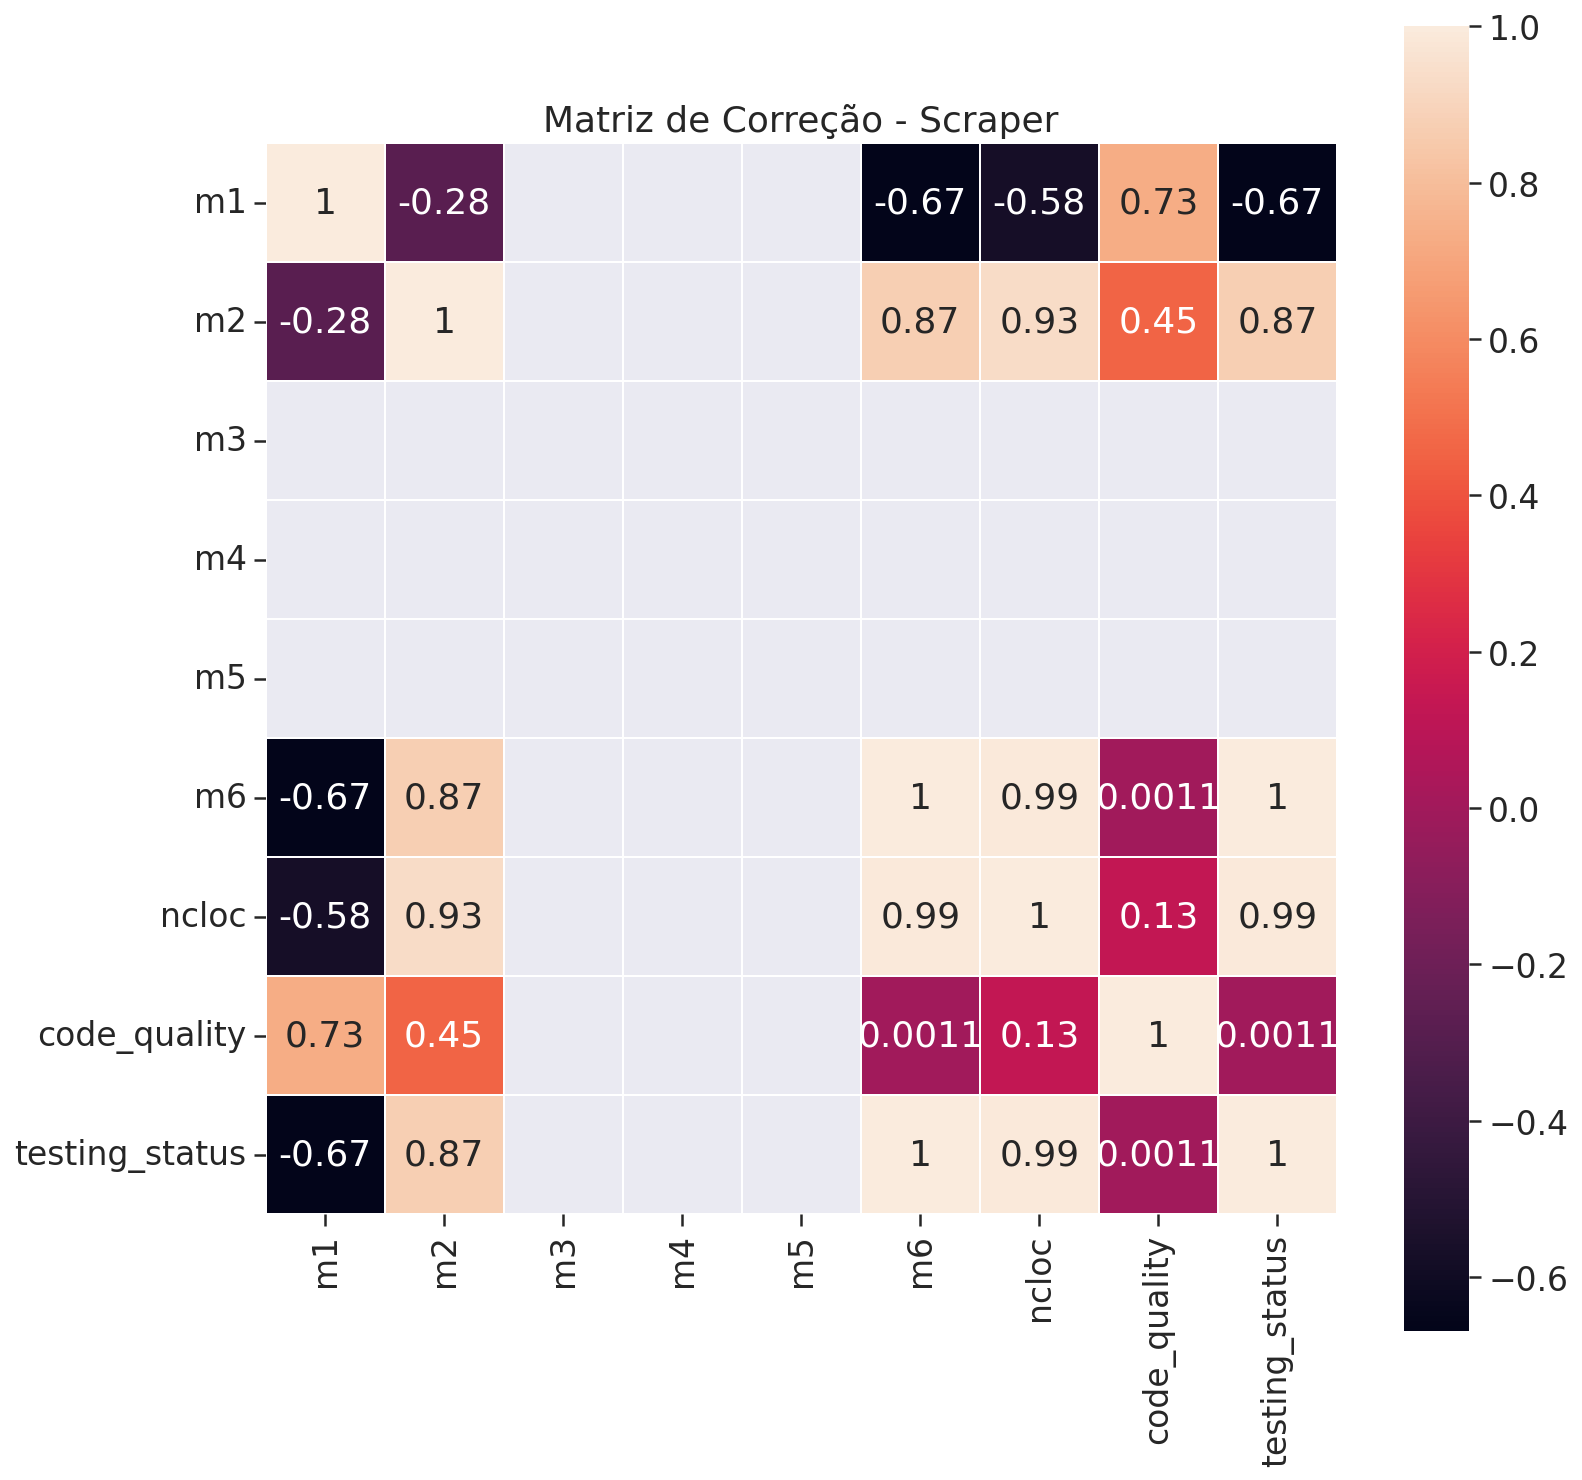

In [71]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(scraper_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Scraper')

#### Analysis - Scraper

Explain here.

### Document API

In [72]:
documentsapi_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.200000,0.100000,1.0,1.0,0,0.600000,DocumentsAPI,02-11-2021-23-35,359,0.429000,0.570000
1,0.210526,0.105263,1.0,1.0,0,0.526316,DocumentsAPI,07-10-2021-07-31,336,0.434211,0.518421
2,0.210526,0.105263,1.0,1.0,0,0.526316,DocumentsAPI,07-10-2021-12-28,341,0.434211,0.518421
3,0.187500,0.125000,1.0,1.0,0,0.562500,DocumentsAPI,15-09-2021-00-24,289,0.433125,0.543750
4,0.222222,0.111111,1.0,1.0,0,0.555556,DocumentsAPI,15-10-2021-20-45,266,0.440000,0.538889


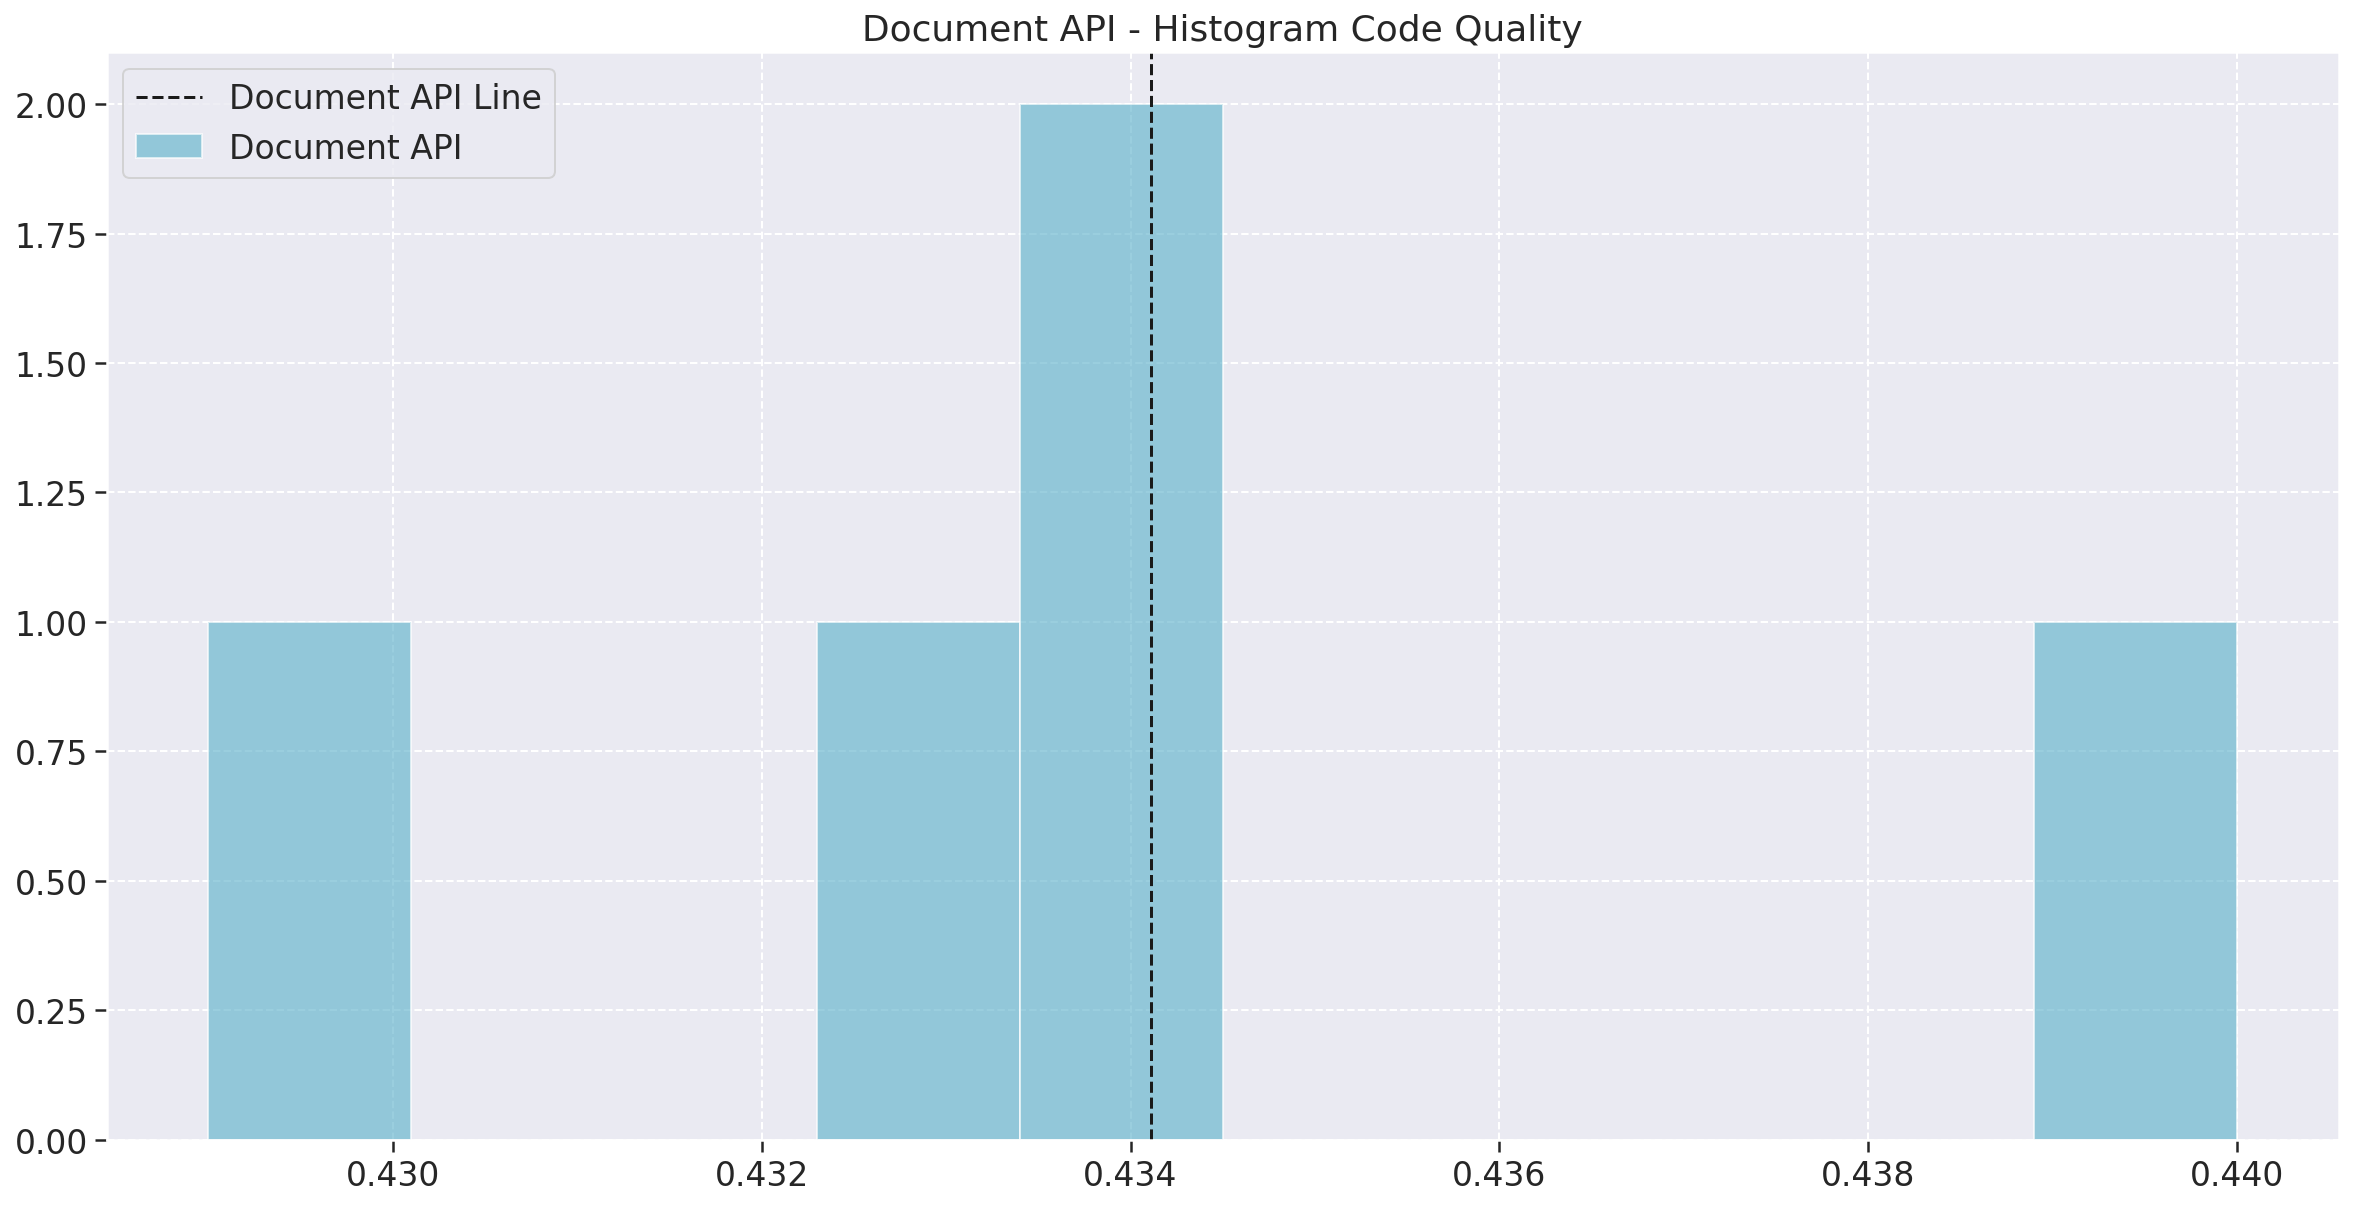

In [73]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Histogram Code Quality')
plt.hist(documentsapi_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Document API')
plt.axvline(documentsapi_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Document API Line')

plt.legend(loc='upper left')

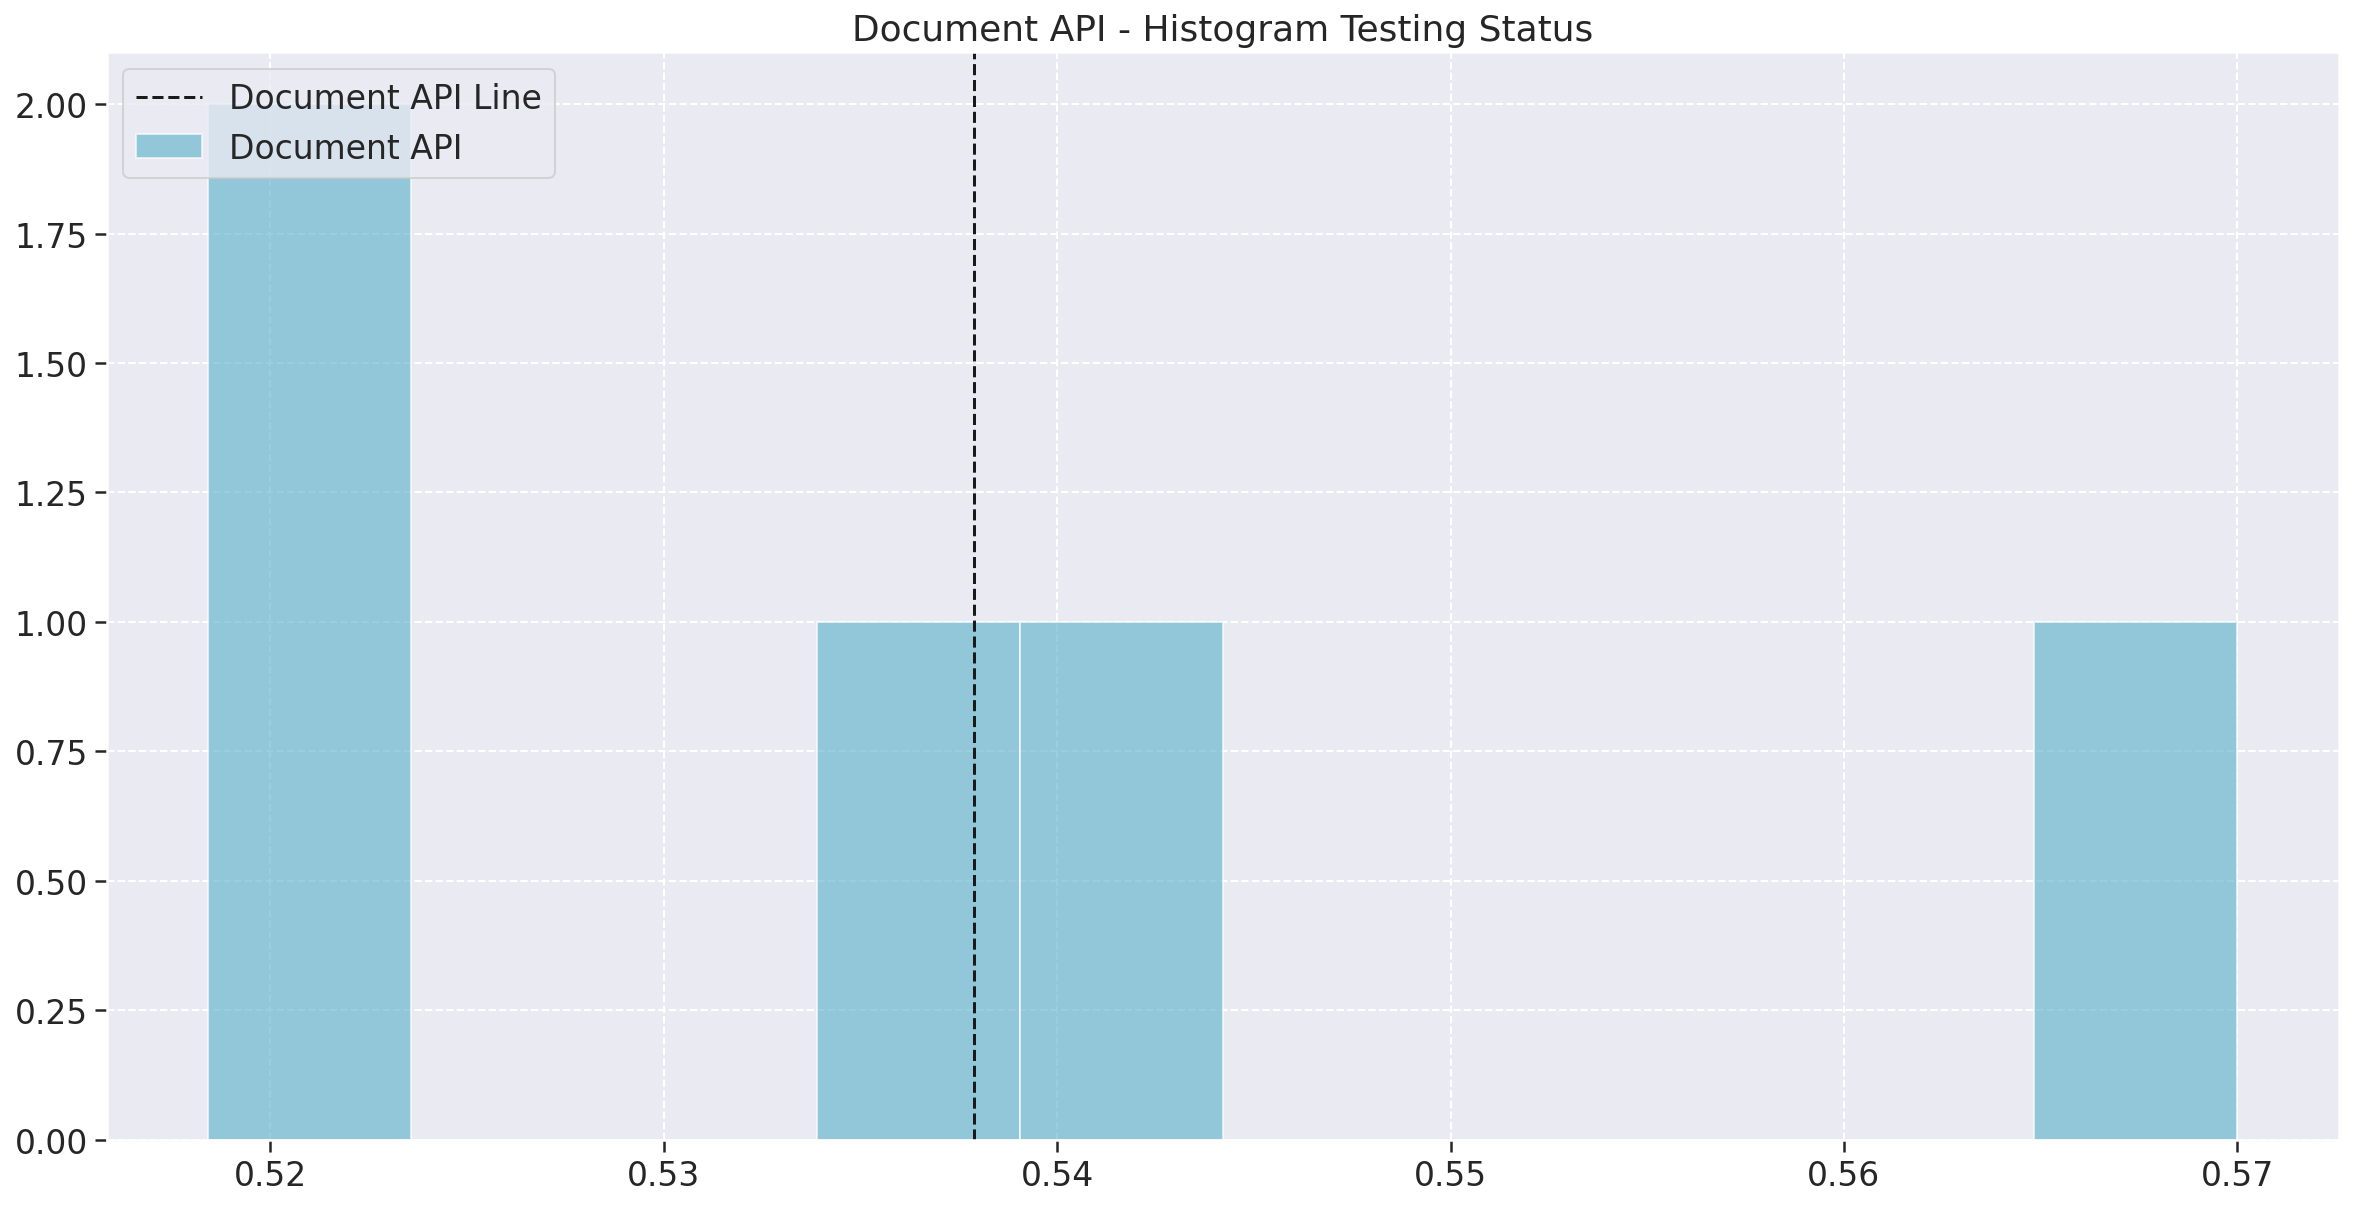

In [74]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Histogram Testing Status')
plt.hist(documentsapi_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Document API')
plt.axvline(documentsapi_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Document API Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f98509400>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f98509b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f98509070>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f98511280>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f98511610>],
 'means': []}

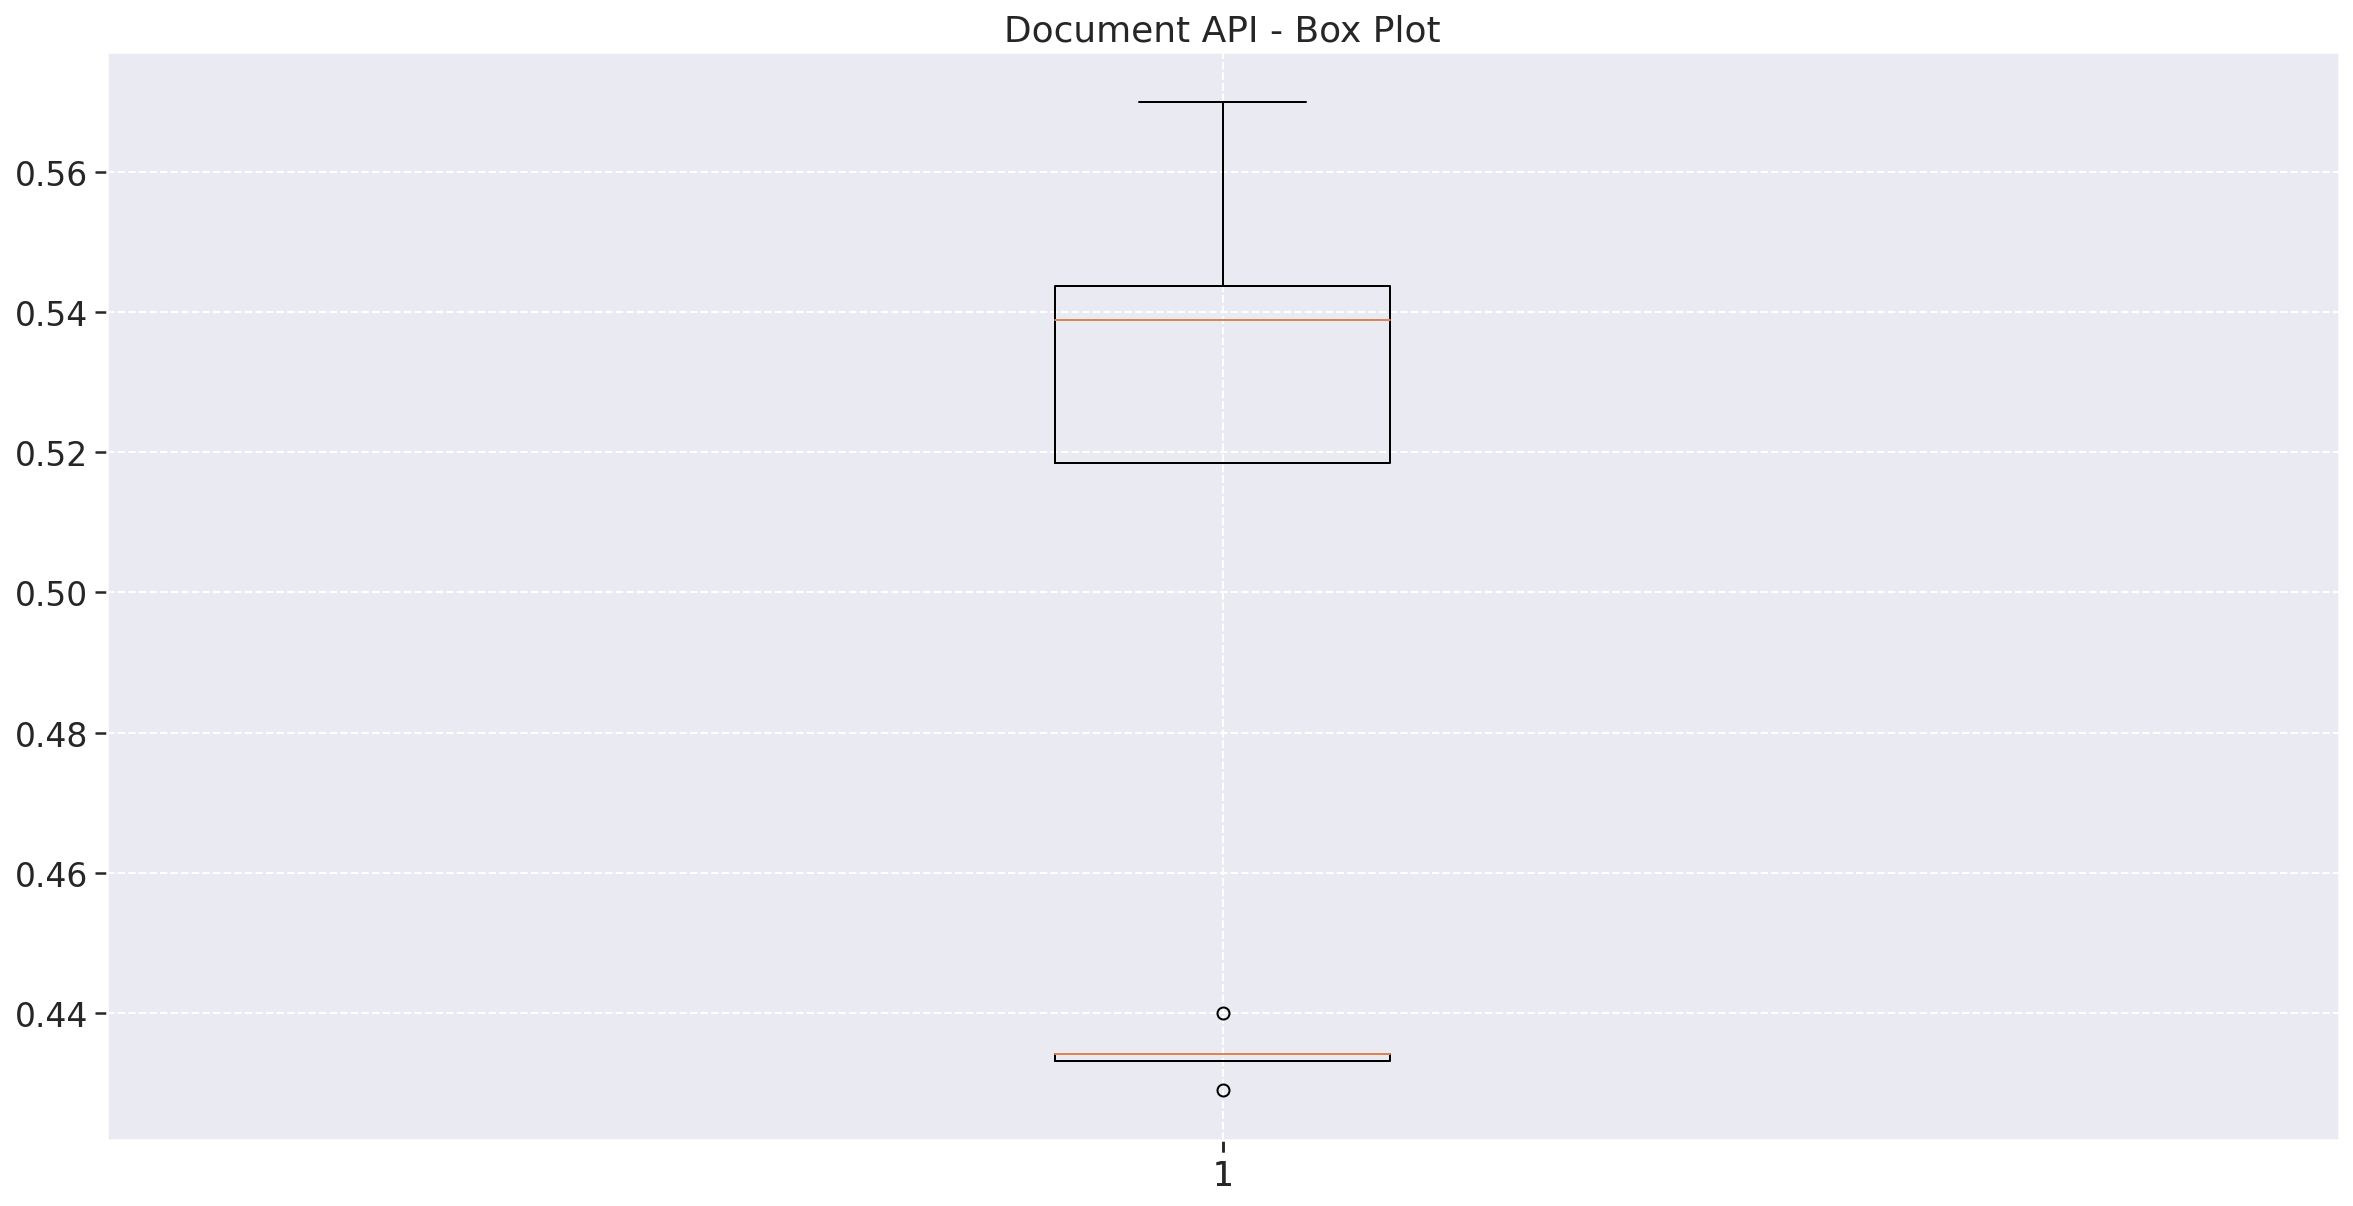

In [75]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Box Plot')
plt.boxplot(documentsapi_metrics['code_quality'])
plt.boxplot(documentsapi_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Document API')

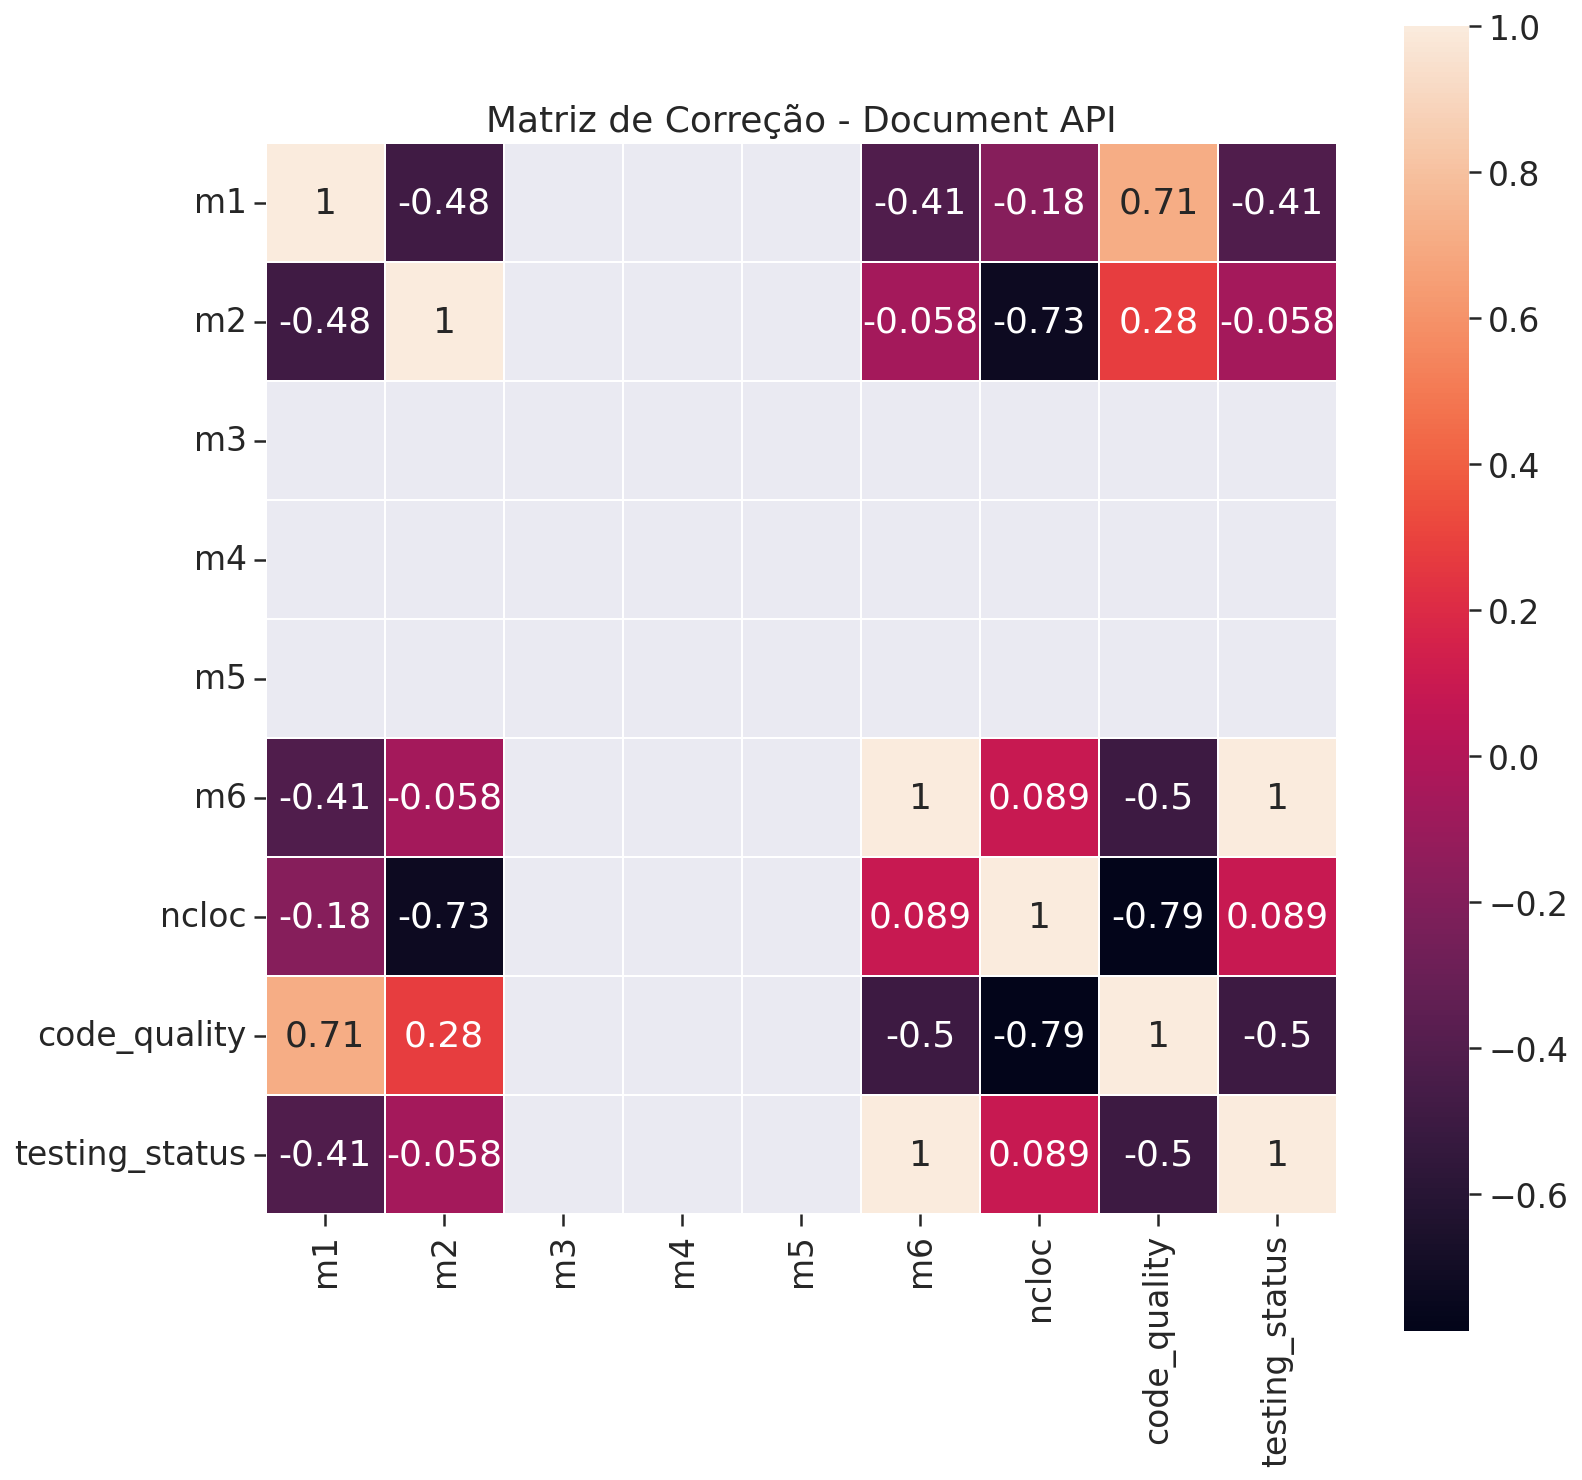

In [76]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(documentsapi_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Document API')

#### Analysis - Document API

Explain here

### ML Training

In [77]:
mltraining_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,1.0,0.0,1.0,1.0,0,0.0,MLTraining,14-09-2021-23-45,138,0.66,0.15
1,1.0,0.0,1.0,1.0,0,0.0,MLTraining,21-10-2021-15-24,138,0.66,0.15


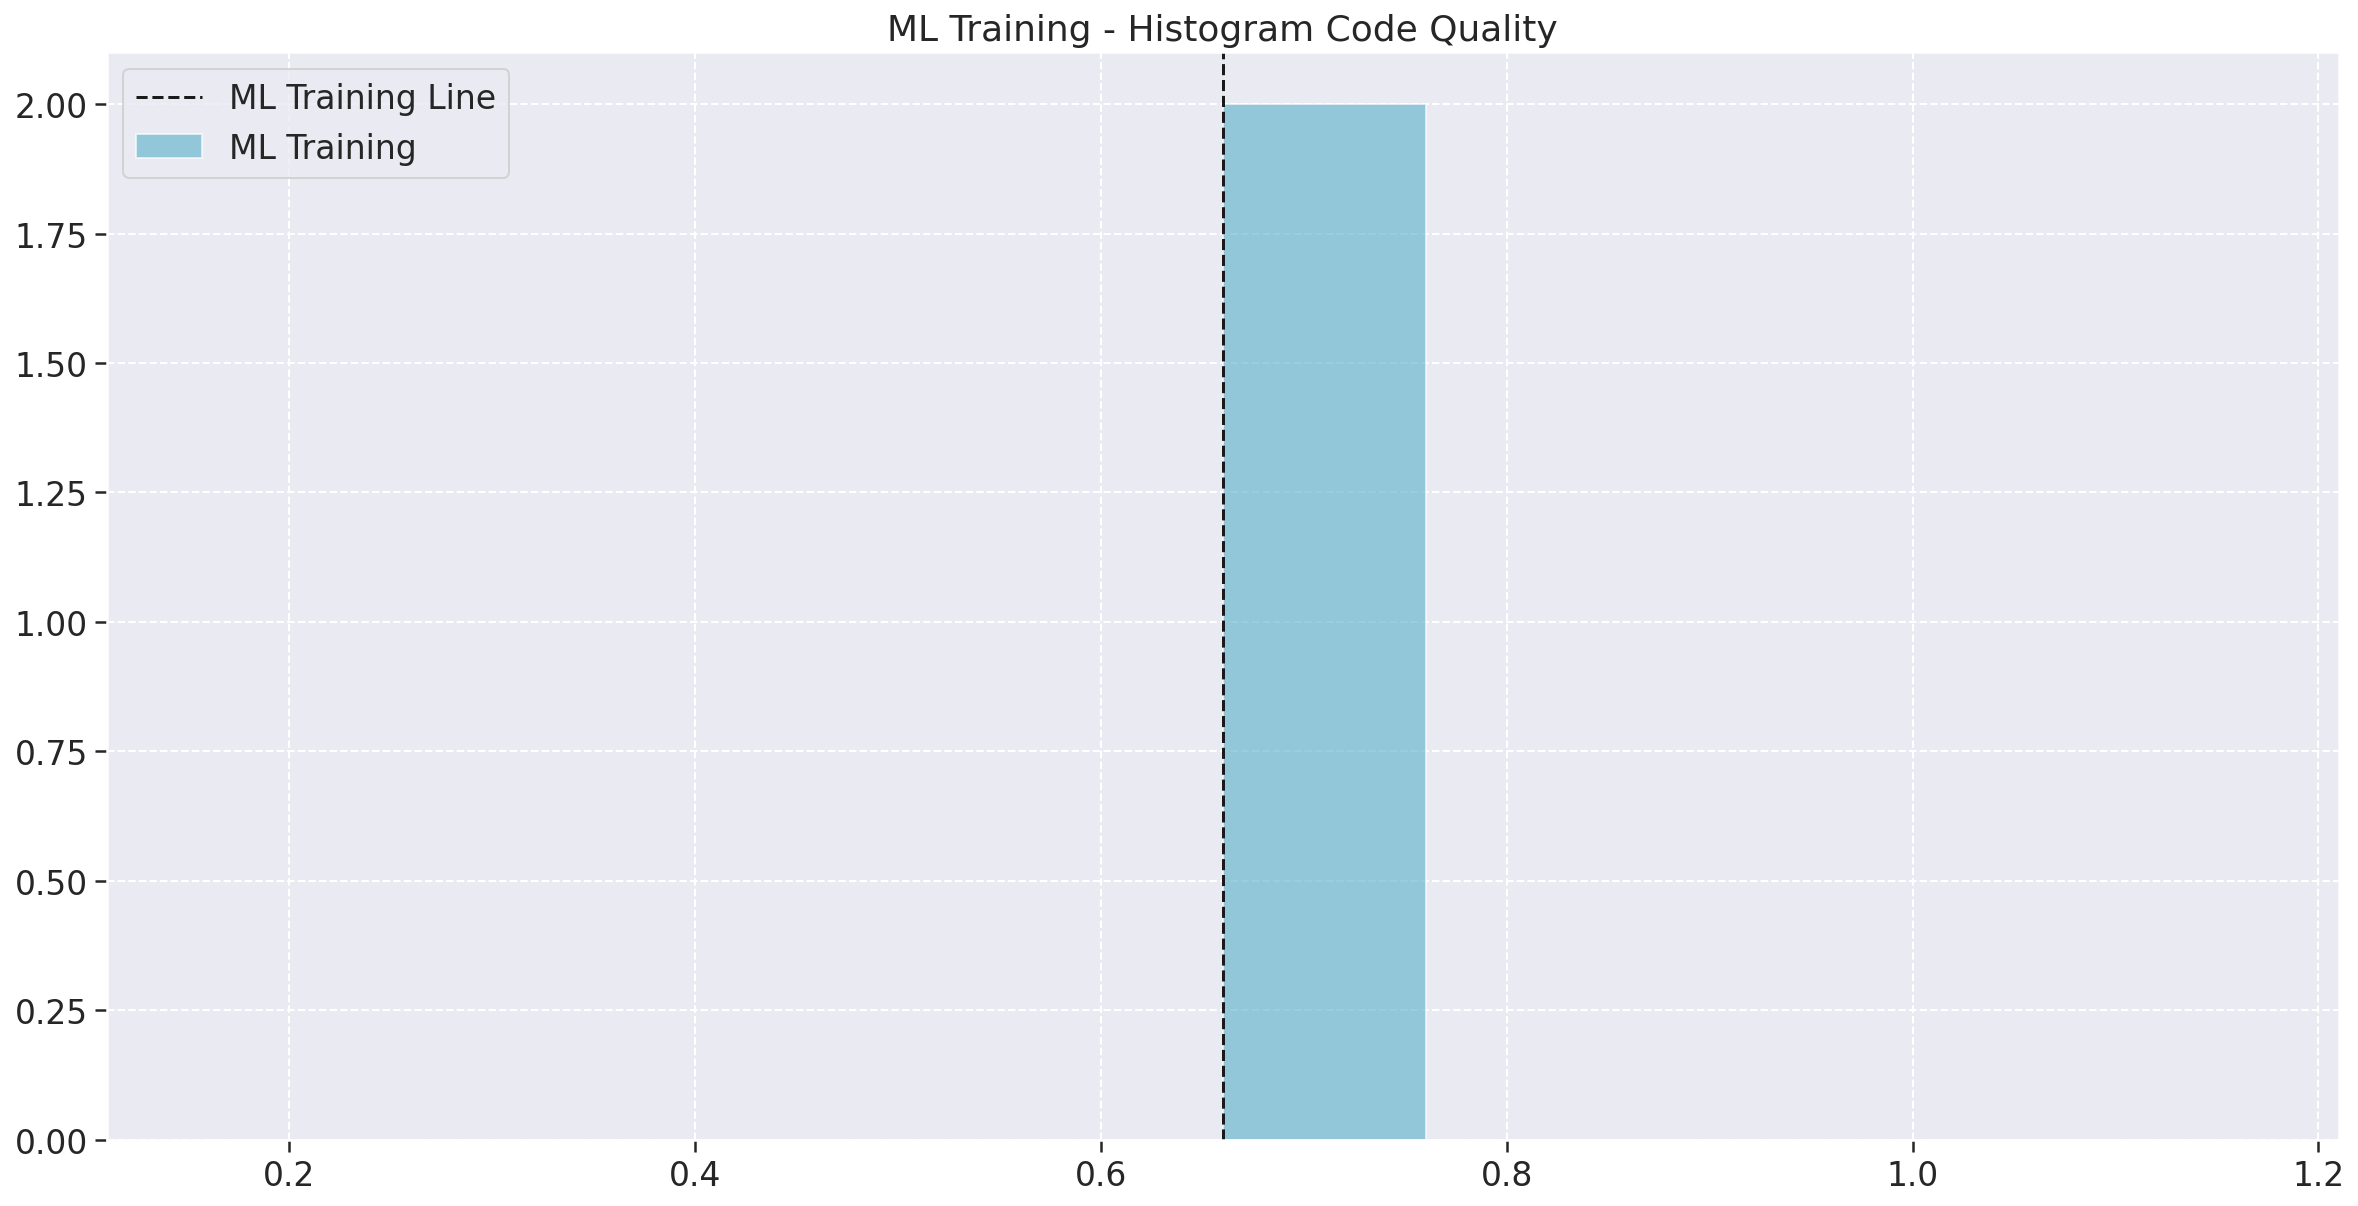

In [78]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Histogram Code Quality')
plt.hist(mltraining_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='ML Training')
plt.axvline(mltraining_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='ML Training Line')

plt.legend(loc='upper left')

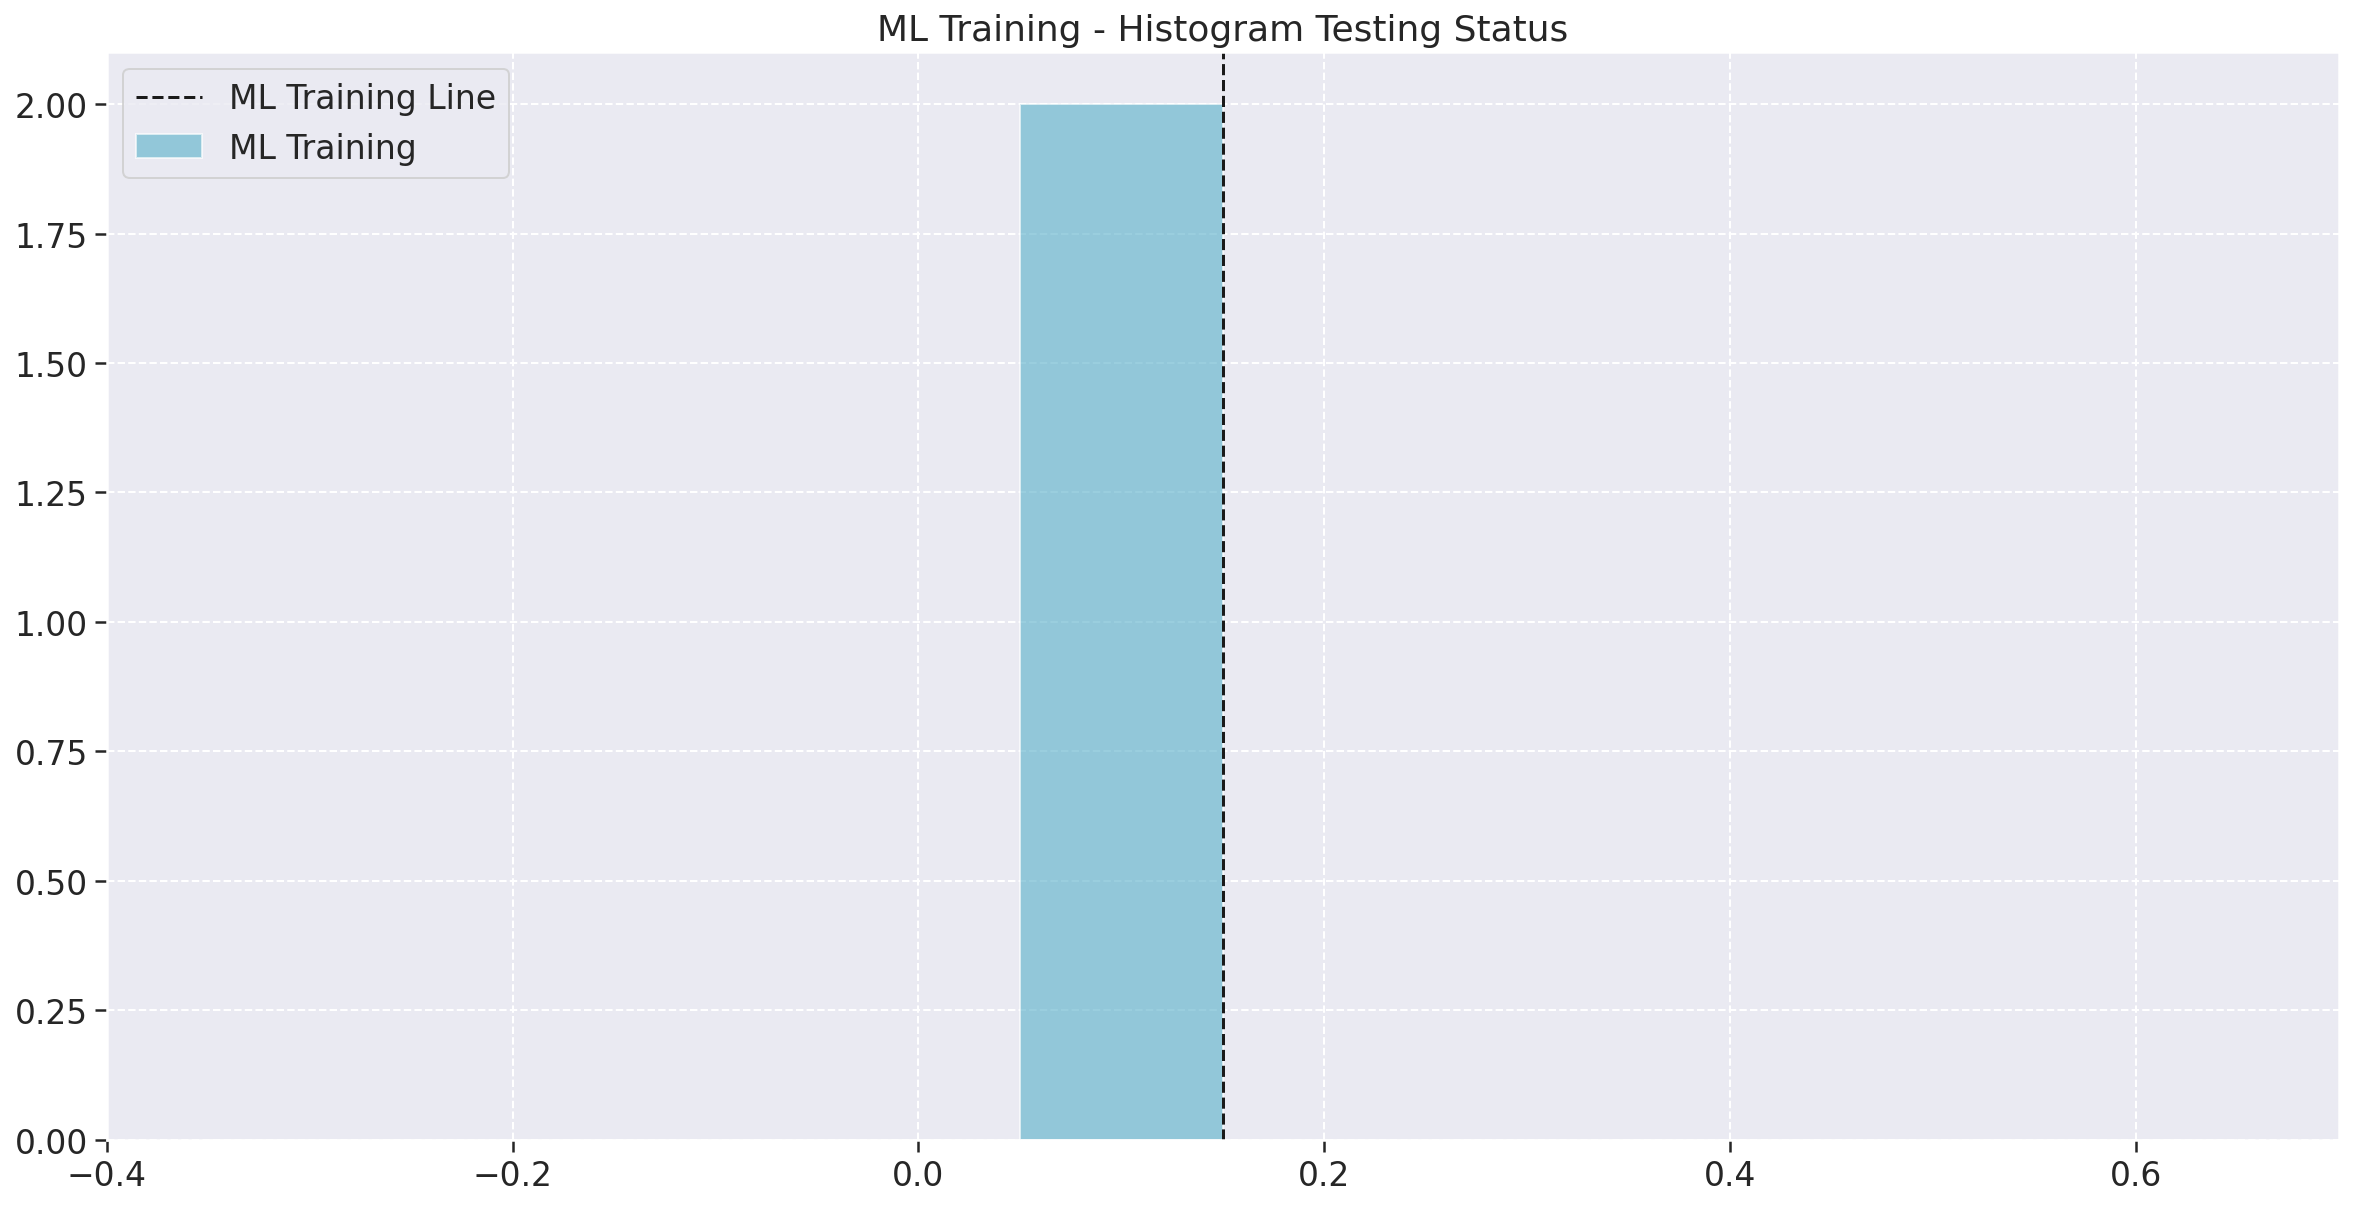

In [79]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Histogram Testing Status')
plt.hist(mltraining_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='ML Training')
plt.axvline(mltraining_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='ML Training Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f967c4b20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f967cc280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f967c4790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f967cc9a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f967ccd30>],
 'means': []}

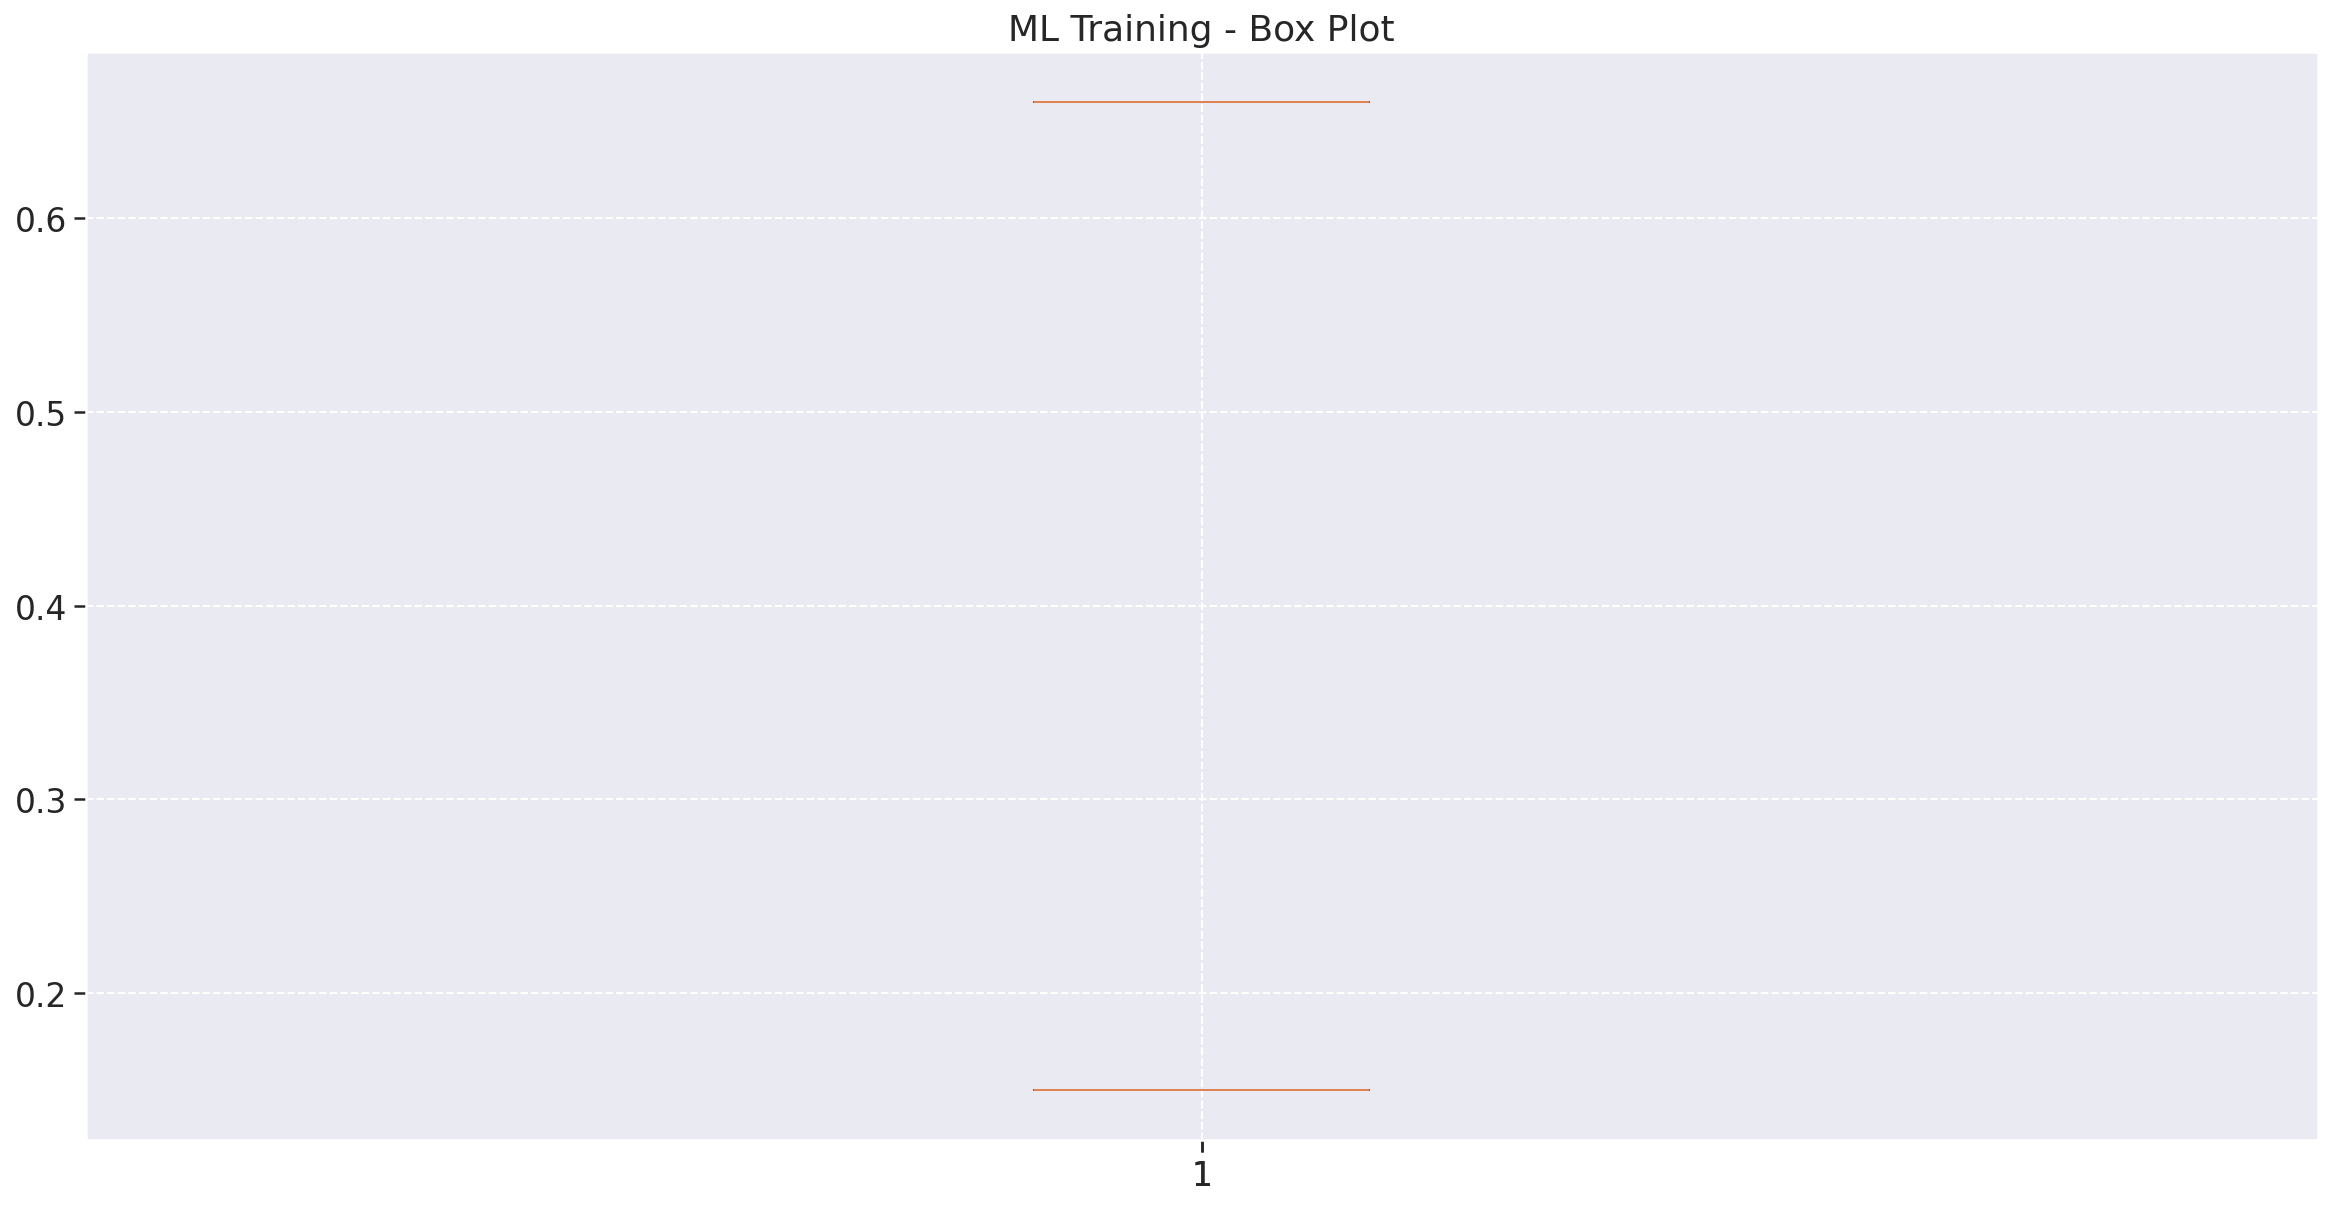

In [80]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Box Plot')
plt.boxplot(mltraining_metrics['code_quality'])
plt.boxplot(mltraining_metrics['testing_status'])

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Text(0.5, 1.0, 'Matriz de Correção - ML Training')

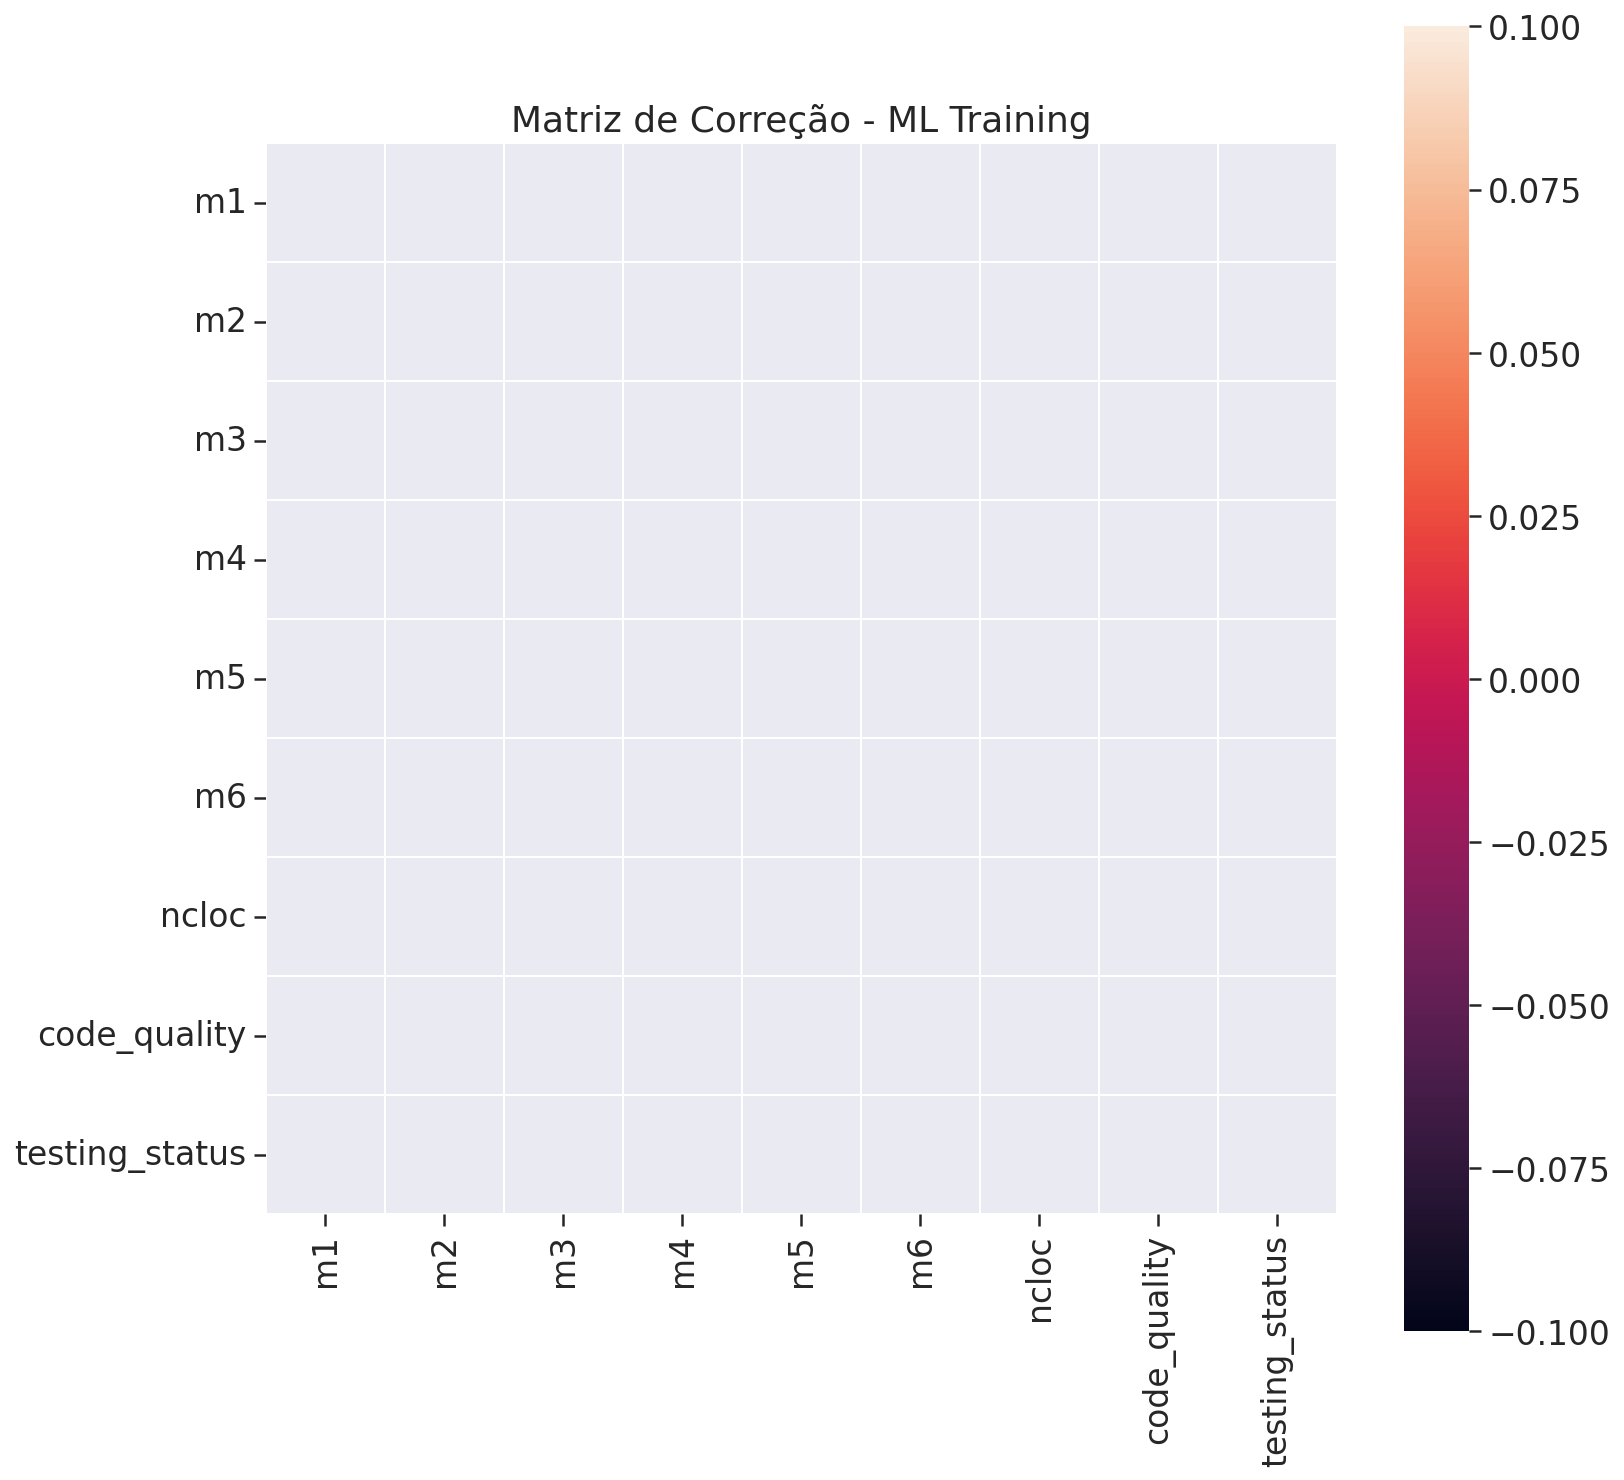

In [81]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(mltraining_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - ML Training')

#### Analysis - ML Training

Explain here about ml training

### Front End

In [82]:
frontend_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.500000,0.052632,0.921053,1.0,0,0.578947,Frontend,02-11-2021-23-30,2460,0.486316,0.555263
1,0.500000,0.200000,1.000000,1.0,0,0.500000,Frontend,07-10-2021-11-50,125,0.561000,0.500000
2,0.600000,0.200000,1.000000,1.0,0,0.200000,Frontend,15-09-2021-00-47,58,0.594000,0.290000
3,0.481481,0.111111,0.925926,1.0,0,0.629630,Frontend,27-10-2021-17-37,1334,0.501111,0.590741


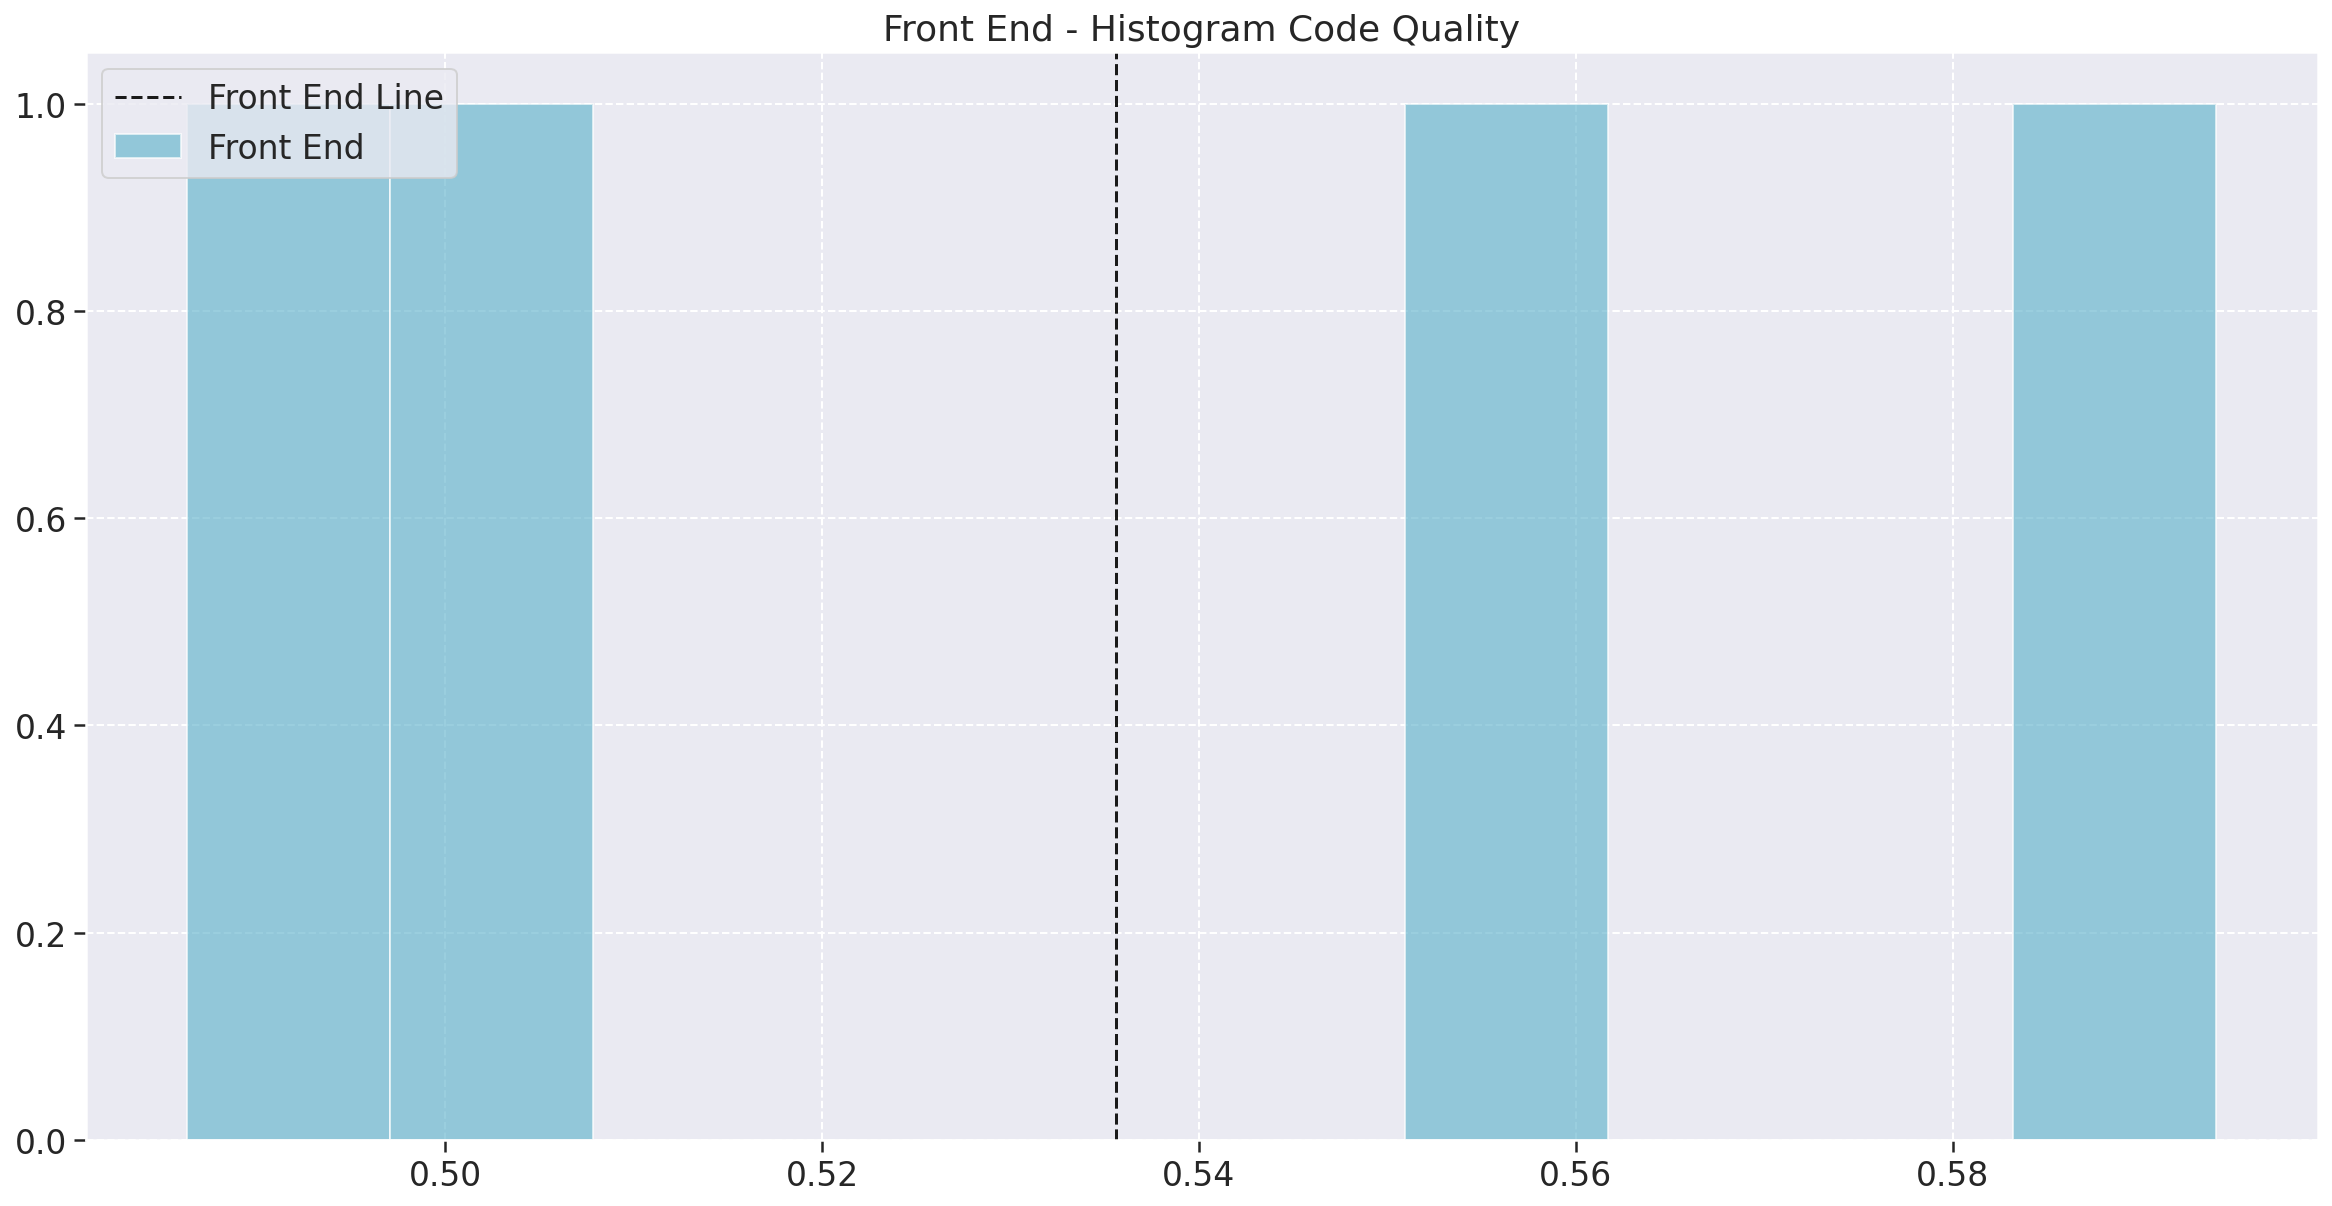

In [83]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Histogram Code Quality')
plt.hist(frontend_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Front End')
plt.axvline(frontend_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Front End Line')

plt.legend(loc='upper left')

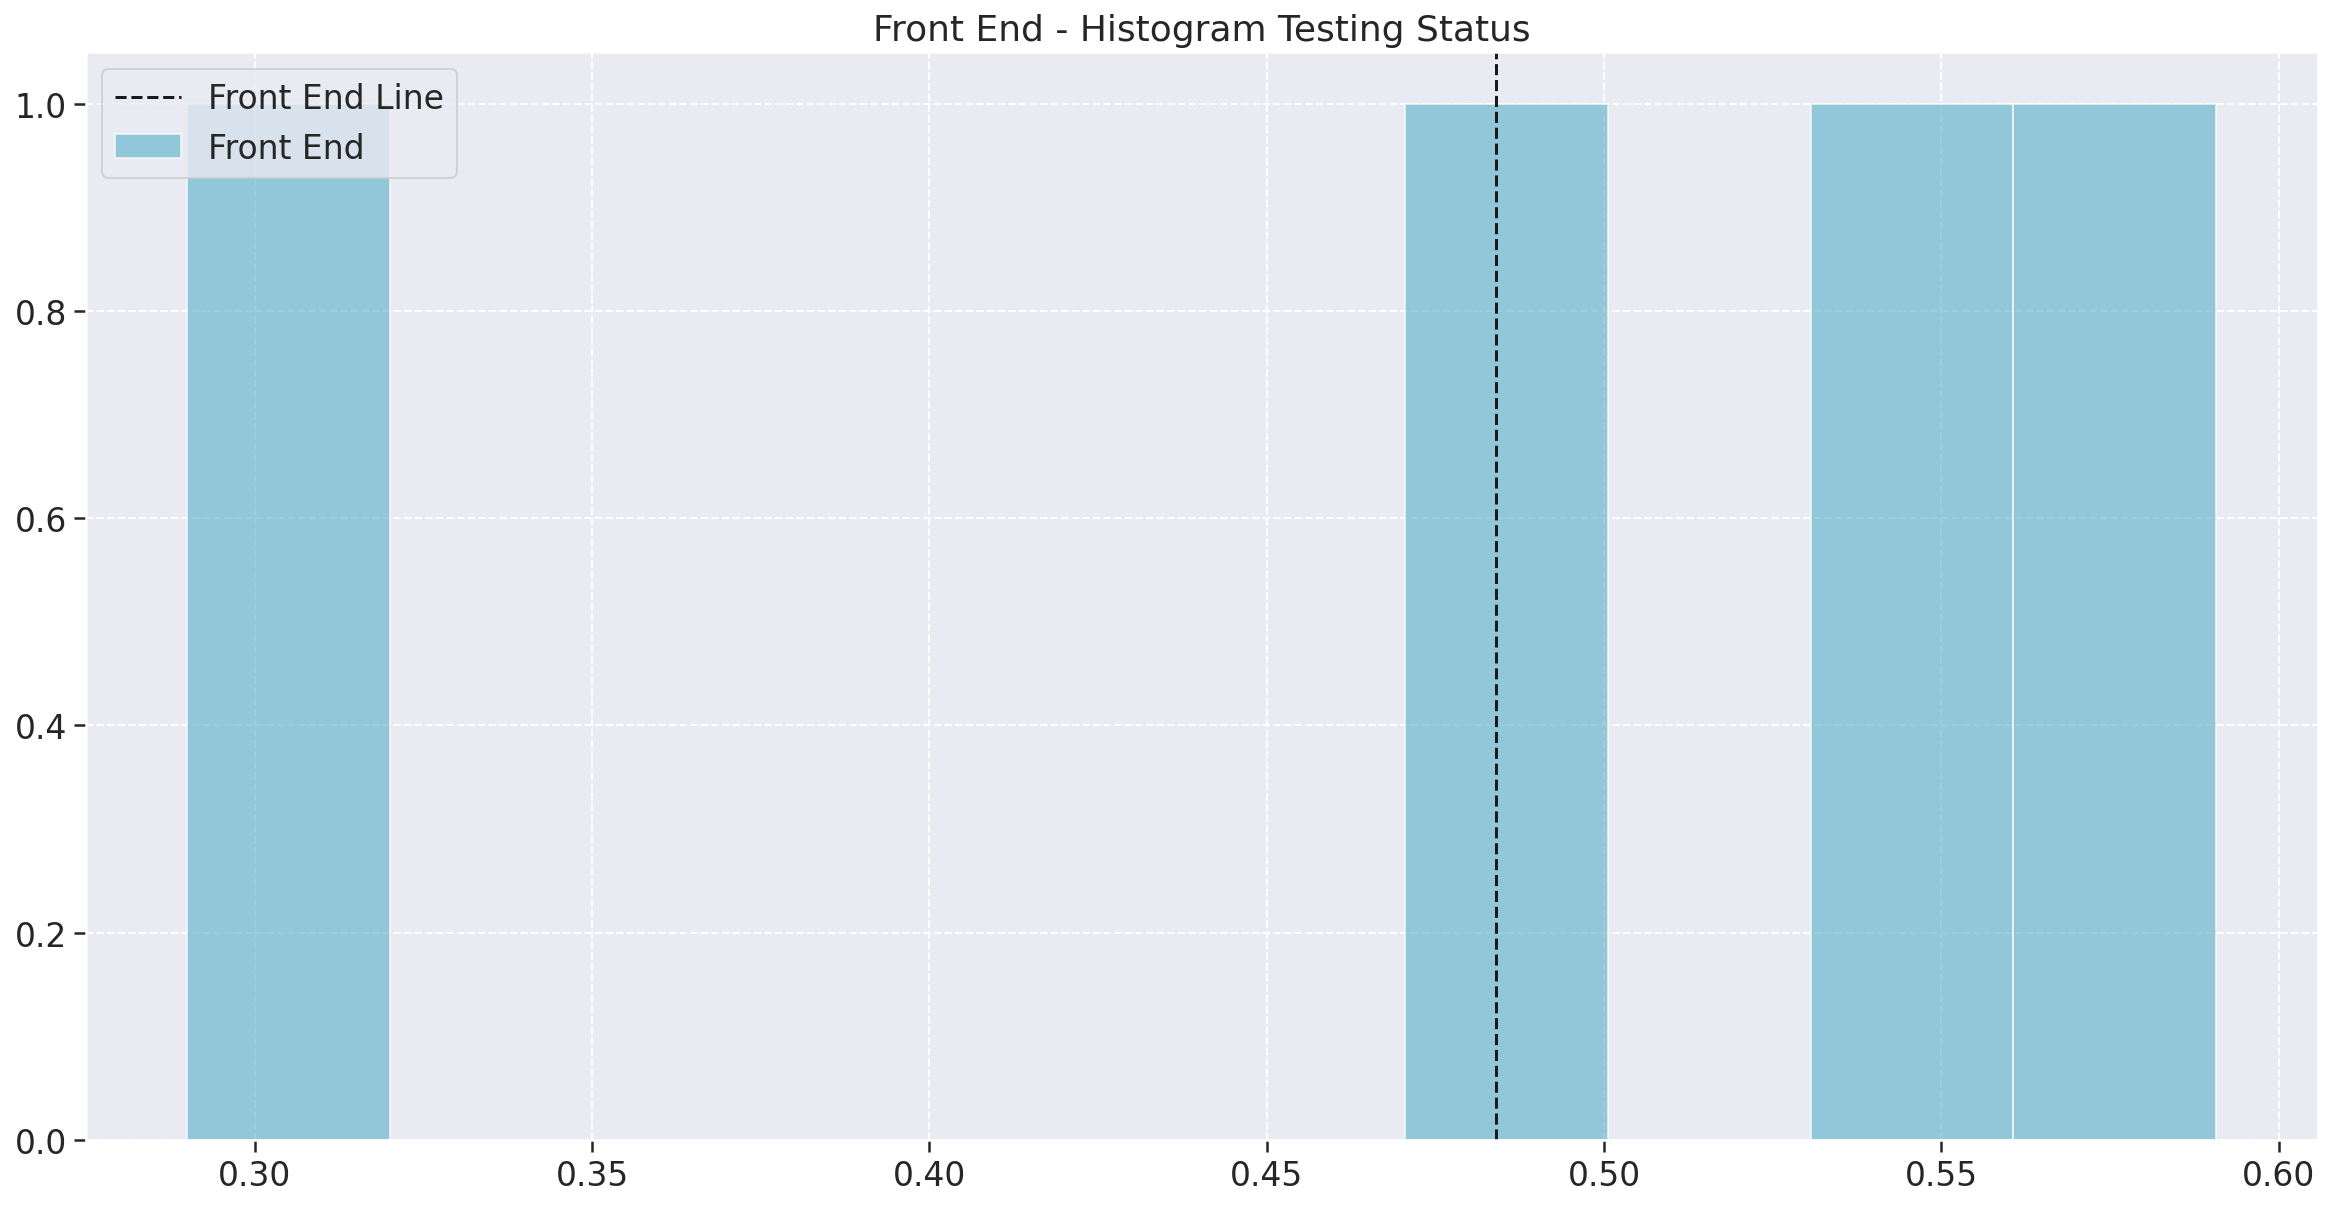

In [84]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Histogram Testing Status')
plt.hist(frontend_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Front End')
plt.axvline(frontend_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Front End Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f96539580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f96539ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f965391f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f96541400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f96541790>],
 'means': []}

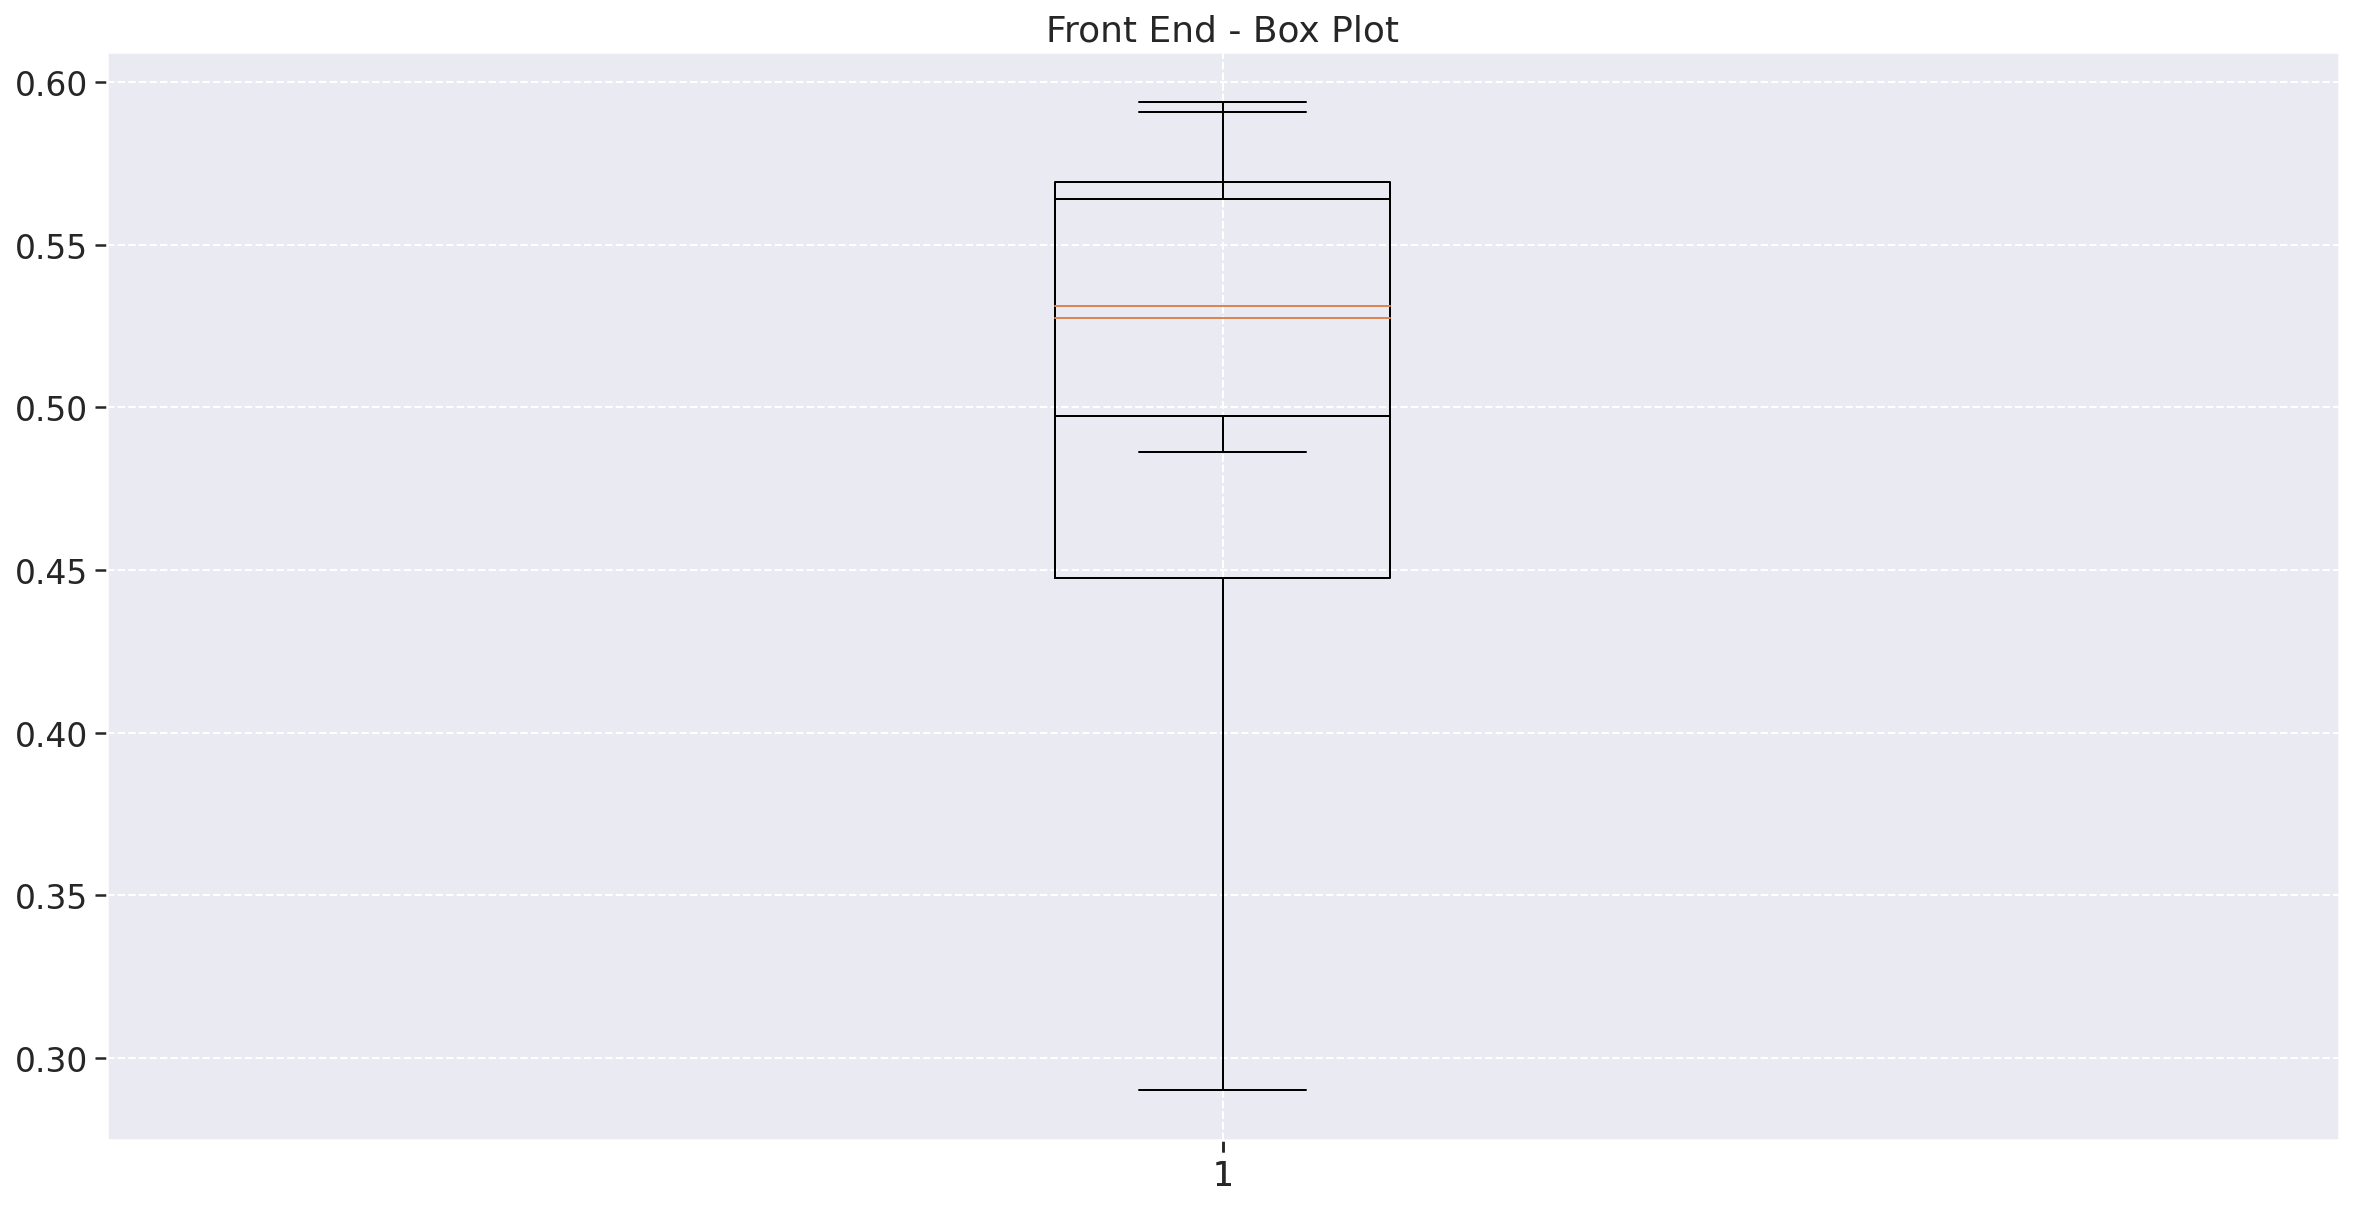

In [85]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Box Plot')
plt.boxplot(frontend_metrics['code_quality'])
plt.boxplot(frontend_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Front End')

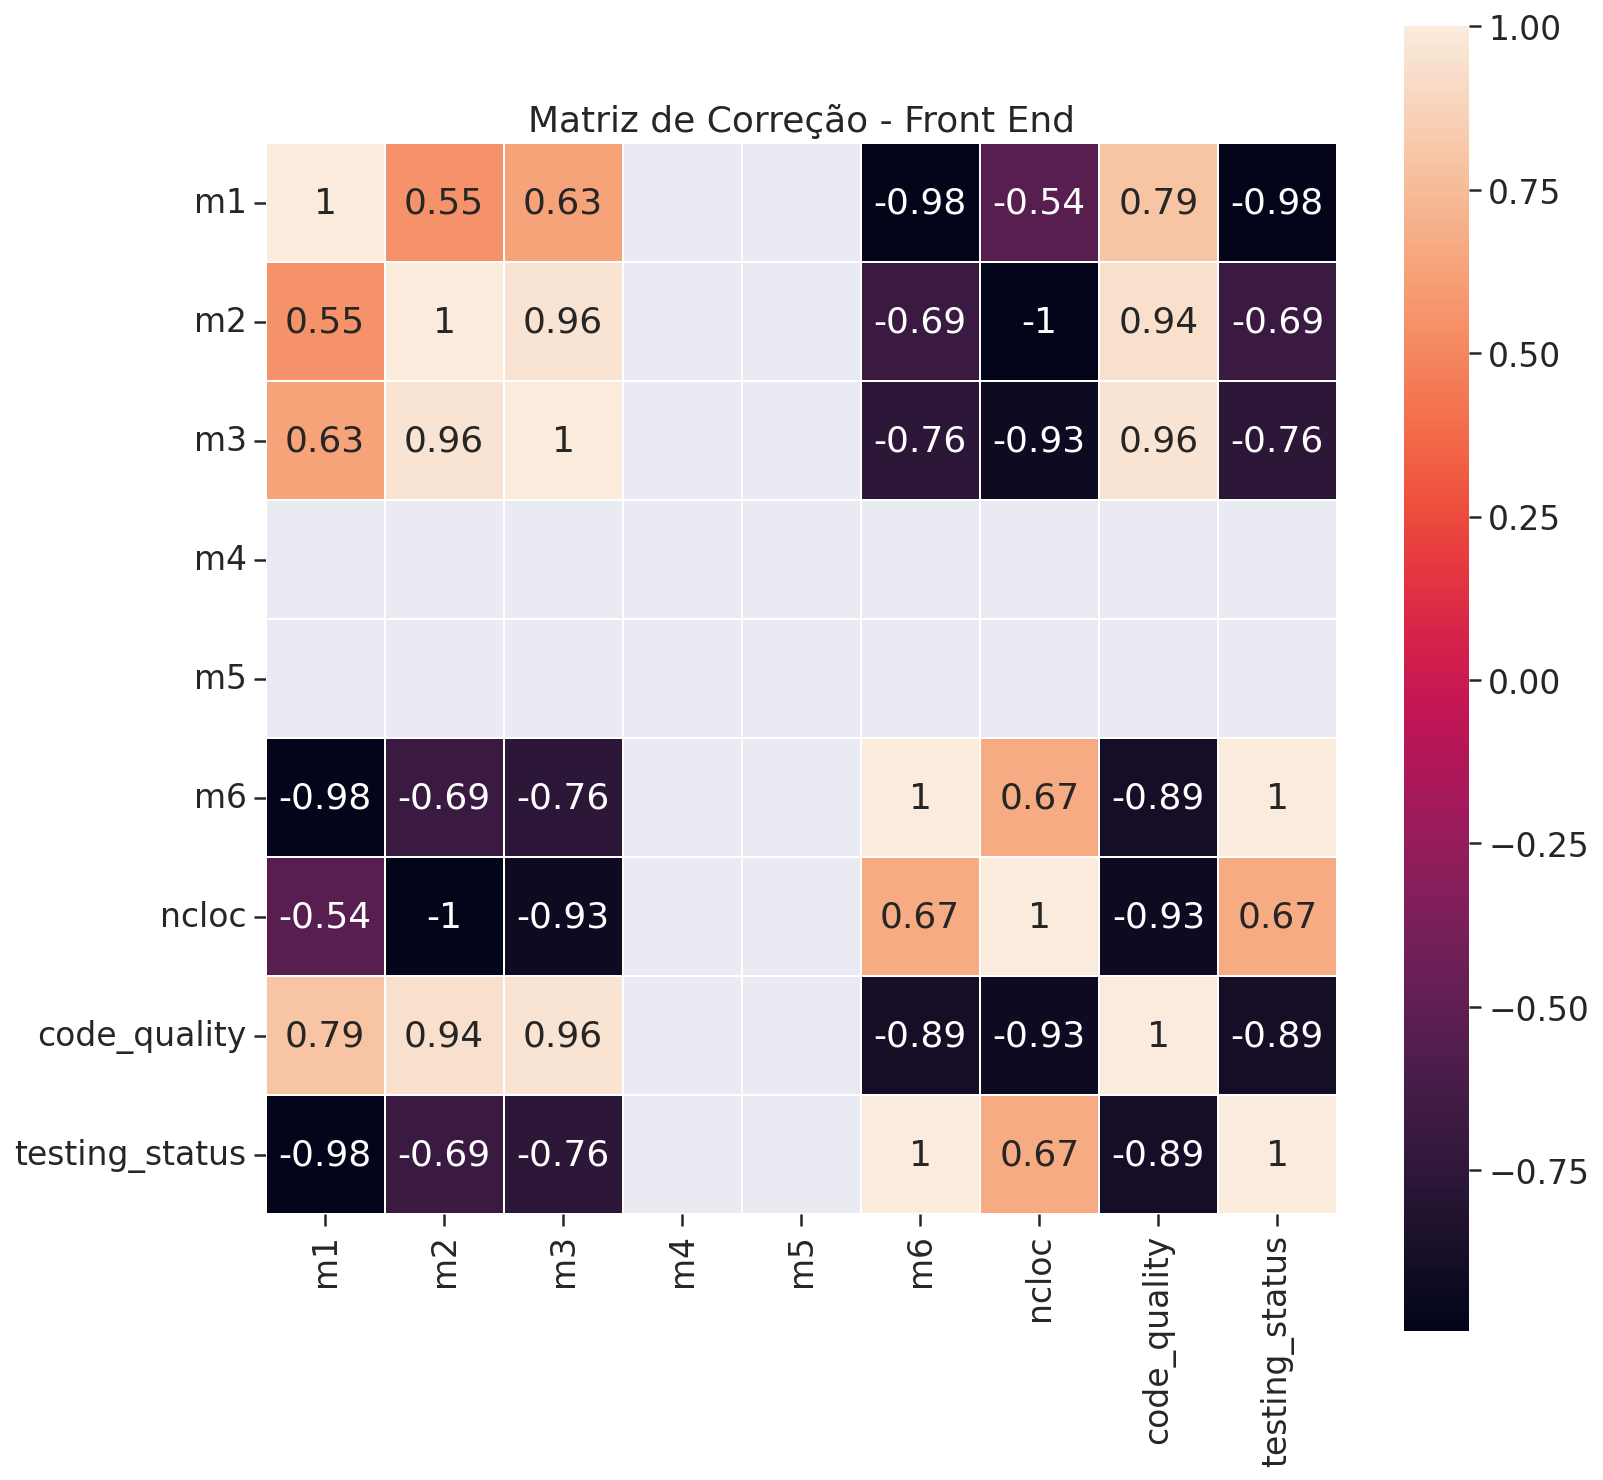

In [86]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(frontend_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Front End')

#### Analysis - Front End

Explain here

### Maintainability and Reliabity

In [87]:
metrics_df = pd.concat([scraper_metrics, documentsapi_metrics, mltraining_metrics, frontend_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [88]:
def create_descriptive_df(df):
    maintainability_df = df['maintainability']
    reliability_df = df['Reliability']
    
    descriptive_df = pd.DataFrame(
                columns=['Maintainability', 'Reliability'])
    
    descriptive_df.loc['mean'] = [maintainability_df.mean() * 100, reliability_df.mean()* 100]
    descriptive_df.loc['mode'] = [maintainability_df.mode().max()* 100, reliability_df.mode().max()* 100]
    descriptive_df.loc['25%'] = [maintainability_df.quantile(0.25)* 100, reliability_df.quantile(0.25)* 100]
    descriptive_df.loc['50%'] = [maintainability_df.quantile(0.50)* 100, reliability_df.quantile(0.50)* 100]
    descriptive_df.loc['75%'] = [maintainability_df.quantile(0.75)* 100, reliability_df.quantile(0.75)* 100]
    descriptive_df.loc['standart_deviation'] = [maintainability_df.std()* 100, reliability_df.std()* 100]
    descriptive_df.loc['variance'] = [maintainability_df.var()* 100, reliability_df.var()* 100]
    descriptive_df.loc['min'] = [maintainability_df.min()* 100, reliability_df.min()* 100]
    descriptive_df.loc['max'] = [maintainability_df.max()* 100, reliability_df.max()* 100]
    
    
    return descriptive_df

In [89]:
descriptive_df = create_descriptive_df(metrics_df)

In [90]:
descriptive_df

,Maintainability,Reliability
mean,25.825458,21.000706
mode,33.000000,7.500000
25%,21.855263,12.590909
50%,25.055556,25.921053
75%,28.275000,27.276182
standart_deviation,3.959372,8.675488
variance,0.156766,0.752641
min,21.450000,7.500000
max,33.000000,29.537037


Text(0.5, 1.0, 'Matriz de Correção - Maintainability e Reliability')

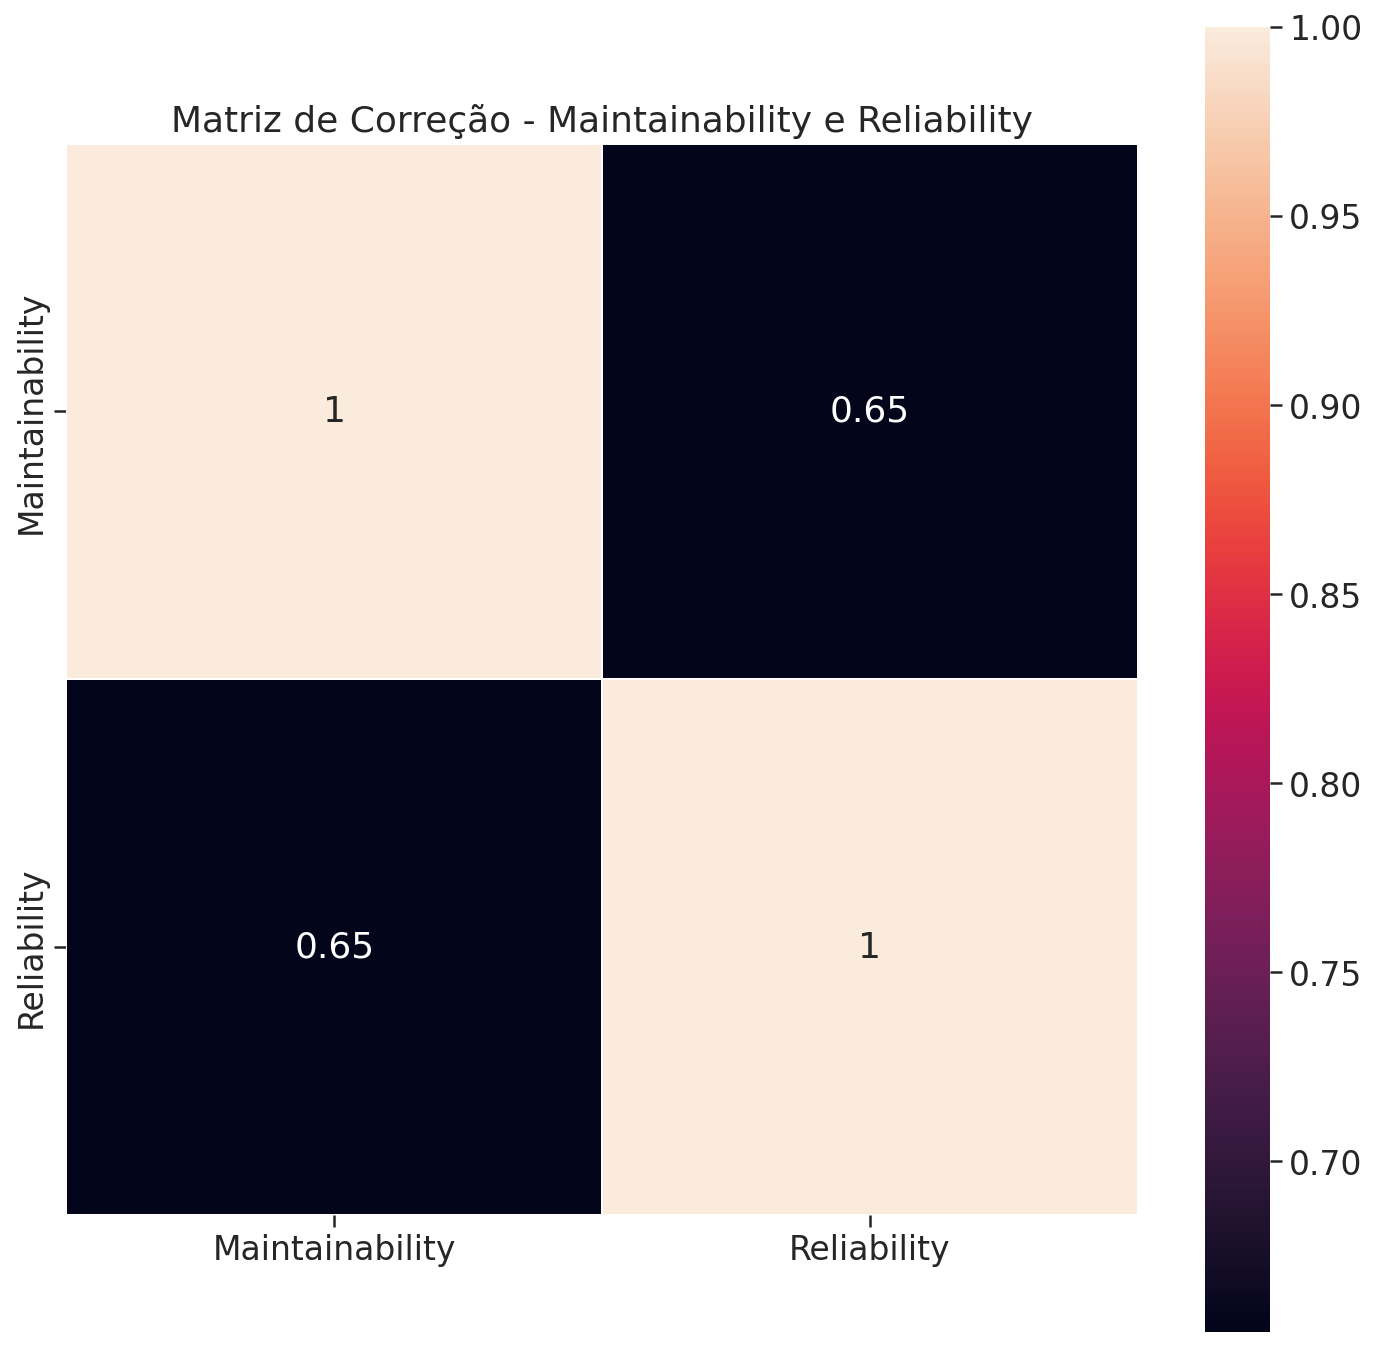

In [91]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(descriptive_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Maintainability e Reliability')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f962e9b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f962f82e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f9635b610>,
 'medians': [<matplotlib.lines.Line2D at 0x7f3f962f8a00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f962f8d90>,
 'means': []}

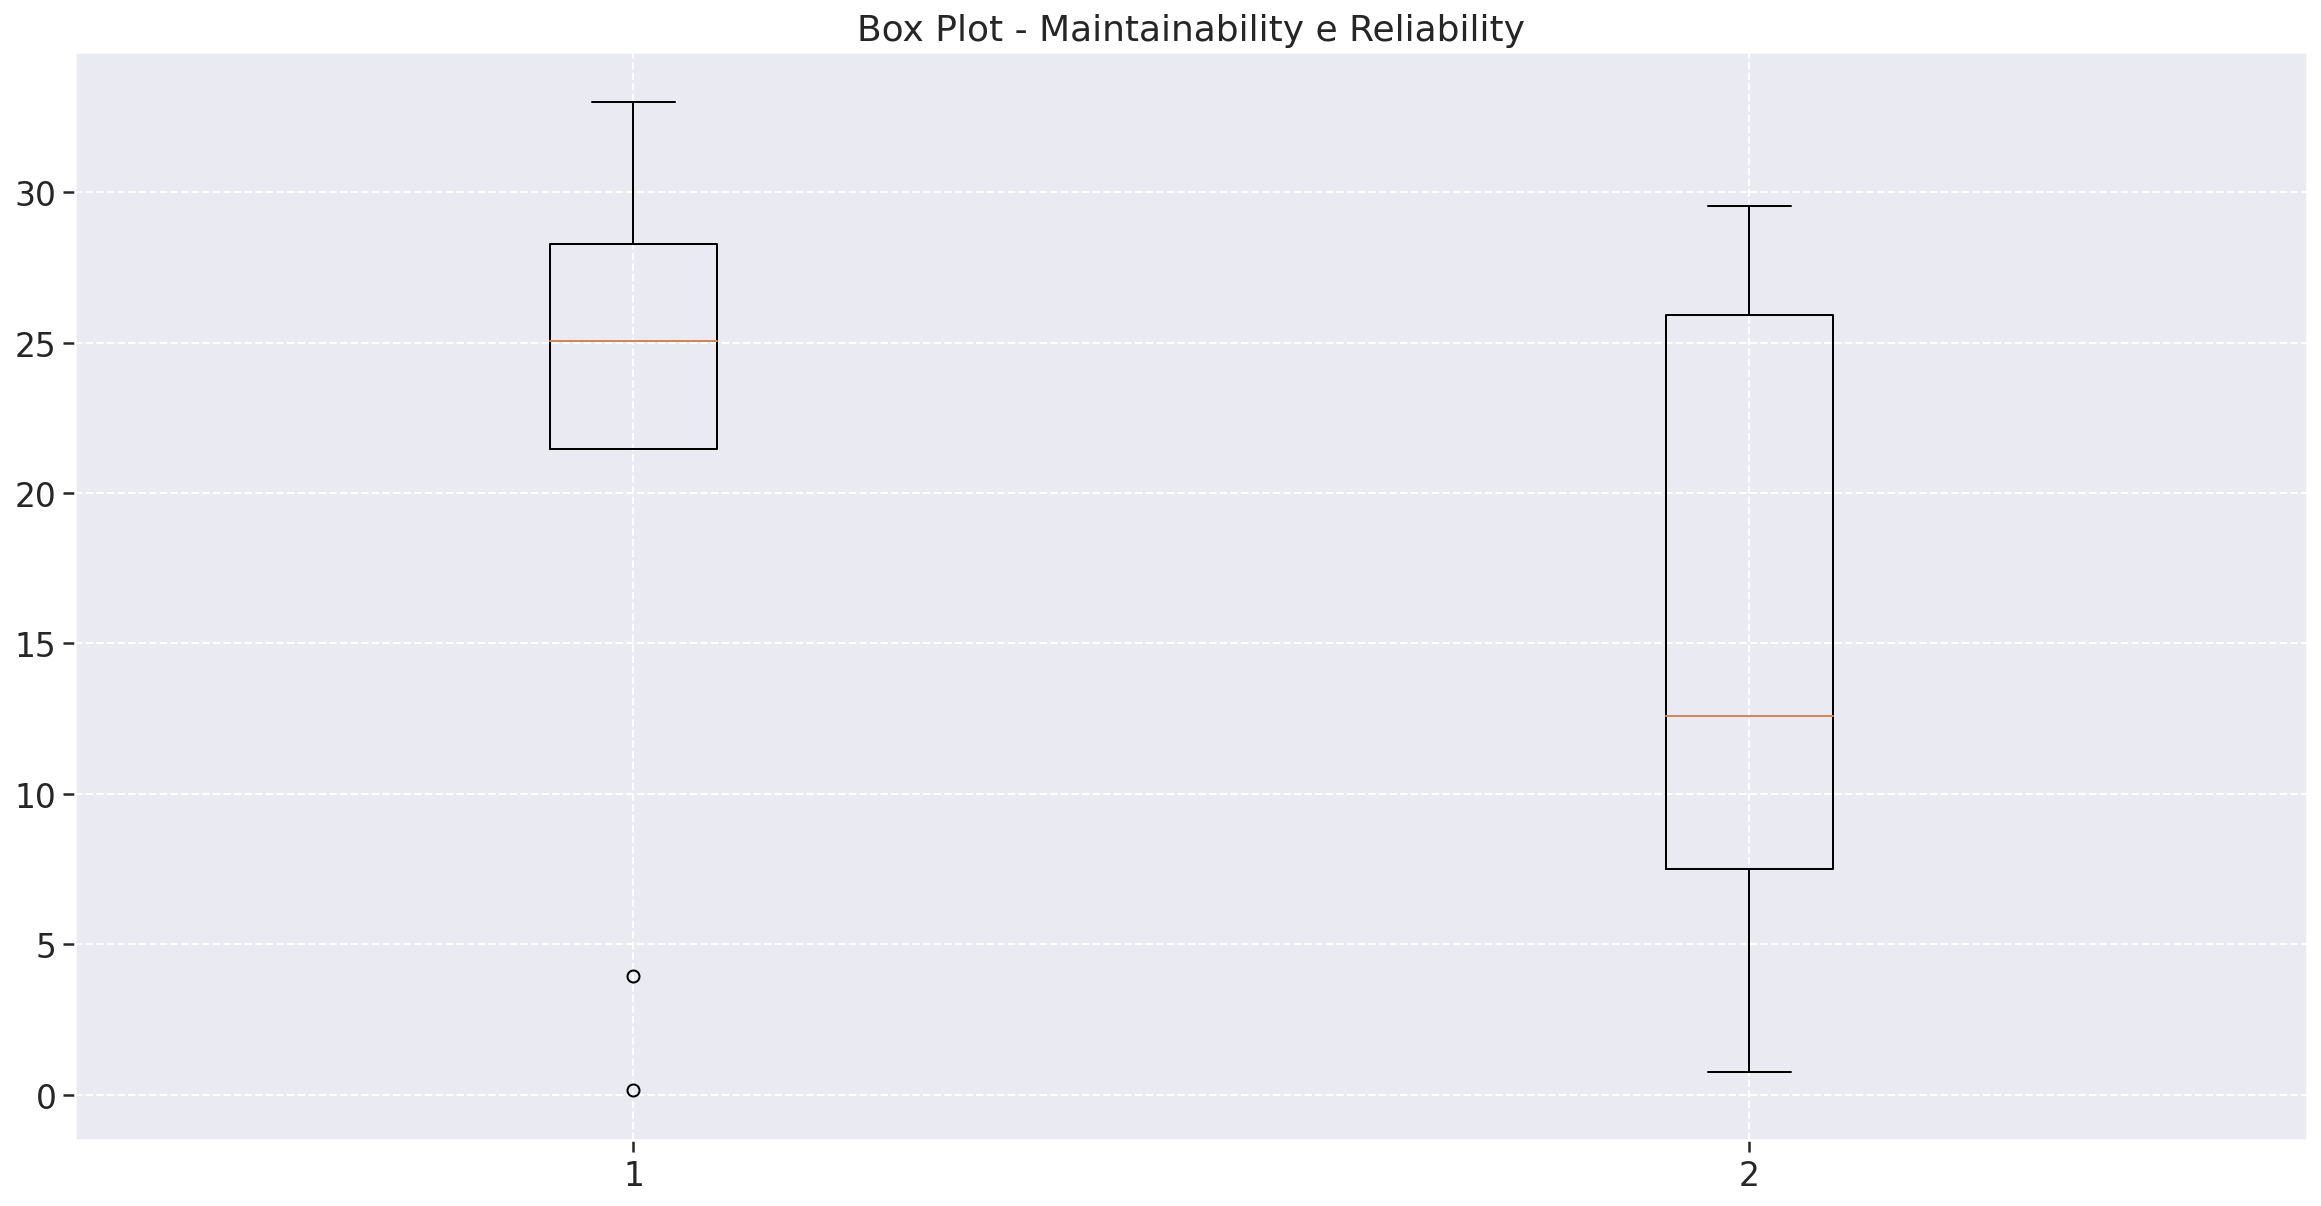

In [92]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability e Reliability')
plt.boxplot(descriptive_df)

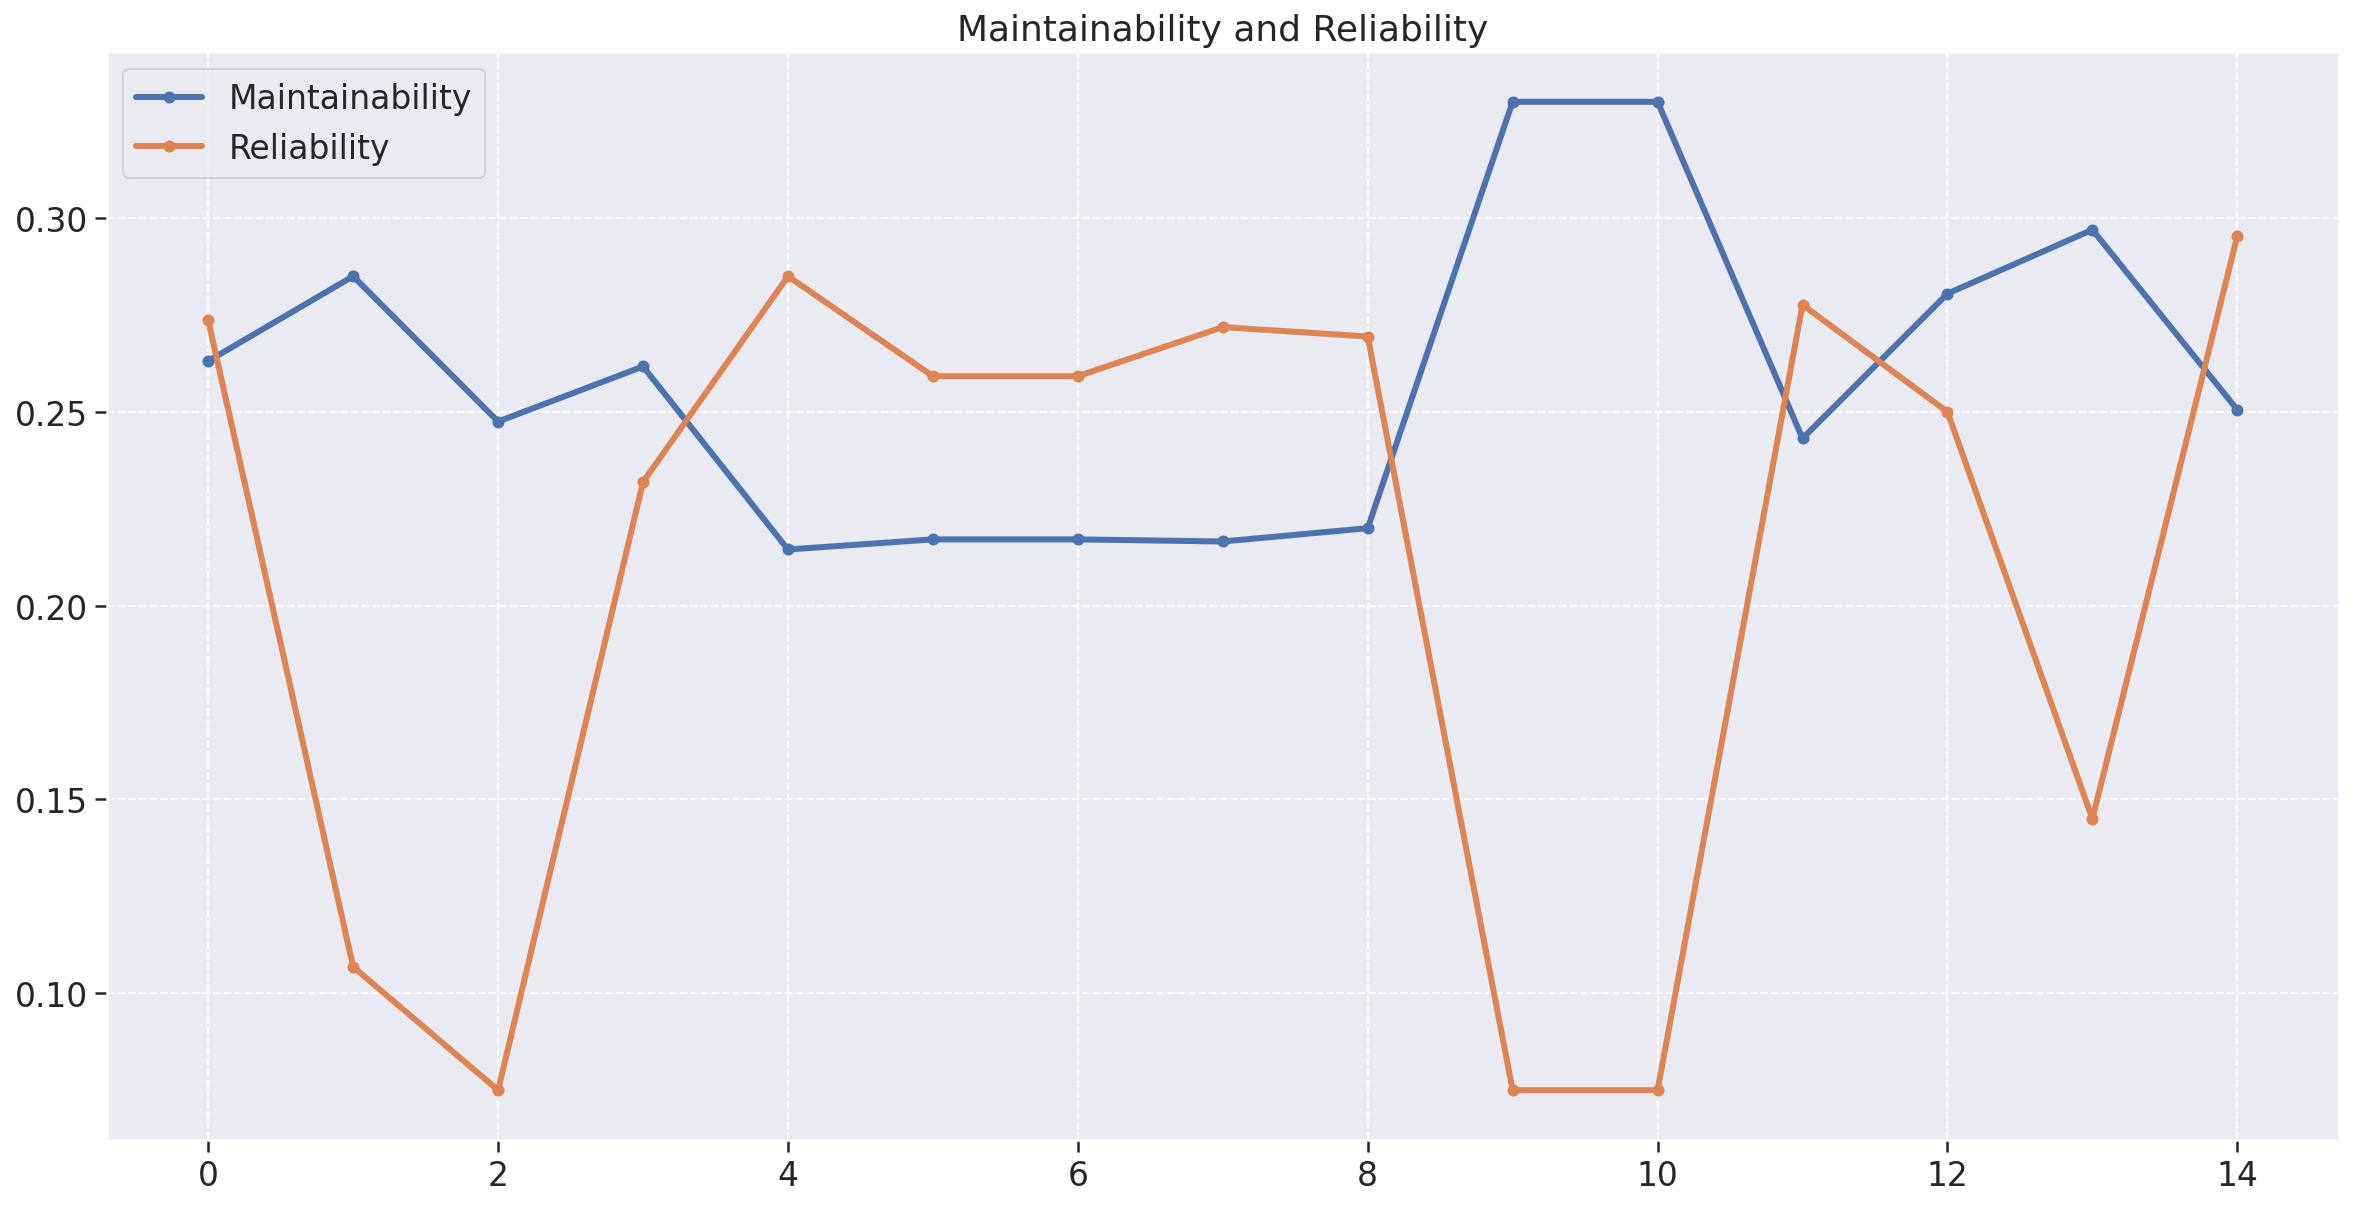

In [93]:
fig = plt.figure(figsize=(20, 10))

plt.title('Maintainability and Reliability')
plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5, label='Maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')

#plt.ylim(.45,.7)
plt.legend(loc='upper left')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f96264df0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f961f1550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f96264a60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f961f1c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f961fc040>],
 'means': []}

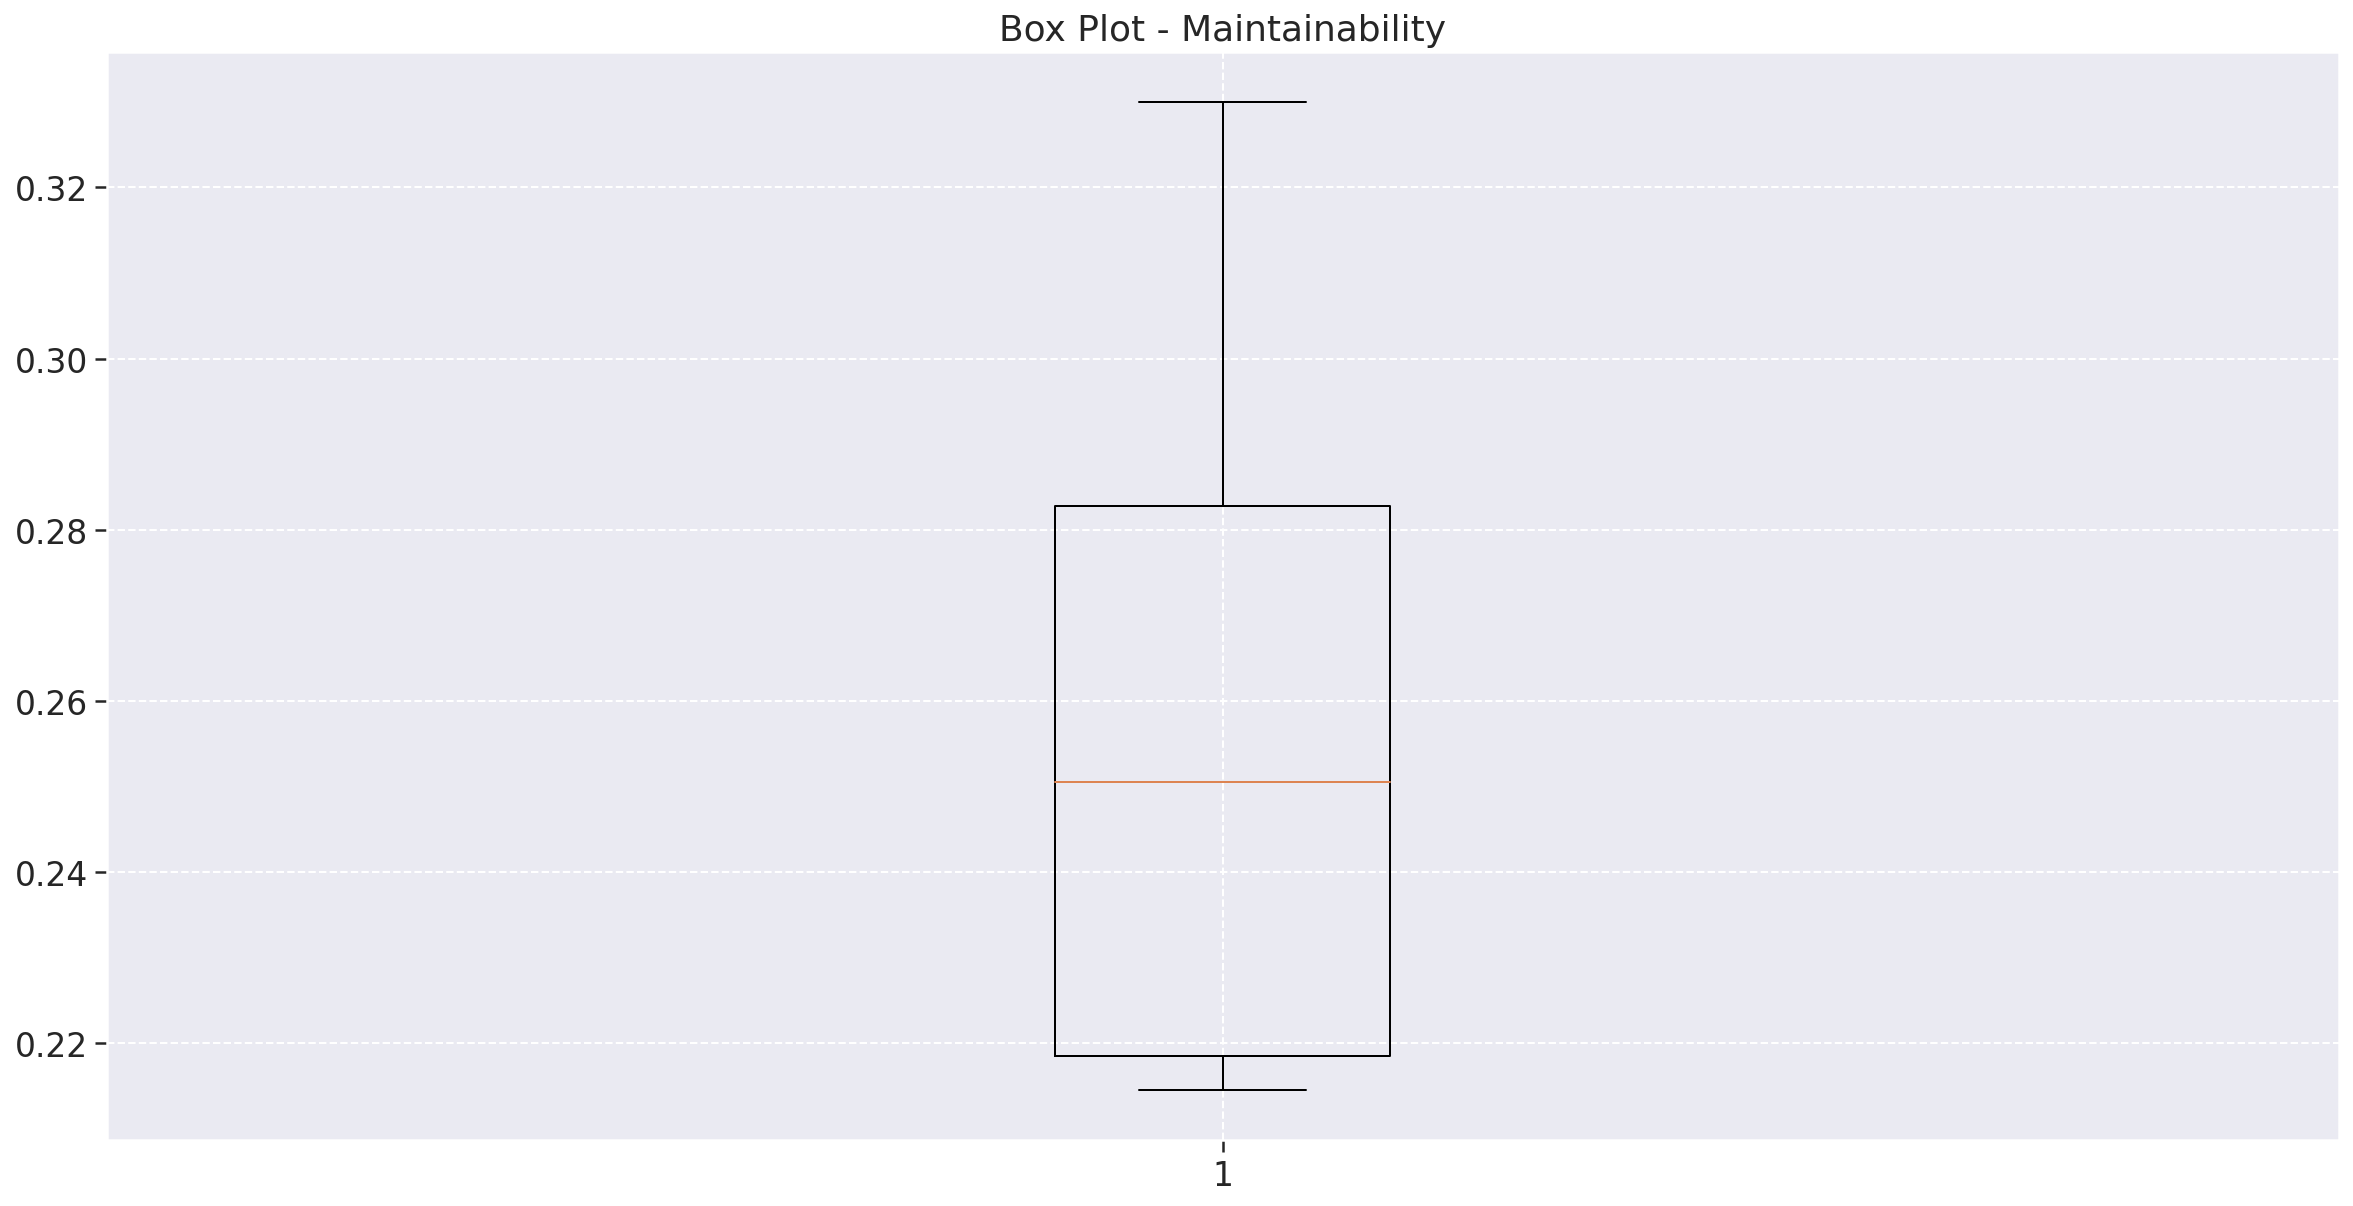

In [94]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability')
plt.boxplot(metrics_df['maintainability'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f961cf760>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f961cfe80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f961cf3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f961da5e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f961da970>],
 'means': []}

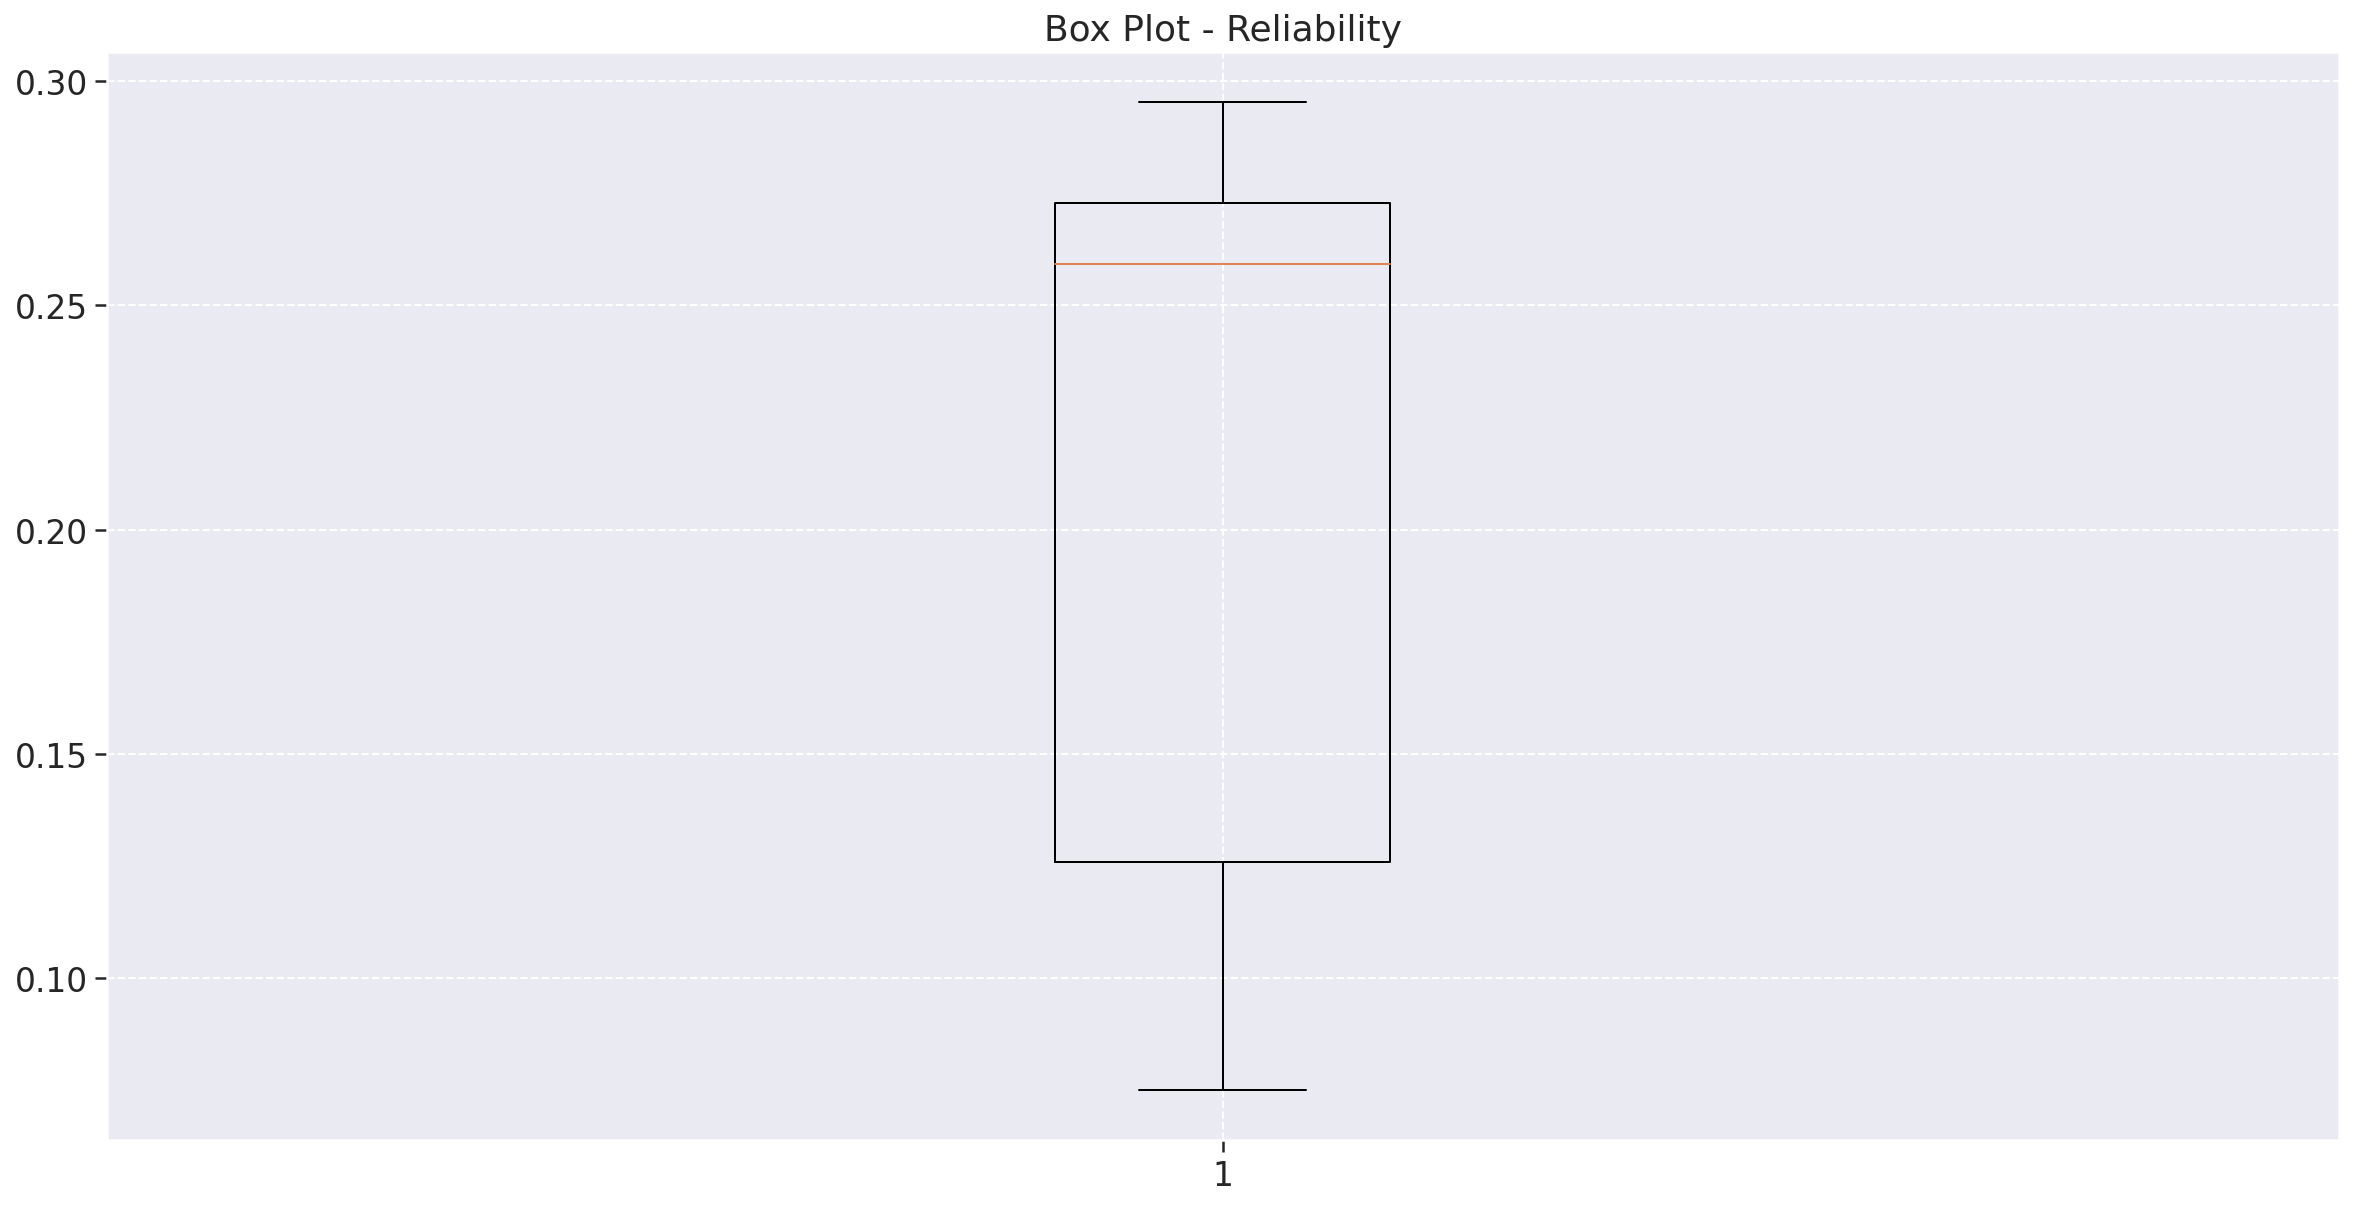

In [95]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Reliability')
plt.boxplot(metrics_df['Reliability'])

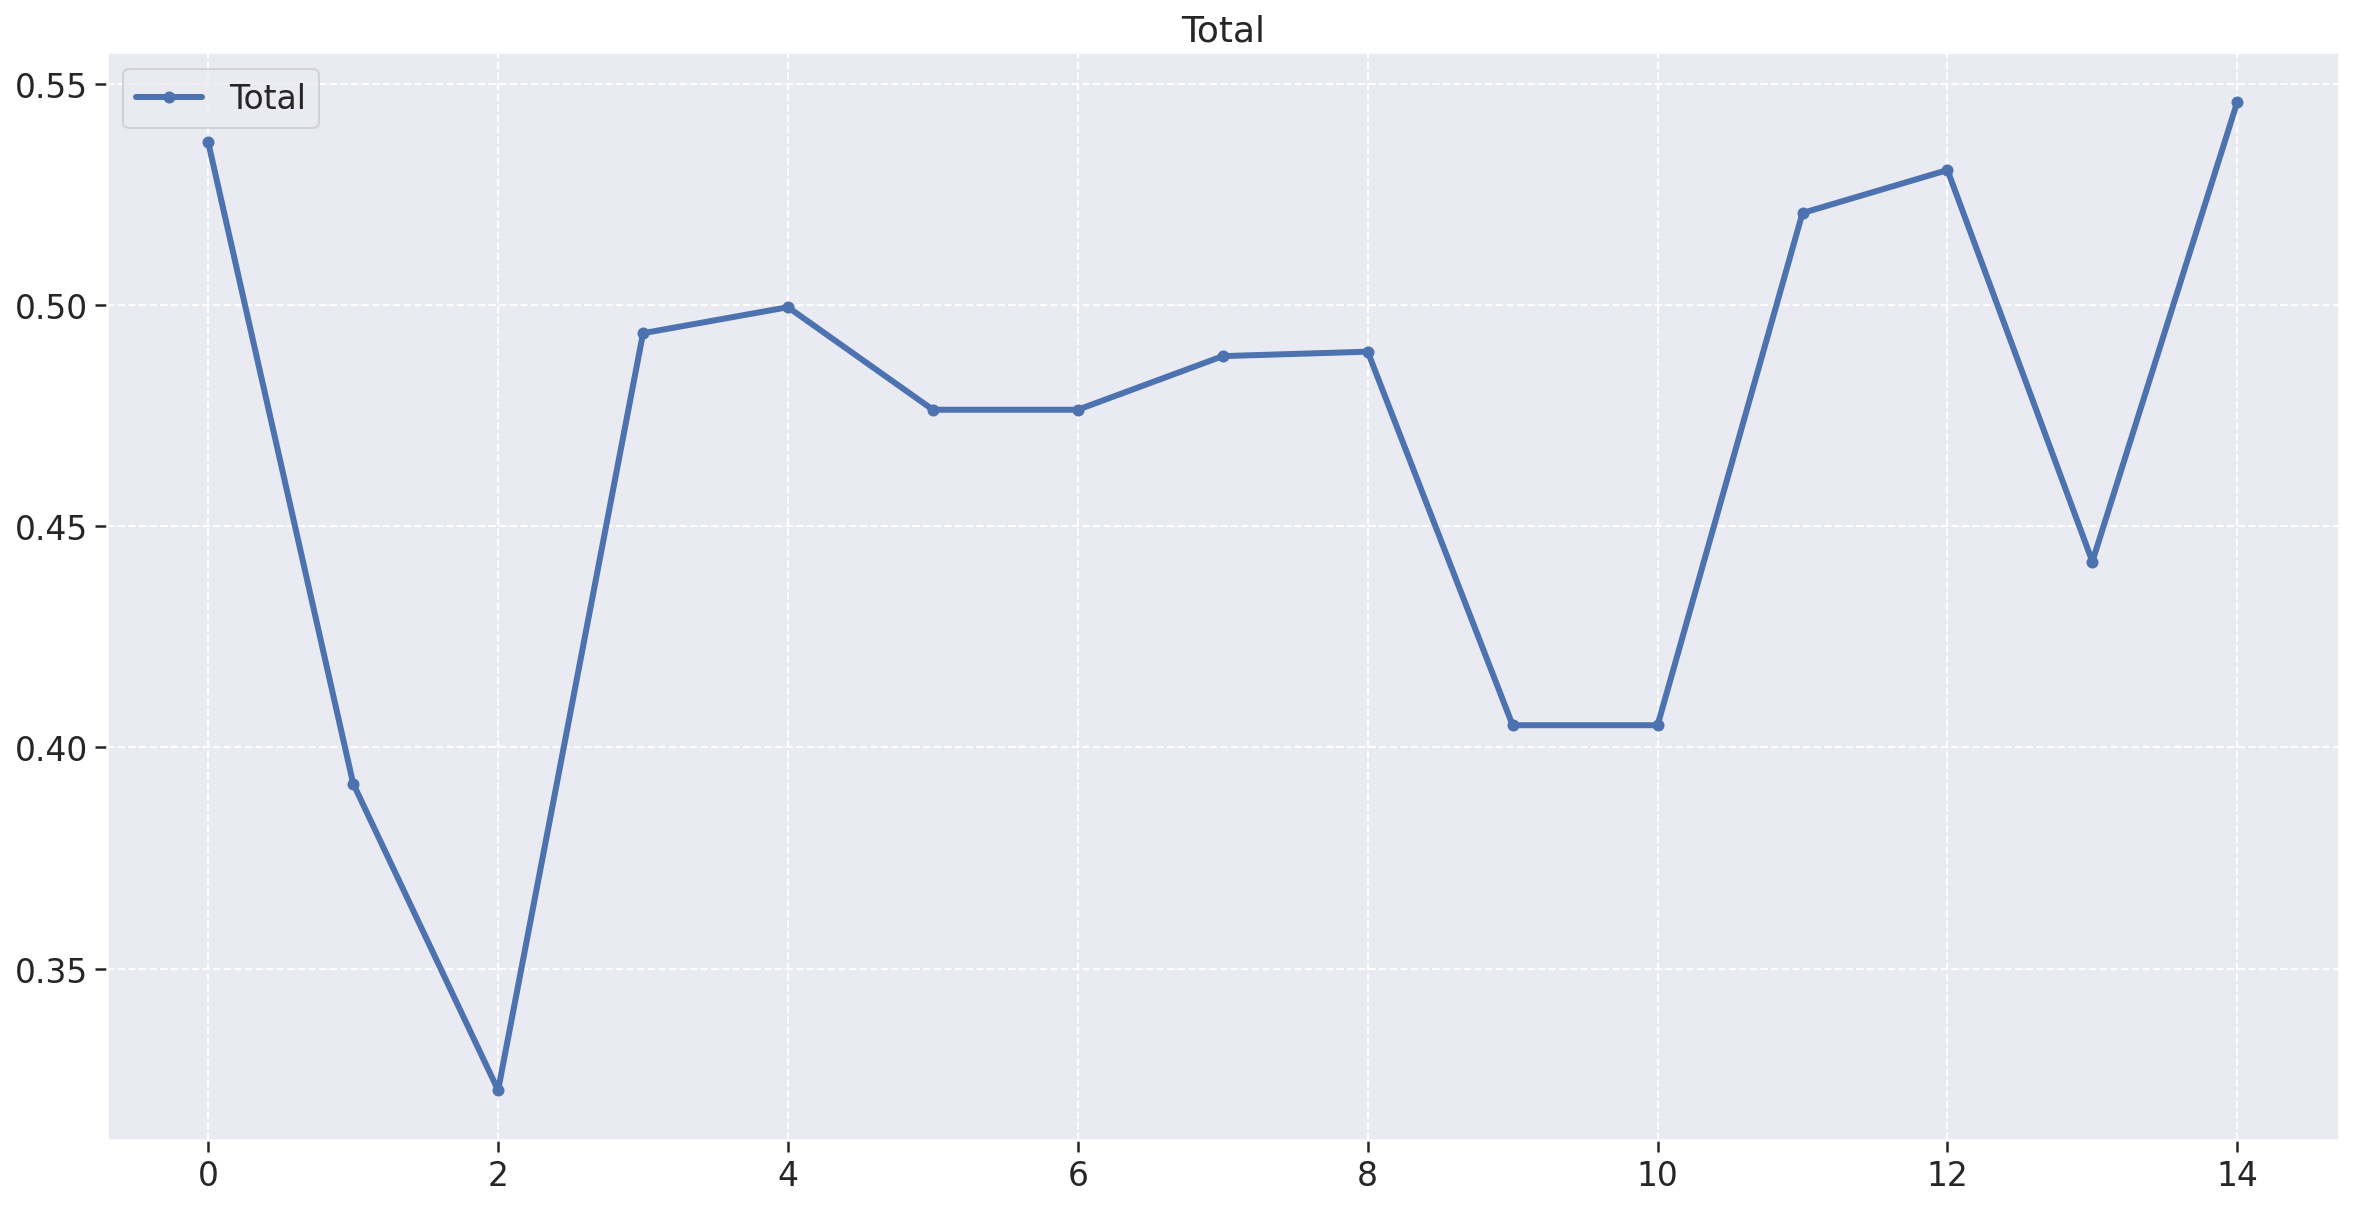

In [96]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5, label='Total')

plt.legend(loc='upper left')

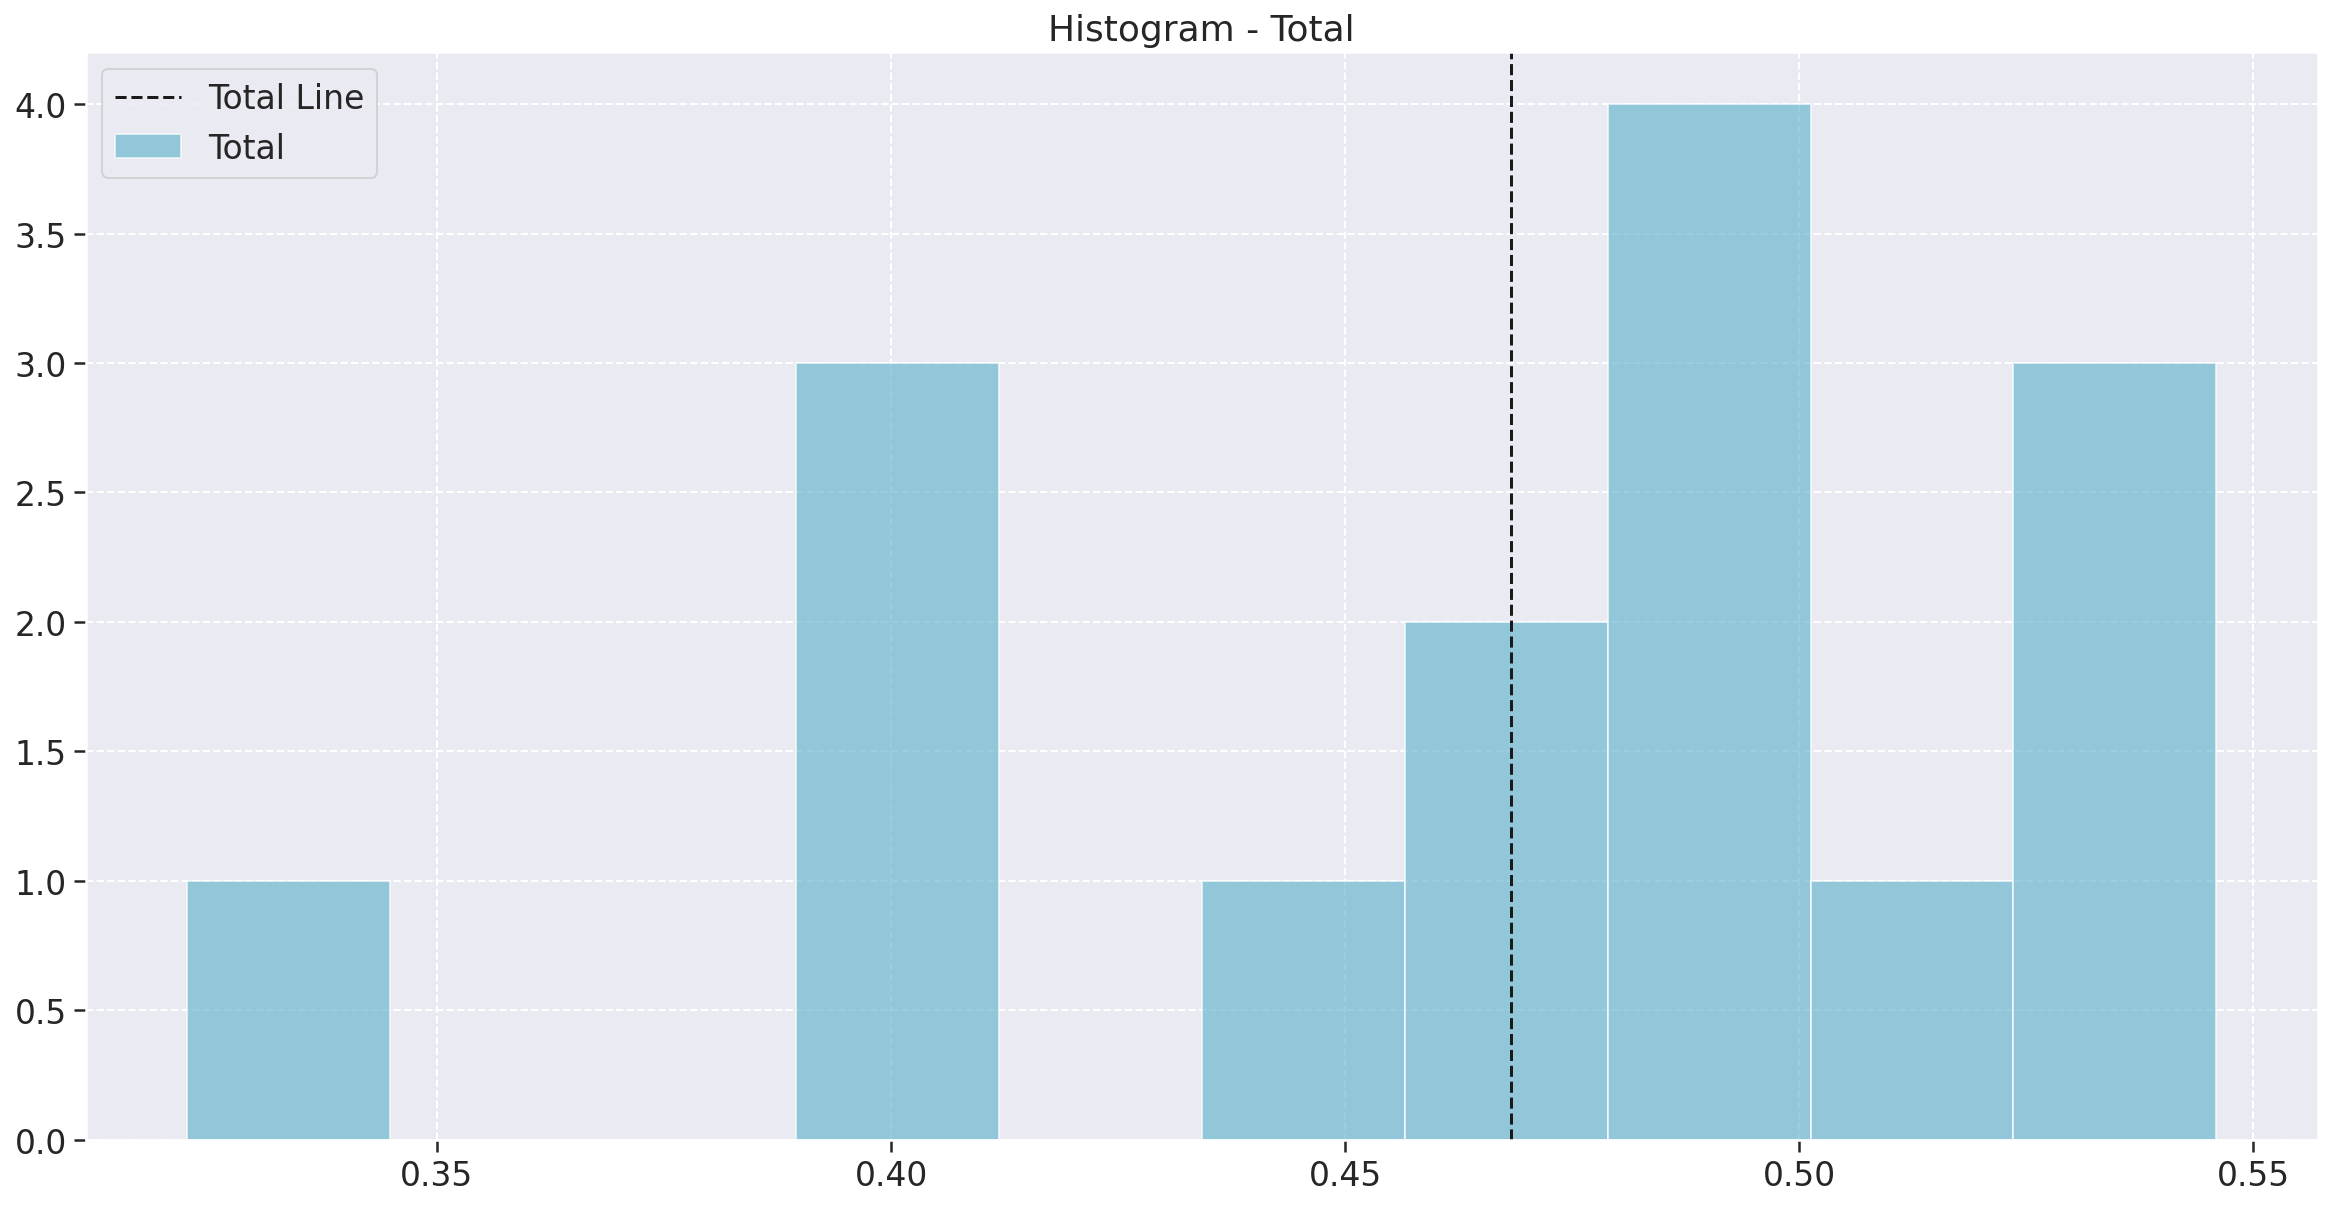

In [97]:
fig = plt.figure(figsize=(20, 10))

plt.title('Histogram - Total')
plt.hist(metrics_df['total'], bins=10, color='c', alpha=0.65, label='Total')
plt.axvline(metrics_df['total'].mean(), color='k', linestyle='dashed', label='Total Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3f9608ae80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3f960975e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3f9608aaf0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f96097d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f960a10d0>],
 'means': []}

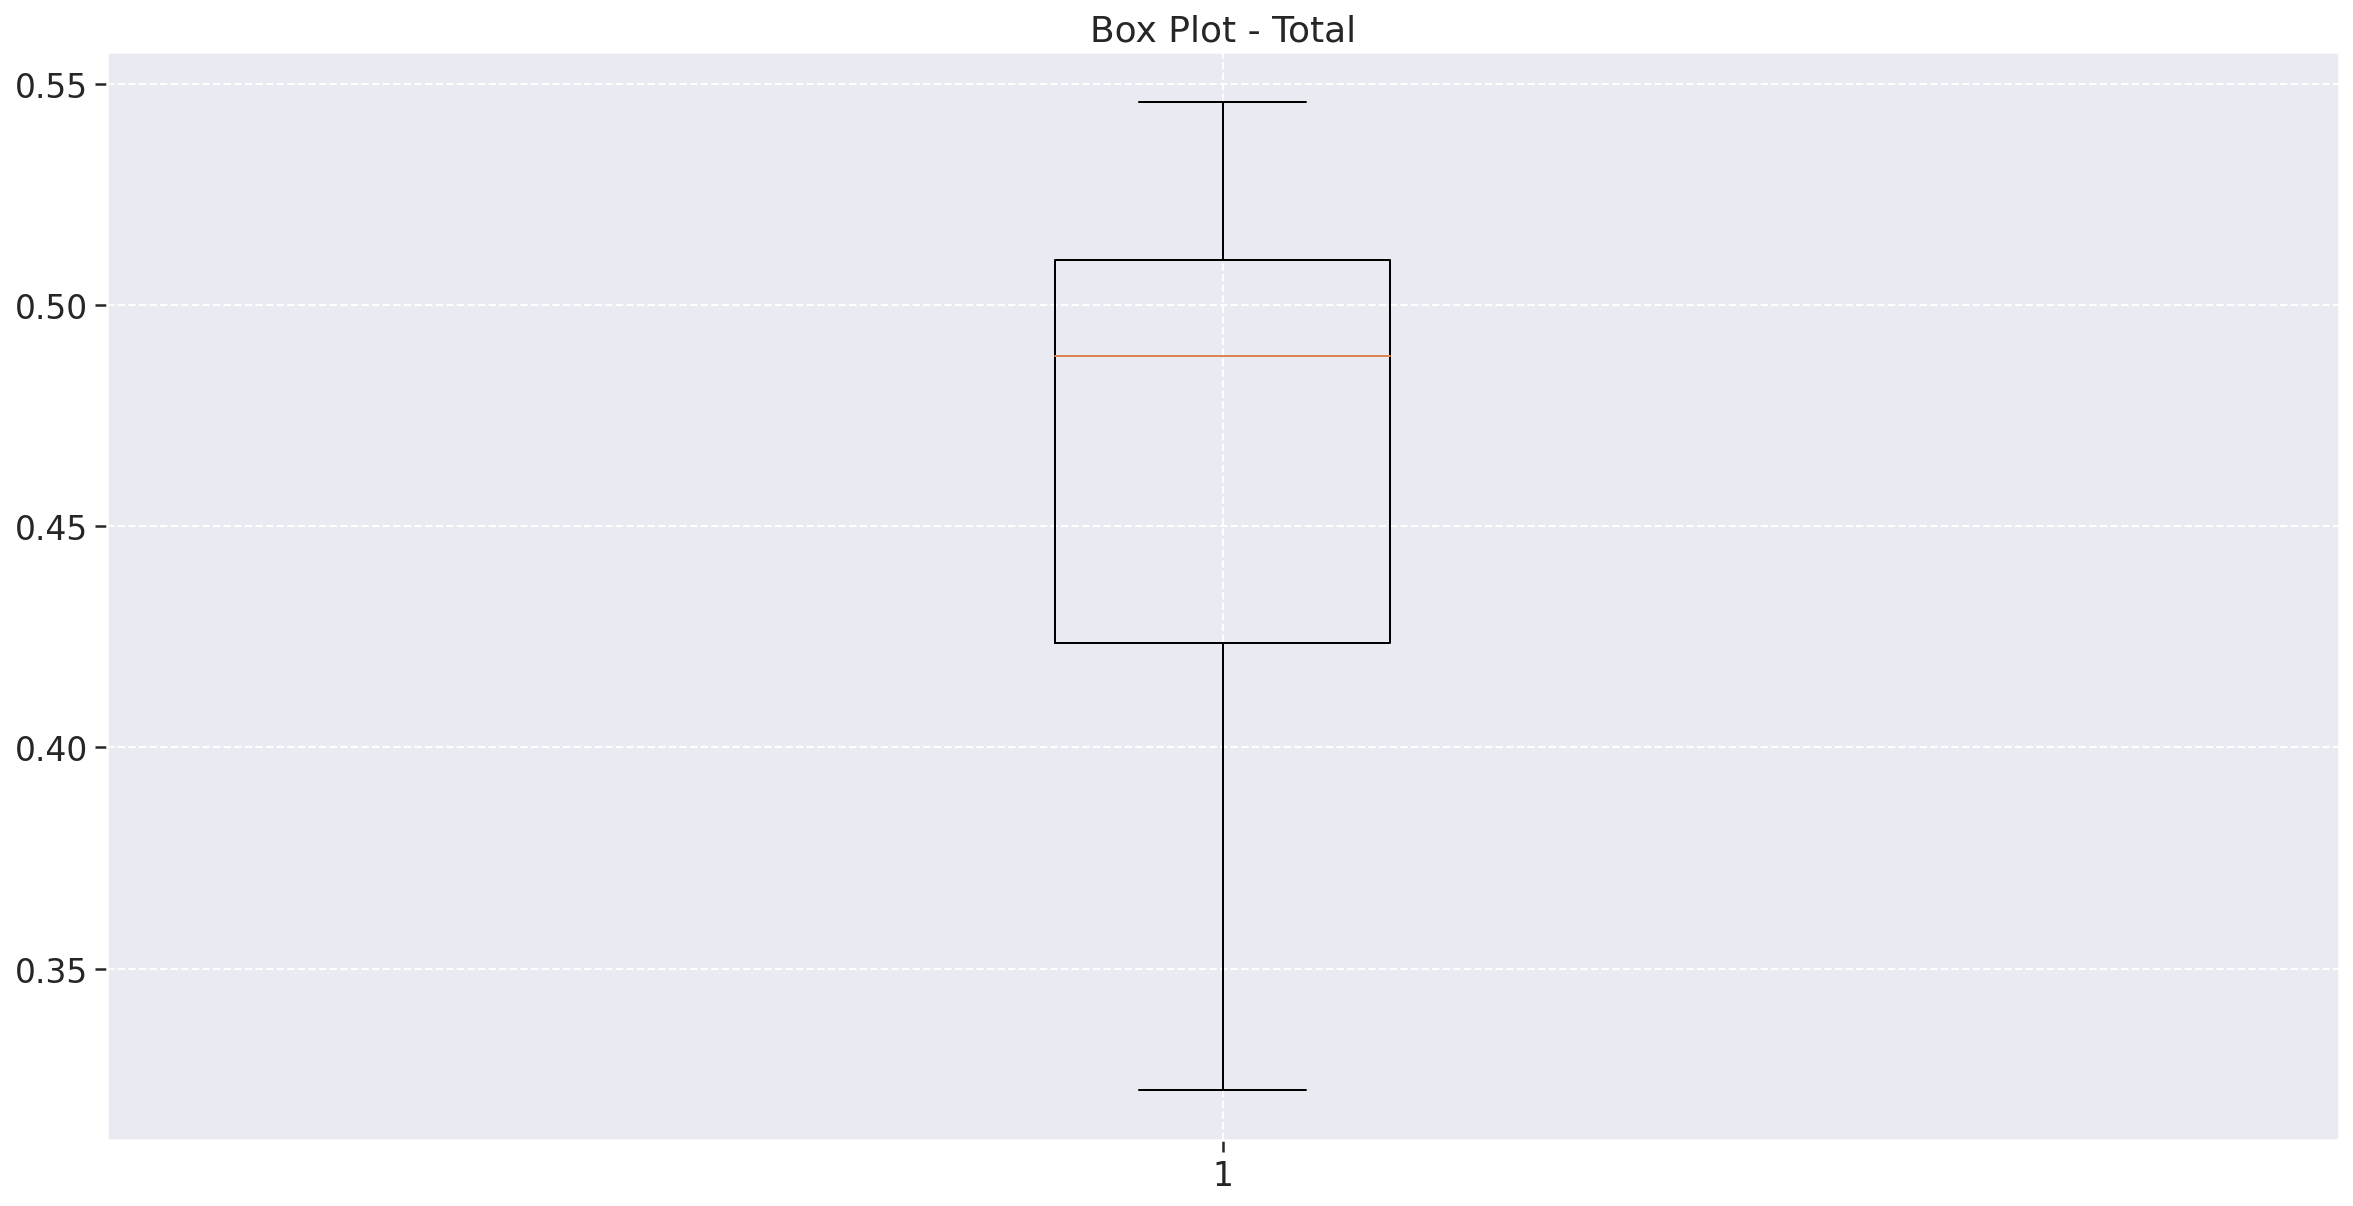

In [98]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Total')
plt.boxplot(metrics_df['total'])

### Explanation

TODO :
- Textual explanation of the observed behavior of the total quality of the system. In essence, this is the analytical description, from the team's point of view, of the explanations of internal quality behavior over the observation period. 

Text(0.5, 1.0, 'Matriz de Correção')

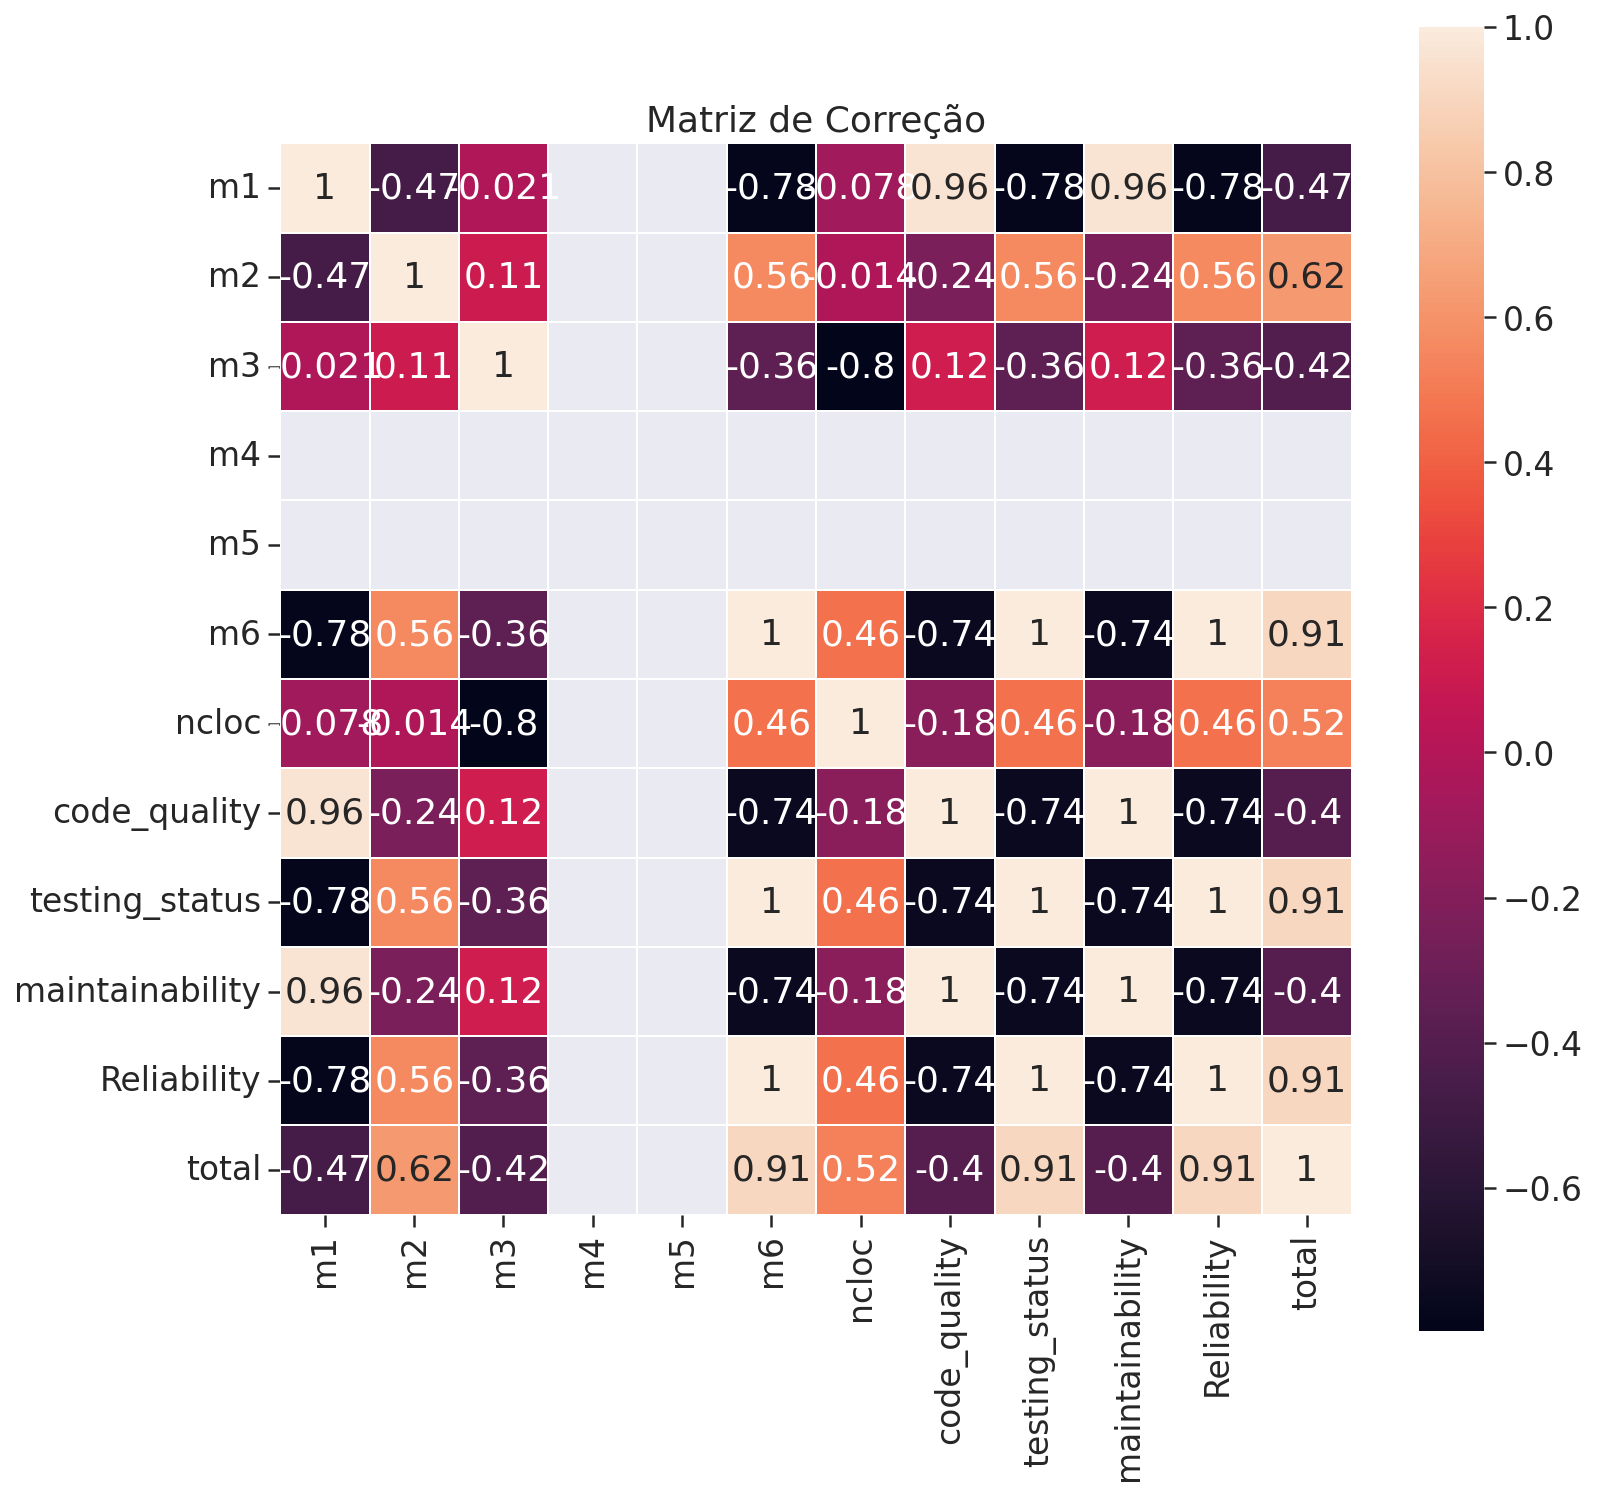

In [99]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(metrics_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção')

In [100]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.432432,0.162162,1.000000,1.0,0,0.567568,Scraper,02-11-2021-23-26,1348,0.526216,0.547297,0.263108,0.273649,0.536757
1,0.636364,0.090909,1.000000,1.0,0,0.090909,Scraper,07-10-2021-07-43,484,0.570000,0.213636,0.285000,0.106818,0.391818
2,0.500000,0.000000,1.000000,1.0,0,0.000000,Scraper,15-09-2021-00-01,138,0.495000,0.150000,0.247500,0.075000,0.322500
3,0.482759,0.103448,1.000000,1.0,0,0.448276,Scraper,21-10-2021-15-11,1058,0.523448,0.463793,0.261724,0.231897,0.493621
4,0.200000,0.100000,1.000000,1.0,0,0.600000,DocumentsAPI,02-11-2021-23-35,359,0.429000,0.570000,0.214500,0.285000,0.499500
5,0.210526,0.105263,1.000000,1.0,0,0.526316,DocumentsAPI,07-10-2021-07-31,336,0.434211,0.518421,0.217105,0.259211,0.476316
6,0.210526,0.105263,1.000000,1.0,0,0.526316,DocumentsAPI,07-10-2021-12-28,341,0.434211,0.518421,0.217105,0.259211,0.476316
7,0.187500,0.125000,1.000000,1.0,0,0.562500,DocumentsAPI,15-09-2021-00-24,289,0.433125,0.543750,0.216562,0.271875,0.488437
8,0.222222,0.111111,1.000000,1.0,0,0.555556,DocumentsAPI,15-10-2021-20-45,266,0.440000,0.538889,0.220000,0.269444,0.489444
9,1.000000,0.000000,1.000000,1.0,0,0.000000,MLTraining,14-09-2021-23-45,138,0.660000,0.150000,0.330000,0.075000,0.405000


In [101]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

metrics_df.to_excel('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.csv'.format(currentTime), index = False)